Imports

In [1]:
%%capture
%pip install pandas_read_xml
%pip install tqdm   
%pip install pymupdf
%pip install numpy
%pip install nltk
%pip install tqdm

import pandas_read_xml as pdx
from pandas_read_xml import flatten, fully_flatten, auto_separate_tables, auto_flatten

import time
import os, sys
import re
import pandas as pd
import numpy as np
import math
import seaborn as sb
import nltk
import tqdm
import time
import gc
import concurrent.futures
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import multiprocessing
import fitz  # this is pymupdf
# from google.colab import drive

# drive.mount('/content/drive')

## Book parsing - JavaNotesForProfessionals

In [151]:
from parsing.preprocessing import pdf_preprocessing

In [152]:
toc_list = pdf_preprocessing.get_toc_list("D:/Skola/Skola-ing/DP/data/books_to_parse/JavaNotesForProfessionals.pdf")

In [153]:
toc_list

[(1, 'Content list', 2),
 (1, 'About', 25),
 (1, 'Chapter 1: Getting started with Java Language', 26),
 (2, 'Section 1.1: Creating Your First Java Program', 26),
 (1, 'Chapter 2: Type Conversion', 32),
 (2, 'Section 2.1: Numeric primitive casting', 32),
 (2, 'Section 2.2: Basic Numeric Promotion', 32),
 (2, 'Section 2.3: Non-numeric primitive casting', 32),
 (2, 'Section 2.4: Object casting', 33),
 (2, 'Section 2.5: Testing if an object can be cast using instanceof', 33),
 (1, 'Chapter 3: Getters and Setters', 34),
 (2, 'Section 3.1: Using a setter or getter to implement a constraint', 34),
 (2, 'Section 3.2: Why Use Getters and Setters?', 34),
 (2, 'Section 3.3: Adding Getters and Setters', 35),
 (1, 'Chapter 4: Reference Data Types', 37),
 (2, 'Section 4.1: Dereferencing', 37),
 (2, 'Section 4.2: Instantiating a reference type', 37),
 (1, "Chapter 5: Java Compiler - 'javac'", 38),
 (2, "Section 5.1: The 'javac' command - getting started", 38),
 (2, 'Section 5.2: Compiling for a di\ue

In [154]:
chaps = pdf_preprocessing.get_section_dict(sections=toc_list, level=3, section_range_start=3, section_range_end=-31, delimiter=":")

In [155]:
chaps

{26: 'Section 1.1',
 32: 'Chapter 2&Section 2.1&Section 2.2&Section 2.3',
 33: 'Section 2.4&Section 2.5',
 34: 'Chapter 3&Section 3.1&Section 3.2',
 35: 'Section 3.3',
 37: 'Chapter 4&Section 4.1&Section 4.2',
 38: 'Chapter 5&Section 5.1',
 40: 'Section 5.2',
 42: 'Chapter 6&Section 6.1&Section 6.2',
 43: 'Section 6.3',
 44: 'Section 6.4&Section 6.5',
 45: 'Section 6.6',
 46: 'Section 6.7&Section 6.8',
 48: 'Chapter 7&Section 7.1&Section 7.2',
 51: 'Chapter 8&Section 8.1&Section 8.2',
 53: 'Section 8.3',
 54: 'Section 8.4',
 55: 'Section 8.5',
 57: 'Section 8.6&Section 8.7',
 59: 'Chapter 9&Section 9.1&Section 9.2',
 60: 'Section 9.3&Section 9.4',
 61: 'Section 9.5&Section 9.6',
 62: 'Section 9.7&Section 9.8',
 63: 'Section 9.9',
 66: 'Chapter 10&Section 10.1&Section 10.2',
 67: 'Section 10.3',
 68: 'Section 10.4',
 69: 'Section 10.5&Section 10.6',
 70: 'Section 10.7',
 71: 'Section 10.8',
 72: 'Section 10.9&Section 10.10',
 73: 'Section 10.11',
 74: 'Section 10.12',
 75: 'Chapter 11&S

In [156]:
special_charset_map = {
    "\\" : "#l_backslash#",
    "/"  : "#r_backslash#",
    ":"  : "#colon#",
    "*"  : "#asterisk#",
    "?"  : "#q_mark#",
    "\"" : "#double_quote#",
    "<"  : "#less#",
    ">"  : "#greater#",
    "|"  : "#pipe#",
}

def get_vals_without_special_char(val, special_char_set_mapping):
    for char in special_char_set_mapping.keys():
        val = val.replace(char, special_char_set_mapping[char])
    return val

In [157]:
# chaps = { key: get_vals_without_special_char(val, special_charset_map) for key, val in chaps.items()}

In [158]:
chaps

{26: 'Section 1.1',
 32: 'Chapter 2&Section 2.1&Section 2.2&Section 2.3',
 33: 'Section 2.4&Section 2.5',
 34: 'Chapter 3&Section 3.1&Section 3.2',
 35: 'Section 3.3',
 37: 'Chapter 4&Section 4.1&Section 4.2',
 38: 'Chapter 5&Section 5.1',
 40: 'Section 5.2',
 42: 'Chapter 6&Section 6.1&Section 6.2',
 43: 'Section 6.3',
 44: 'Section 6.4&Section 6.5',
 45: 'Section 6.6',
 46: 'Section 6.7&Section 6.8',
 48: 'Chapter 7&Section 7.1&Section 7.2',
 51: 'Chapter 8&Section 8.1&Section 8.2',
 53: 'Section 8.3',
 54: 'Section 8.4',
 55: 'Section 8.5',
 57: 'Section 8.6&Section 8.7',
 59: 'Chapter 9&Section 9.1&Section 9.2',
 60: 'Section 9.3&Section 9.4',
 61: 'Section 9.5&Section 9.6',
 62: 'Section 9.7&Section 9.8',
 63: 'Section 9.9',
 66: 'Chapter 10&Section 10.1&Section 10.2',
 67: 'Section 10.3',
 68: 'Section 10.4',
 69: 'Section 10.5&Section 10.6',
 70: 'Section 10.7',
 71: 'Section 10.8',
 72: 'Section 10.9&Section 10.10',
 73: 'Section 10.11',
 74: 'Section 10.12',
 75: 'Chapter 11&S

In [159]:
with fitz.open("D:/Skola/Skola-ing/DP/data/books_to_parse/JavaNotesForProfessionals.pdf") as doc:
    pages = [page.get_text("text", clip=page.bleedbox) for page in doc.pages(0, 921, 1)]

In [160]:
indexes = list(chaps.keys())
print(indexes[0])
chapter_pages = { chaps[indexes[idx]] : (pages[indexes[idx]-1: indexes[idx + 1]-1] if idx < (len(indexes) - 1)
                                    else pages[indexes[idx]-1:]) for idx in range(len(indexes)) }

26


In [161]:
# chapter_pages

In [162]:
preprocesed_sections = pdf_preprocessing.preproces_sections_into_tokens(chapter_pages)

100%|██████████| 629/629 [00:00<00:00, 52629.61it/s]


In [163]:
len(preprocesed_sections)

629

In [164]:
from parsing import user_parsing, dep_parsing_module as dpm
from parsing.preprocessing import user_preprocessing
from parsing.model_evaluation import loading_models

In [165]:
dpm.jar_path = "D:/Skola/Skola-ing/DP/data/StackExchange/dependency_parser/stanford-corenlp-4.2.2/stanford-corenlp-4.2.2.jar"
dpm.models_jar_path = "D:/Skola/Skola-ing/DP/data/StackExchange/dependency_parser/stanford-corenlp-4.2.2-models-english.jar"

In [166]:
# dpm.parse_dependencies("Note that it is possible for an inherited concrete method to prevent the inheritance of an abstract or default method", dpm.basic_pos_relations)

In [167]:
# base_path = "D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/jls8/acm_sub_sections"

# files = os.listdir(base_path)

# # print(files)

# for file in files:
#     sub_files = file.split("&")
#     sub_files = [f'{sub_file.split(" ")[0]} {sub_file.split(" ")[1]}' for sub_file in sub_files]
#     print("&".join(sub_files))
#     os.rename(os.path.join(base_path, file), f'{os.path.join(base_path,"&".join(sub_files))}.txt')

In [168]:
# preprocesed_sections.keys()

Parsing the book tokens

In [169]:
# for key in tqdm.tqdm(preprocesed_sections.keys()):
#     print(key)
#     dpm.parse_section(preprocesed_sections[key], key, dpm.basic_pos_relations, "D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/jls8/acm_sub_sections" )

## Book parsing - jls8

In [170]:
toc_list = pdf_preprocessing.get_toc_list("D:/Skola/Skola-ing/DP/data/books_to_parse/jls8_cropped-1.pdf")

In [171]:
toc_list

[(1, 'The Java® Language Specification', 1),
 (1, 'Table of Contents', 5),
 (1, 'Preface to the Java SE 8 Edition', 19),
 (1, '1. Introduction', 21),
 (2, '1.1. Organization of the Specification', 22),
 (2, '1.2. Example Programs', 26),
 (2, '1.3. Notation', 26),
 (2, '1.4. Relationship to Predefined Classes and Interfaces', 27),
 (2, '1.5. Feedback', 27),
 (2, '1.6. References', 27),
 (3, 'Bibliography', 27),
 (1, '2. Grammars', 29),
 (2, '2.1. Context-Free Grammars', 29),
 (2, '2.2. The Lexical Grammar', 29),
 (2, '2.3. The Syntactic Grammar', 30),
 (2, '2.4. Grammar Notation', 30),
 (1, '3. Lexical Structure', 35),
 (2, '3.1. Unicode', 35),
 (2, '3.2. Lexical Translations', 36),
 (2, '3.3. Unicode Escapes', 37),
 (2, '3.4. Line Terminators', 39),
 (2, '3.5. Input Elements and Tokens', 39),
 (2, '3.6. White Space', 40),
 (2, '3.7. Comments', 41),
 (2, '3.8. Identifiers', 42),
 (2, '3.9. Keywords', 44),
 (2, '3.10. Literals', 44),
 (3, '3.10.1. Integer Literals', 45),
 (3, '3.10.2. Fl

In [172]:
chaps = pdf_preprocessing.get_section_dict(sections=toc_list, level=3, section_range_start=3, section_range_end=-2, delimiter=" ")
# chaps = get_section_dict(sub_chaps_dirs, 2, 3, -2)

In [173]:
chaps

{21: '1.',
 22: '1.1.',
 26: '1.2.&1.3.',
 27: '1.4.&1.5.&1.6.&Bibliography',
 29: '2.&2.1.&2.2.',
 30: '2.3.&2.4.',
 35: '3.&3.1.',
 36: '3.2.',
 37: '3.3.',
 39: '3.4.&3.5.',
 40: '3.6.',
 41: '3.7.',
 42: '3.8.',
 44: '3.9.&3.10.',
 45: '3.10.1.',
 51: '3.10.2.',
 54: '3.10.3.&3.10.4.',
 55: '3.10.5.',
 57: '3.10.6.',
 58: '3.10.7.',
 59: '3.11.&3.12.',
 61: '4.&4.1.',
 62: '4.2.',
 63: '4.2.1.&4.2.2.',
 65: '4.2.3.',
 68: '4.2.4.',
 71: '4.2.5.',
 72: '4.3.',
 73: '4.3.1.',
 76: '4.3.2.&4.3.3.',
 77: '4.3.4.&4.4.',
 79: '4.5.',
 80: '4.5.1.',
 83: '4.5.2.',
 84: '4.6.',
 85: '4.7.',
 86: '4.8.',
 90: '4.9.',
 91: '4.10.&4.10.1.',
 92: '4.10.2.',
 93: '4.10.3.&4.10.4.',
 96: '4.11.',
 100: '4.12.',
 101: '4.12.1.&4.12.2.',
 103: '4.12.3.',
 105: '4.12.4.',
 107: '4.12.5.',
 108: '4.12.6.',
 113: '5.',
 116: '5.1.&5.1.1.&5.1.2.',
 118: '5.1.3.',
 121: '5.1.4.&5.1.5.&5.1.6.',
 122: '5.1.7.',
 124: '5.1.8.',
 125: '5.1.9.&5.1.10.',
 127: '5.1.11.',
 128: '5.1.12.&5.1.13.',
 129: '5.2.'

In [174]:
with fitz.open("D:/Skola/Skola-ing/DP/data/books_to_parse/jls8_cropped-1.pdf") as doc:
    pages = [page.get_text("text", clip=page.bleedbox) for page in doc.pages(0, 787, 1)]

In [175]:
indexes = list(chaps.keys())
print(indexes[0])
chapter_pages = { chaps[indexes[idx]] : (pages[indexes[idx]-1: indexes[idx + 1]-1] if idx < (len(indexes) - 1)
                                    else pages[indexes[idx]-1:]) for idx in range(len(indexes)) }

21


In [176]:
preprocesed_sections = pdf_preprocessing.preproces_sections_into_tokens(chapter_pages)

100%|██████████| 352/352 [00:00<00:00, 58427.12it/s]


In [177]:
# base_path = "D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/jls8/acm_sub_sections"

# files = os.listdir(base_path)

# # print(files)

# for file in files:
#     sub_files = file.split("&")
#     # print(sub_files)
#     sub_files = [f'{sub_file.split(" ")[0]}' for sub_file in sub_files]
#     # print("&".join(sub_files))
#     joined_name = "&".join(sub_files)
#     new_name = f'{os.path.join(base_path,joined_name)}txt' if "txt" not in joined_name else  f'{os.path.join(base_path,joined_name)}'
#     # print(new_name)
#     os.rename(os.path.join(base_path, file), new_name)

In [178]:
dpm.file_type = "txt"

In [179]:
# for key in tqdm.tqdm(preprocesed_sections.keys()):
#     print(key)
#     dpm.parse_section(preprocesed_sections[key], key, dpm.basic_pos_relations, "D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/jls8/acm_sub_sections" )

## Parsing answers of users from SE (Software Engineering)

In [180]:
def load_xml_as_pd_dict(root_folder, folder_names):
    dir_list = os.listdir(root_folder)
    print(dir_list)
    dir_list = [item for item in dir_list if item.split(".")[1] == "xml" if item.split(".")[0].lower() in folder_names]
    pandas_dict = {}
    for elem in dir_list:
        key = elem.split(".")[0]
        print(key)
        df = pdx.read_xml(os.path.join(root_folder, elem), [key.lower()])
        df = df.pipe(flatten)
        df = df.pipe(flatten)
        col_dict = { col_name : col_name.split("@")[1] for col_name in list(df.columns) }
        df = df.rename(columns=col_dict)
        pandas_dict[key.lower()] = df
    return pandas_dict


def display_post_df(posts: pd.core.frame.DataFrame, start, end) -> None:
    print(posts.loc[start:end, ['Id', 'CreationDate', 'PostTypeId', 'OwnerUserId']])


# returns the list of user ids of users which mention a tag in the about me
def get_user_df_by_tags_and_rep(users_df, reputation):
    return users_df.loc[(users_df['AboutMe'].str.contains(r'\bJAVA\b', flags=re.IGNORECASE, na=False)) & (users_df['Reputation'] > reputation)]


def display_users_df(users, start, end):
    print(users.loc[start:end, ['Id', 'Reputation', 'DisplayName']])

    

In [181]:
pd_user_posts_dict = load_xml_as_pd_dict("D:\Skola\Skola-ing\DP\data\StackExchange\SE", ['posts', 'users'])

['Badges.xml', 'Comments.xml', 'PostHistory.xml', 'PostLinks.xml', 'Posts.xml', 'Tags.xml', 'Users.xml', 'Votes.xml', 'Vzorove_data.txt']
Posts
Users


In [182]:
pd_user_posts_dict['posts'].columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'ContentLicense',
       'ParentId', 'OwnerDisplayName', 'LastEditorDisplayName'],
      dtype='object')

In [183]:
pd_user_posts_dict['users'].columns

Index(['Id', 'Reputation', 'CreationDate', 'DisplayName', 'LastAccessDate',
       'WebsiteUrl', 'Location', 'AboutMe', 'Views', 'UpVotes', 'DownVotes',
       'AccountId', 'ProfileImageUrl'],
      dtype='object')

In [184]:
%%capture
pd_user_posts_dict['posts'].head()

In [185]:
%%capture
pd_user_posts_dict['users']

In [186]:
pd_user_posts_dict['users'] = pd_user_posts_dict['users'].drop(columns=['ProfileImageUrl', 'WebsiteUrl', 'LastAccessDate'])
pd_user_posts_dict['posts'] = pd_user_posts_dict['posts'].drop(columns=['LastEditorUserId', 'LastEditDate', 'LastActivityDate'])
pd_user_posts_dict['posts'] = pd_user_posts_dict['posts'].rename(columns={'Id': 'PostId'})

In [187]:
%%capture
pd_user_posts_dict['posts']

In [188]:
%%capture
pd_user_posts_dict['users']

In [189]:
pd_user_posts_dict['posts'].dtypes

PostId                   object
PostTypeId               object
AcceptedAnswerId         object
CreationDate             object
Score                    object
ViewCount                object
Body                     object
OwnerUserId              object
Title                    object
Tags                     object
AnswerCount              object
CommentCount             object
FavoriteCount            object
ClosedDate               object
CommunityOwnedDate       object
ContentLicense           object
ParentId                 object
OwnerDisplayName         object
LastEditorDisplayName    object
dtype: object

In [190]:
pd_user_posts_dict['users'].dtypes

Id              object
Reputation      object
CreationDate    object
DisplayName     object
Location        object
AboutMe         object
Views           object
UpVotes         object
DownVotes       object
AccountId       object
dtype: object

In [191]:
post_convert_dict = {'PostId': int,
                'PostTypeId': int,
                'AcceptedAnswerId': int,
                'Score': int,
                'ViewCount': int,
                'OwnerUserId': int,
                'AnswerCount': int,
                'CommentCount': int,
                'FavoriteCount': int,
                'ParentId': int,
                }

user_convert_dict = {'Id': int,
                'Reputation': int,
                'Views': int,
                'UpVotes': int,
                'DownVotes': int,
                'AccountId': int,
                }

pd_user_posts_dict['users'] = pd_user_posts_dict['users'].fillna(-1).astype(user_convert_dict)
pd_user_posts_dict['posts'] = pd_user_posts_dict['posts'].fillna(-1).astype(post_convert_dict)

In [192]:
pd_user_posts_dict['users']['AboutMe'].isnull().sum()

0

In [193]:
pd_user_posts_dict['users'] = pd_user_posts_dict['users'].sort_values(by="Reputation", ascending=False)

In [194]:
pd_whole_dict = pd_user_posts_dict.copy()

In [195]:
pd_user_posts_dict['users'] = get_user_df_by_tags_and_rep(pd_user_posts_dict['users'], 110)
pd_whole_dict['users'] = get_user_df_by_tags_and_rep(pd_whole_dict['users'], 100)

In [196]:
pd_user_posts_dict['users'][:10]

,Id,Reputation,CreationDate,DisplayName,Location,AboutMe,Views,UpVotes,DownVotes,AccountId
1156,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172
11131,14221,45837,2011-01-24T09:11:22.457,Péter Török,"Turku, Finland",<p>Started programming around 1983 on ABC-80 a...,4293,2721,53,97818
2668,3249,42615,2010-09-21T16:25:12.203,Aaronaught,"Mountain View, CA",<p>Software engineer at Google. Not an enterpr...,3705,195,372,17239
52120,61852,38302,2012-08-14T21:18:50.363,Tulains Córdova,Spain,<blockquote>\n<p>I seek not to know all the an...,2313,2641,607,1748798
13277,16929,32984,2011-02-11T19:24:56.147,kevin cline,"Seattle, WA, USA",<p>I've been programming since I was 15. I st...,3697,2074,104,81527
1960,2314,27571,2010-09-16T20:55:49.863,Nicole,"Salt Lake City, UT, United States",<p>Full stack software engineer. I've mostly u...,4296,1386,180,48256
5757,7167,24282,2010-11-06T18:39:18.337,Gary Rowe,United Kingdom,<p>I'm a web developer working in the UK. I ha...,1621,2025,11,170199
535,611,21854,2010-09-09T11:46:40.187,Martijn Verburg,"London, United Kingdom","<p>(aka the ""Diabolical Developer""). I'm the ...",2165,561,20,166592
98230,121368,20110,2014-02-26T05:40:29.277,Aviv Cohn,Israel,<p>Passionate about C++ development and softwa...,1209,363,6,3773810
16134,20673,19596,2011-03-20T05:23:58.393,DXM,"Rochester, NY",<p>In my previous life I have always been a ba...,1308,571,45,208582


In [197]:
pd_user_posts_dict['posts']

,PostId,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,ParentId,OwnerDisplayName,LastEditorDisplayName
0,1,1,13,2010-09-01T19:34:48.000,100,58142,<p>A coworker of mine believes that <em>any</e...,6,"""Comments are a code smell""",<comments><anti-patterns>,34,10,76,2012-11-27T20:11:51.580,2011-01-31T09:04:54.130,CC BY-SA 2.5,-1,-1,-1
1,3,2,-1,2010-09-01T19:36:50.053,29,-1,"<p>Ideally, code should be so well coded that ...",11,-1,-1,-1,17,-1,-1,2011-01-31T09:04:54.130,CC BY-SA 2.5,1,-1,-1
2,4,1,26,2010-09-01T19:37:39.957,66,9565,<p>When starting a project for a company that'...,-1,Getting non-programmers to understand the deve...,<business><project-management><development-pro...,12,2,34,-1,-1,CC BY-SA 2.5,-1,user8,user8
3,7,2,-1,2010-09-01T19:42:16.797,10,-1,"<p>I think the answer is the usual ""It depends...",21,-1,-1,-1,0,-1,-1,2011-01-31T09:04:54.130,CC BY-SA 2.5,1,-1,-1
4,9,1,-1,2010-09-01T19:43:04.957,39,13113,"<p>Sometimes, the things I have to do for my j...",17,How do you stay focused at work?,<productivity><time-management>,24,1,26,2012-11-13T19:09:35.853,2011-01-04T21:22:43.957,CC BY-SA 2.5,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232234,431658,2,-1,2021-09-04T21:15:21.363,1,-1,"<p>When building event driven systems, events ...",60357,-1,-1,-1,1,-1,-1,-1,CC BY-SA 4.0,431657,-1,-1
232235,431659,1,-1,2021-09-04T21:53:17.773,0,7,"<p>I am working on an application right now, w...",401491,Handling realtime notification receivers in a ...,<web><websockets><real-time><notifications>,0,0,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1
232236,431660,1,-1,2021-09-04T22:35:19.087,0,19,<p>This is more of a design/architecture quest...,400361,Designing a logic to receive ACK for every mes...,<architecture><c><message-queue><embedded-syst...,0,0,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1
232237,431661,2,-1,2021-09-04T23:55:02.070,1,-1,<p>To simply fix the issue at hand (data reten...,284628,-1,-1,-1,0,-1,-1,-1,CC BY-SA 4.0,431657,-1,-1


In [198]:
def count_q_a_by_user_id(post_df, user_id):
    return len(post_df.loc[(post_df['OwnerUserId'] == user_id) & (post_df['PostTypeId'] == 1)]), len(post_df.loc[(post_df['OwnerUserId'] == user_id) & (post_df['PostTypeId'] == 2)])



def get_user_ids_for_filtering(user_df, post_df, comparator, min_q_count, min_a_count):
    user_id_list = []
    for idx, user_row in user_df.iterrows():
        # print(user_row['Id'])
        user_q_count, user_a_count = count_q_a_by_user_id(post_df, user_row['Id'])
        if comparator(user_a_count, user_q_count, min_a_count, min_q_count):
            user_id_list.append(user_row['Id'])
        # if user_a_count >= 1:
        #     user_id_list.append(user_row['Id'])
    return user_id_list 

In [199]:
comparator_func = lambda x_count,y_count,x_val_2_cmp, y_val_2_cmp: True if x_count >= x_val_2_cmp and y_count >= y_val_2_cmp else False  

In [200]:
id_list = get_user_ids_for_filtering(pd_user_posts_dict['users'], pd_user_posts_dict['posts'], comparator_func, 1, 1)

In [201]:
len(id_list)

448

In [202]:
%%capture
id_list

Storing which users have questions and answers

In [203]:
user_preprocessing.save_dict_to_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\question_answers", "q_a_all_id_list.txt", id_list)

In [204]:
id_list[0]

1352

In [205]:
pd_user_posts_dict['users'] = pd_user_posts_dict['users'].loc[pd_user_posts_dict['users']['Id'].isin(id_list)]

In [206]:
pd_user_posts_dict['users']

,Id,Reputation,CreationDate,DisplayName,Location,AboutMe,Views,UpVotes,DownVotes,AccountId
1156,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172
2668,3249,42615,2010-09-21T16:25:12.203,Aaronaught,"Mountain View, CA",<p>Software engineer at Google. Not an enterpr...,3705,195,372,17239
52120,61852,38302,2012-08-14T21:18:50.363,Tulains Córdova,Spain,<blockquote>\n<p>I seek not to know all the an...,2313,2641,607,1748798
13277,16929,32984,2011-02-11T19:24:56.147,kevin cline,"Seattle, WA, USA",<p>I've been programming since I was 15. I st...,3697,2074,104,81527
1960,2314,27571,2010-09-16T20:55:49.863,Nicole,"Salt Lake City, UT, United States",<p>Full stack software engineer. I've mostly u...,4296,1386,180,48256
...,...,...,...,...,...,...,...,...,...,...
21247,26856,113,2011-06-02T20:55:54.303,JAB,-1,<p>I'm a science fiction &amp; fantasy buff an...,41,1060,0,46902
29504,36193,113,2011-09-07T20:05:18.687,BOWS,"London, United Kingdom",<p>Lead software engineer with a strong backgr...,14,3,0,541225
255461,309395,111,2018-07-02T02:55:47.190,Naxin,-1,<p>Languages I will likely ask questions about...,1,0,0,4787505
124487,157919,111,2014-12-01T20:04:44.570,ARK,"McLean, VA, USA",<p>Software Developer and Chess Grandmaster.</...,14,3,0,3335571


In [207]:
sampling_factor = 1
pd_user_posts_dict['users'] = pd_user_posts_dict['users'].iloc[::sampling_factor,:]
id_list = list(pd_user_posts_dict['users']['Id'])

In [208]:
# %%capture
pd_user_posts_dict['users']

,Id,Reputation,CreationDate,DisplayName,Location,AboutMe,Views,UpVotes,DownVotes,AccountId
1156,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172
2668,3249,42615,2010-09-21T16:25:12.203,Aaronaught,"Mountain View, CA",<p>Software engineer at Google. Not an enterpr...,3705,195,372,17239
52120,61852,38302,2012-08-14T21:18:50.363,Tulains Córdova,Spain,<blockquote>\n<p>I seek not to know all the an...,2313,2641,607,1748798
13277,16929,32984,2011-02-11T19:24:56.147,kevin cline,"Seattle, WA, USA",<p>I've been programming since I was 15. I st...,3697,2074,104,81527
1960,2314,27571,2010-09-16T20:55:49.863,Nicole,"Salt Lake City, UT, United States",<p>Full stack software engineer. I've mostly u...,4296,1386,180,48256
...,...,...,...,...,...,...,...,...,...,...
21247,26856,113,2011-06-02T20:55:54.303,JAB,-1,<p>I'm a science fiction &amp; fantasy buff an...,41,1060,0,46902
29504,36193,113,2011-09-07T20:05:18.687,BOWS,"London, United Kingdom",<p>Lead software engineer with a strong backgr...,14,3,0,541225
255461,309395,111,2018-07-02T02:55:47.190,Naxin,-1,<p>Languages I will likely ask questions about...,1,0,0,4787505
124487,157919,111,2014-12-01T20:04:44.570,ARK,"McLean, VA, USA",<p>Software Developer and Chess Grandmaster.</...,14,3,0,3335571


In [209]:
combined = pd_user_posts_dict['users'].merge(pd_user_posts_dict['posts'], left_on="Id", right_on="OwnerUserId")

In [210]:
combined.head()

,Id,Reputation,CreationDate_x,DisplayName,Location,AboutMe,Views,UpVotes,DownVotes,AccountId,...,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,ParentId,OwnerDisplayName,LastEditorDisplayName
0,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,2,-1,-1,2011-03-07T21:04:52.237,CC BY-SA 2.5,940,-1,-1
1,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,2,-1,-1,-1,CC BY-SA 2.5,10832,-1,-1
2,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,8,-1,-1,-1,CC BY-SA 2.5,18074,-1,-1
3,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,0,-1,-1,-1,CC BY-SA 2.5,19158,-1,-1
4,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,0,-1,-1,-1,CC BY-SA 2.5,19416,-1,-1


In [211]:
combined.loc[combined['Id'] == 1352].columns

Index(['Id', 'Reputation', 'CreationDate_x', 'DisplayName', 'Location',
       'AboutMe', 'Views', 'UpVotes', 'DownVotes', 'AccountId', 'PostId',
       'PostTypeId', 'AcceptedAnswerId', 'CreationDate_y', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense', 'ParentId', 'OwnerDisplayName',
       'LastEditorDisplayName'],
      dtype='object')

In [212]:
combined.loc[combined['PostTypeId'] == 1]

,Id,Reputation,CreationDate_x,DisplayName,Location,AboutMe,Views,UpVotes,DownVotes,AccountId,...,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,ParentId,OwnerDisplayName,LastEditorDisplayName
77,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,<java><c#><scala><haskell><algebraic-data-type>,7,16,23,-1,-1,CC BY-SA 4.0,-1,-1,-1
841,3249,42615,2010-09-21T16:25:12.203,Aaronaught,"Mountain View, CA",<p>Software engineer at Google. Not an enterpr...,3705,195,372,17239,...,<programming-practices><.net>,8,9,3,-1,-1,CC BY-SA 2.5,-1,-1,-1
857,3249,42615,2010-09-21T16:25:12.203,Aaronaught,"Mountain View, CA",<p>Software engineer at Google. Not an enterpr...,3705,195,372,17239,...,<architecture><enterprise-architecture><servic...,2,0,4,-1,-1,CC BY-SA 3.0,-1,-1,-1
866,3249,42615,2010-09-21T16:25:12.203,Aaronaught,"Mountain View, CA",<p>Software engineer at Google. Not an enterpr...,3705,195,372,17239,...,<design-patterns><architecture><data><domain-m...,1,4,1,-1,-1,CC BY-SA 3.0,-1,-1,-1
884,3249,42615,2010-09-21T16:25:12.203,Aaronaught,"Mountain View, CA",<p>Software engineer at Google. Not an enterpr...,3705,195,372,17239,...,<web-development><web-applications><security><...,4,3,7,-1,-1,CC BY-SA 3.0,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,26856,113,2011-06-02T20:55:54.303,JAB,-1,<p>I'm a science fiction &amp; fantasy buff an...,41,1060,0,46902,...,<version-control><branching><ui>,1,1,-1,-1,-1,CC BY-SA 3.0,-1,-1,-1
9249,36193,113,2011-09-07T20:05:18.687,BOWS,"London, United Kingdom",<p>Lead software engineer with a strong backgr...,14,3,0,541225,...,<java><web-development><sql><frameworks>,5,3,2,2015-11-19T22:25:35.310,-1,CC BY-SA 3.0,-1,-1,-1
9252,309395,111,2018-07-02T02:55:47.190,Naxin,-1,<p>Languages I will likely ask questions about...,1,0,0,4787505,...,<c#><unit-testing><.net><async><tcp>,1,0,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1
9254,157919,111,2014-12-01T20:04:44.570,ARK,"McLean, VA, USA",<p>Software Developer and Chess Grandmaster.</...,14,3,0,3335571,...,<java><programming-practices><interfaces><even...,3,2,1,-1,-1,CC BY-SA 3.0,-1,-1,-1


Calculating num of questions and answers for Z score

In [213]:
# for _, row in combined.iterrows():
#         # print(user_row['Id'])
#         user_q_count, user_a_count = count_q_a_by_user_id(post_df, user_row['Id'])

q_a_dict = { user_id : count_q_a_by_user_id(combined, user_id) for user_id in id_list  }

def has_questions(x):
    return True if x > 0 else False

In [214]:
# filter out only the users which dont have any questions
q_a_dict = dict(filter(lambda x: x if x[1][0] > 0 else None, q_a_dict.items()))

In [215]:
%%capture
q_a_dict

In [216]:
from parsing import user_parsing, dep_parsing_module as dpm
from parsing.preprocessing import user_preprocessing
from parsing.model_evaluation import loading_models

In [217]:
user_preprocessing.save_dict_to_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores", "z_scores2.txt", q_a_dict)

In [ ]:
sub_df_answers = combined.loc[combined['PostTypeId'] == 2, ['Id', 'PostId', 'Body']]

In [ ]:
sub_df_answers

,Id,PostId,Body
0,1352,2952,"<p>I don't have a single ""best"" version contro..."
1,1352,10940,<p>There are two kinds of private code: privat...
2,1352,18079,<p>How do closed source projects maintain qual...
3,1352,19160,<p>Pair Programming is a great way of dissemin...
4,1352,20260,<p>I found this definition very simple to expl...
...,...,...,...
2295,282899,414687,<p>I'm working on a project to do exactly this...
2296,92366,199728,"<p>Are you ""copying"" the part of the program o..."
2297,92366,199730,"<p>Maybe you can use <a href=""http://xstream.c..."
2300,57681,154286,"<p>Well, for developing the business logic for..."


In [ ]:
sub_df_answers.iloc[1]['Body']

'<p>There are two kinds of private code: private code that gets called by public code (or private code that gets called by private code that gets called by public code (or ...)) and private code that <em>does</em> not eventually get called by public code.</p>\n\n<p>The former already gets tested through the tests for the public code. The latter cannot be called <em>at all</em> and thus should be deleted, not tested.</p>\n\n<p>Note that when you do TDD it is impossible for untested private code to exist.</p>\n'

In [ ]:
# !cp -r "drive/MyDrive/Colab Notebooks/python_modules/parsing_module/parsing" /content

In [ ]:
tags_pattern = re.compile(r"<.*?>")

In [ ]:
# !rm -rf parsing

In [ ]:
sub_df_answers['Body'] = sub_df_answers['Body'].apply(lambda x: re.sub(tags_pattern, "", x))

In [ ]:
values_to_remove = os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\answers")

In [ ]:
values_to_remove = [int(val.split("userId")[1]) for val in values_to_remove]

In [ ]:
len(values_to_remove)

101

In [ ]:
1352 in values_to_remove

True

In [ ]:
# values_to_remove = [611, 1352, 2314, 3249, 4603, 11200, 14221, 3922, 19697, 24912]

In [ ]:
len(id_list)

90

In [ ]:
custom_vals_to_remove = [val for val in values_to_remove if val in id_list]

print(custom_vals_to_remove)

# for val in values_to_remove:
#     print(val in id_list)

[102854, 1352, 146161, 227552, 24912, 311114, 33851, 4603, 48295, 79256]


In [ ]:
def remove_val(given_list, value_list):
    # Traverse the value list
    for value in value_list:
       # using while loop to remove all occurrences of given value
        while(value in given_list):
            # removing the value using remove()
            given_list.remove(value)
           # return the list
    return given_list

In [ ]:
custom_vals_to_remove

[102854, 1352, 146161, 227552, 24912, 311114, 33851, 4603, 48295, 79256]

In [ ]:
24912 in id_list

True

In [ ]:
id_list = remove_val(id_list, values_to_remove)
# id_list = [val for val in id_list if val not in values_to_remove]

In [ ]:
id_list

[7167,
 5692,
 12750,
 7080,
 90992,
 147,
 39690,
 1177,
 139925,
 4662,
 76809,
 27540,
 187465,
 23010,
 9274,
 2554,
 26547,
 10190,
 62100,
 1028,
 10935,
 55875,
 238259,
 13021,
 54997,
 30302,
 34380,
 63475,
 126703,
 8586,
 16868,
 7610,
 5879,
 3801,
 57752,
 19256,
 86778,
 49207,
 31706,
 104231,
 52573,
 71391,
 223337,
 3354,
 255048,
 25015,
 6330,
 144,
 251840,
 94044,
 29472,
 34175,
 37721,
 201816,
 8369,
 18006,
 127226,
 260713,
 43880,
 97857,
 280963,
 59603,
 19232,
 101210,
 271094,
 49377,
 47207,
 13937,
 6703,
 315606,
 98498,
 173159,
 77009,
 61731,
 125350,
 97556,
 282899,
 92366,
 57681,
 309395]

In [ ]:
len(id_list)

80

In [ ]:
body_txt = sub_df_answers.loc[sub_df_answers['Id'] == 36049]['Body']

In [ ]:
print(body_txt)

Series([], Name: Body, dtype: object)


Setting paths to the dependency parser

In [ ]:
dpm.jar_path = "D:/Skola/Skola-ing/DP/data/StackExchange/dependency_parser/stanford-corenlp-4.2.2/stanford-corenlp-4.2.2.jar"
dpm.models_jar_path = "D:/Skola/Skola-ing/DP/data/StackExchange/dependency_parser/stanford-corenlp-4.2.2-models-english.jar"

In [ ]:
root_dir = "D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers/userId"

def execute_user_parsing(dir_path, id_list, answer_df):
  for user_id in id_list:
      print(f"User id is : {user_id}")
      
      if not os.path.exists(dir_path + str(user_id)):
          os.mkdir(dir_path + str(user_id))
          time.sleep(5)
      
      # print(dir_path + str(user_id))

      local_user_df = answer_df.loc[answer_df['Id'] == user_id, ['PostId', 'Body']]

      print(f"Processing \"{len(local_user_df)}\" answers ...")

      local_dict = dict(zip(list(local_user_df['PostId'].astype(str)), list(local_user_df['Body'])))
      user_preprocessing.preproces_questions_into_tokens(local_dict)
      
      post_list = user_preprocessing.get_list_of_posts(local_dict)

      with multiprocessing.Pool(multiprocessing.cpu_count()) as exec:
        processes = []
        sub_post_list = [post_list[n:n+4] for n in range(0, len(post_list), 4)]
        for sub_post in tqdm.tqdm(sub_post_list):
            # args = [(local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)) for key in sub_post]
            # print(args[0])
            # exec.starmap(dpm.parse_section, args)
            for key in sub_post:
              dpm.parse_section(local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id))
            #   # print(f"key is : {key}")
            #   # print(local_dict[key])
            #   # print(dpm.basic_pos_relations)
            #   # exec.submit(dpm.parse_section, *(local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)))  
            #   p = multiprocessing.Process(target=dpm.parse_section, args=[local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)]) 
            #   p.start()
            #   processes.append(p)
            # for process in processes:
            #     process.join()          
                          

In [1]:
# execute_user_parsing(root_dir, id_list[:], sub_df_answers)

## Processing & parsing the accepted answers

In [ ]:
pd_accepted_q = pd_whole_dict['posts'].loc[pd_whole_dict['posts']['AcceptedAnswerId'] >= 0].copy()
len(pd_accepted_q)

34661

In [ ]:
pd_accepted_q

,PostId,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,ParentId,OwnerDisplayName,LastEditorDisplayName
0,1,1,13,2010-09-01T19:34:48.000,100,58142,<p>A coworker of mine believes that <em>any</e...,6,"""Comments are a code smell""",<comments><anti-patterns>,34,10,76,2012-11-27T20:11:51.580,2011-01-31T09:04:54.130,CC BY-SA 2.5,-1,-1,-1
2,4,1,26,2010-09-01T19:37:39.957,66,9565,<p>When starting a project for a company that'...,-1,Getting non-programmers to understand the deve...,<business><project-management><development-pro...,12,2,34,-1,-1,CC BY-SA 2.5,-1,user8,user8
7,16,1,3675,2010-09-01T19:46:45.303,35,7372,<p>I have read a few articles on Internet abou...,18,Do dynamic typed languages deserve all the cri...,<programming-languages><dynamic-typing><static...,9,9,16,2013-02-20T21:50:27.170,-1,CC BY-SA 3.0,-1,-1,-1
8,18,1,25,2010-09-01T19:47:11.323,7,694,"<p>At first glance, I'd say a good programming...",9,Which (programming) specialities are needed in...,<team><web-development>,4,0,3,2013-08-02T14:29:15.503,-1,CC BY-SA 2.5,-1,-1,-1
14,38,1,54,2010-09-01T19:57:03.197,9,594,<p>Where waterfall commonly includes:</p>\n\n<...,9,How much effort should be put in each part of ...,<project-management><waterfall>,2,0,0,-1,-1,CC BY-SA 2.5,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232157,431559,1,431561,2021-09-01T01:22:37.640,17,2038,<p>Suppose I'm building a web application usin...,29231,How do you test and demonstrate that you have ...,<testing><multithreading><concurrency>,3,6,2,2021-09-01T17:49:20.140,-1,CC BY-SA 4.0,-1,-1,-1
232175,431579,1,431581,2021-09-01T19:24:09.113,0,78,<p>I've been running into a common pattern whe...,343245,How to combine data from multiple sources into...,<design><java><design-patterns><microservices>,1,1,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1
232192,431604,1,431606,2021-09-02T20:48:00.167,2,93,<p>I have been assigned a ticket to update all...,396556,Is there merit to keeping packages/dependencie...,<node.js><dependencies><packages><legacy-code>,3,0,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1
232195,431607,1,431609,2021-09-02T22:02:37.953,0,37,<p>I’m struggling a bit to design the followin...,374484,Design class with different dependency require...,<design><design-patterns><object-oriented-desi...,1,0,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1


In [ ]:
merged_accepted = pd_accepted_q.merge(pd_whole_dict['posts'], left_on="AcceptedAnswerId", right_on="PostId")
del pd_accepted_q
gc.collect()

81

In [ ]:
merged_accepted.columns

Index(['PostId_x', 'PostTypeId_x', 'AcceptedAnswerId_x', 'CreationDate_x',
       'Score_x', 'ViewCount_x', 'Body_x', 'OwnerUserId_x', 'Title_x',
       'Tags_x', 'AnswerCount_x', 'CommentCount_x', 'FavoriteCount_x',
       'ClosedDate_x', 'CommunityOwnedDate_x', 'ContentLicense_x',
       'ParentId_x', 'OwnerDisplayName_x', 'LastEditorDisplayName_x',
       'PostId_y', 'PostTypeId_y', 'AcceptedAnswerId_y', 'CreationDate_y',
       'Score_y', 'ViewCount_y', 'Body_y', 'OwnerUserId_y', 'Title_y',
       'Tags_y', 'AnswerCount_y', 'CommentCount_y', 'FavoriteCount_y',
       'ClosedDate_y', 'CommunityOwnedDate_y', 'ContentLicense_y',
       'ParentId_y', 'OwnerDisplayName_y', 'LastEditorDisplayName_y'],
      dtype='object')

In [ ]:
# check if the question is associated with java
def contains_java(df_row):
    return True if "<java>" in df_row['Tags_x'] or re.search(r'\bJAVA\b', df_row['Title_x'], flags=re.IGNORECASE) or re.search(r'\bJAVA\b', df_row['Body_x'], flags=re.IGNORECASE) else False
    

In [ ]:
merged_accepted.loc[merged_accepted['PostTypeId_y'] == 2, ['Tags_x', 'PostId_y', 'Body_y', 'OwnerUserId_y', 'PostTypeId_y', 'Score_x']]

,Tags_x,PostId_y,Body_y,OwnerUserId_y,PostTypeId_y,Score_x
0,<comments><anti-patterns>,13,<p>Only if the comment describes what the code...,4,2,100
1,<business><project-management><development-pro...,26,<p>Pretty much everybody with a computer has e...,17,2,66
2,<programming-languages><dynamic-typing><static...,3675,"<p>Yes, I believe that they do.</p>\n\n<p>Ther...",148,2,35
3,<team><web-development>,25,<p>Customer (or an advocate of some sort). </...,21,2,7
4,<project-management><waterfall>,54,"<p>It depends on many factors, including:</p>\...",6,2,9
...,...,...,...,...,...,...
34656,<testing><multithreading><concurrency>,431561,<p>Sometimes you have some control over the ti...,3965,2,17
34657,<design><java><design-patterns><microservices>,431581,<p>The boilerplate code will probably look muc...,9113,2,0
34658,<node.js><dependencies><packages><legacy-code>,431606,<p>Updating a dependency generally grants you ...,40857,2,2
34659,<design><design-patterns><object-oriented-desi...,431609,<p>You've not abstracted this correctly.</p>\n...,106566,2,0


In [ ]:
len(merged_accepted['PostId_y'].unique())

34661

In [ ]:
sub_df_answers = merged_accepted.loc[merged_accepted['PostTypeId_y'] == 2, ['Tags_x', 'Title_x', 'Body_x', 'Score_x', 'PostId_y', 'Body_y', 'OwnerUserId_y', 'PostTypeId_y']]
sub_df_answers['refers_2_java'] = sub_df_answers.apply(lambda x: contains_java(x), axis=1)
sub_df_answers = sub_df_answers.sort_values(by="Score_x", ascending=False)
sub_df_answers = sub_df_answers.loc[sub_df_answers['refers_2_java'] == True, ['PostId_y', 'Body_y', 'Score_x', 'OwnerUserId_y']]
sub_df_answers['Body_y'] = sub_df_answers['Body_y'].apply(lambda x: re.sub(tags_pattern, "", x))

Extracting only accepted answers for the most valid questions

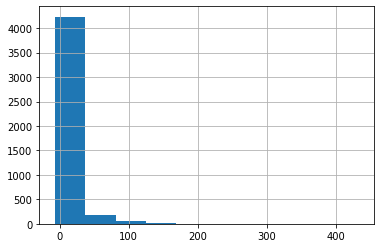

In [ ]:
sub_df_answers['Score_x'].hist()

In [ ]:
sub_df_answers['Score_x'].std()

23.973775770098378

In [ ]:
sub_df_answers = sub_df_answers.loc[sub_df_answers['Score_x'] >= sub_df_answers['Score_x'].std()]

In [ ]:
sub_df_answers

,PostId_y,Body_y,Score_x,OwnerUserId_y
14960,218394,In order to define what a service's responsibi...,433,3249
4805,102215,\n This is an old answer.\n See UTF-8 Everyw...,432,35174
4798,102118,Modern day startups need to hit the market as ...,391,10097
168,6303,"Sorry, this is going to be long, but it's base...",312,3340
633,18459,I prefer the second style. Get invalid cases ...,302,935
...,...,...,...,...
14836,215915,Note that IDEA has this inspection for Java as...,24,31260
11821,185643,"The general answer is no, because you should n...",24,11982
24853,329830,Very general philosophical reasoning\n\nTypica...,24,39877
349,11229,Cormen's Introduction to Algorithms is a good ...,24,2550


In [ ]:
def execute_acc_ans_parsing(dir_path, start_idx, end_idx, answer_df):
  print(f"Processing \"{end_idx - start_idx}\" answers ...")
  
  if not os.path.exists(dir_path):
      os.mkdir(dir_path)
      time.sleep(5)
  
  # print(dir_path + str(user_id))

  local_user_df = answer_df.loc[:, ['PostId_y', 'Body_y']]
  # print(local_user_df)

  local_dict = dict(zip(list(local_user_df['PostId_y'].astype(str)), list(local_user_df['Body_y'])))
  user_preprocessing.preproces_questions_into_tokens(local_dict)
  
  post_list = user_preprocessing.get_list_of_posts(local_dict)

  for key in tqdm.tqdm(post_list[start_idx:end_idx]):
          dpm.parse_section(local_dict[key], key, dpm.basic_pos_relations, dir_path)


  # with multiprocessing.Pool(multiprocessing.cpu_count()) as exec:
  #   sub_post_list = [post_list[n:n+4] for n in range(0, len(post_list), 4)]
  #   for sub_post in tqdm.tqdm(sub_post_list):
        # args = [(local_dict[key], key, dpm.basic_pos_relations, dir_path) for key in sub_post]
        # print(args[0])
        # exec.starmap(dpm.parse_section, args)
        
        #   # print(f"key is : {key}")
        #   # print(local_dict[key])
        #   # print(dpm.basic_pos_relations)
        #   # exec.submit(dpm.parse_section, *(local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)))  
        #   p = multiprocessing.Process(target=dpm.parse_section, args=[local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)]) 
        #   p.start()
        #   processes.append(p)
        # for process in processes:
        #     process.join()          
                      

In [ ]:
# execute_acc_ans_parsing("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", 5, len(sub_df_answers), sub_df_answers)

## Model evaluation - jls8

### Loading the models

In [114]:
from parsing.model_evaluation import loading_models, metrics, ploting, model_processing_utils

In [115]:
# sections_book_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters") } 
sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/jls8/acm_chapters", num_of_files_to_read="all")
user_dict = loading_models.get_user_dict_from_file(r"D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers")
user_rep = loading_models.get_user_reputation_dict_from_file(r"D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\reputation\user_reputation.txt")
# acc_ans_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers") } 

100%|██████████| 181/181 [00:02<00:00, 75.45it/s]


In [116]:
len(user_dict)

173

Filtering out the values not contained in the z_user_score_list

In [117]:
z_user_score_dict1 = loading_models.get_q_a_dict_from_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores\z_scores2.txt")
z_user_score_list = list(z_user_score_dict1.keys())
user_dict = { key : val for key, val in user_dict.items() if int(key.split("userId")[1]) in z_user_score_list}
z_user_score_dict1 = { key : val for key, val in z_user_score_dict1.items() if f"userId{key}" in list(user_dict.keys())}

In [118]:
# len(z_user_score_dict1)

In [119]:
# user_preprocessing.save_dict_to_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores", "z_scores3.txt", z_user_score_dict1)

In [120]:
print(f"num of user models: {len(user_dict)}, num of user reps: {len(user_rep)}")

num of user models: 114, num of user reps: 13085


Define dataframe for storing results:

In [121]:
models = {}
indexes = ['order accuracy', 'max deviation', 'mean deviation', 'total deviation']

In [122]:
result_dict1 = {
        'phrases_jacc'   : [],
        'phrases_cos'    : [],
        'phrases_euclid' : [],
        'words_jacc'   : [],
        'words_cos'    : [],
        'words_euclid' : []
}

### Basic model testing #1

#### Phrases

Jaccard similarity

In [123]:
model_processing_utils.join_tuples_and_lemantize(user_dict)
model_processing_utils.join_tuples_and_lemantize(sections_book_dict)
merged_book = model_processing_utils.merge_models(sections_book_dict)

present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
len(present_user_rep)

100%|██████████| 19/19 [00:00<?, ?it/s]


114

Calculating the metric score

In [124]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict[key]) for key in user_dict.keys()}

In [125]:
%%capture
phrases_overal_jacq_sim

In [126]:
# normalizing the score 
# phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

In [127]:
phrases_overal_jacq_sim['userId1352']

2.70076

In [128]:
# Reputation:
# 'userId611': 21854, 'userId2314': 27571, 'userId3249': 42615, 'userId14221': 45837, 'userId1352': 95315
# Jaccard:
# 'userId16349': 0.36975, 'userId611': 0.63611, 'userId2314': 0.82183, 'userId90149': 1.10006, 'userId14221': 1.36162, 'userId3249': 1.5441, 'userId1352': 2.70076

    

In [129]:
def calculate_file_size(dir_path):
    files = os.listdir(dir_path)
    files_size = sum(os.stat(os.path.join(dir_path, f)).st_size for f in files)
    return files_size


# using the dictionary create a dataframe and for each user/dir calculate the size of files, sort it and display the df
def get_sorted_file_list_by_size(metric_dict1, root_path):
    df = pd.DataFrame(list(metric_dict1.items()), columns=['UserID', 'Metric score'])
    df['file_size'] = df.apply(lambda x: calculate_file_size(os.path.join(root_path, str(x['UserID']))), axis=1)
    df = df.sort_values(by=['file_size'], ascending=False)
    return df
    

In [130]:
from parsing.model_evaluation.metrics import get_sorted_dicts, calculate_order_score, calculate_max_deviation, calculate_mean_deviation, calculate_total_deviation

In [131]:
expert_user = present_user_rep.pop('userId1352')
phrase_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')

In [132]:
expert_user

95315

In [133]:
get_corr_coef = lambda user_expert, metric_expert: ((user_expert/95315)*100)/metric_expert

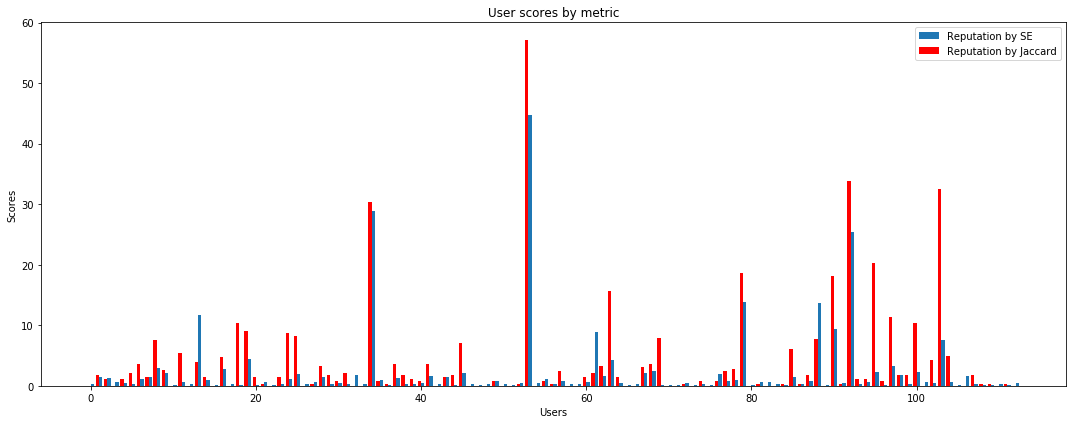

In [134]:
# corr_coef = ((expert_user/95315) * 100)/phrase_jacc_expert
corr_coef = get_corr_coef(expert_user, phrase_jacc_expert)


# phrases_overal_jacq_sim.pop("userId1352")
# present_user_rep.pop("userId1352")

scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in phrases_overal_jacq_sim}

ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard")

In [135]:
import matplotlib.pyplot as plt

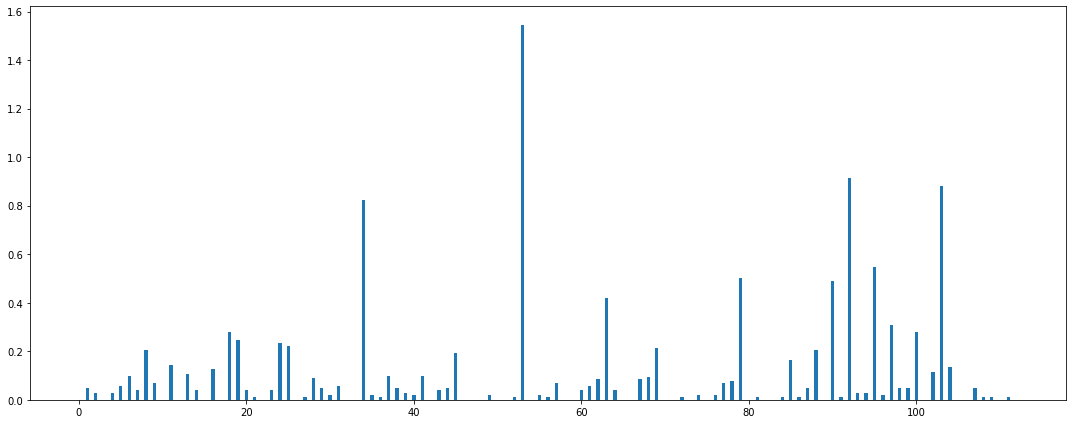

In [136]:
plt.rcParams['figure.figsize'] = [15, 6]
  # plt.style.use('ggplot')
plt.rcParams["figure.autolayout"] = True
  
labels = [str(i+1) for i in range(0, len(phrases_overal_jacq_sim.keys()))]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x, phrases_overal_jacq_sim.values(), width, label= "metric_name1", align="center")

plt.show()

In [137]:
# scaled_user_rep

In [138]:
# phrases_overal_jacq_sim

In [139]:
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, scale_coef=corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

In [140]:
metrics.jaccard_similarity(user_dict['userId3249'], merged_book)

1.5441

In [141]:
present_user_rep['userId3249']

42615

In [142]:
(present_user_rep['userId3249']/95315)*100

44.70964696007974

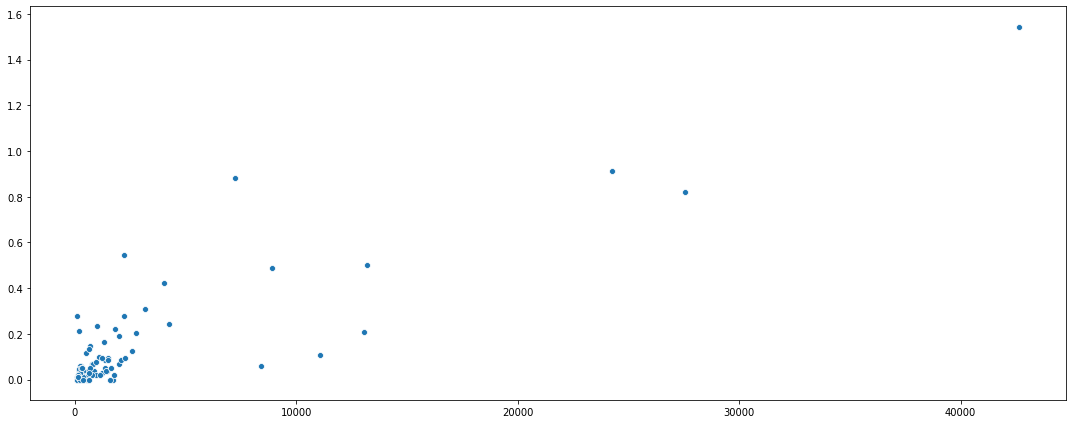

In [143]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [144]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho[0][1])

0.8733385629227722


Evaluation of order score, max deviation order, mean deviation order, individual order and reputation differences

In [145]:
# Z score
# 1352: 28.896449047944508,
# 79256: 7.216053531635459,
# 8500: 6.563924617405255,
# 1813: 4.458963213705229,
# 66: 4.458892287340829,
# 3922: 4.426352063787131,
# 24912: 4.024922359499621,
# 91249: 2.5298221281347035,
# 82: 2.523573072576179,

Checking if our model isnt biased by the size of user models

In [146]:
df = get_sorted_file_list_by_size(phrases_overal_jacq_sim, "D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\answers")

In [147]:
df.head(20)

,UserID,Metric score,file_size
53,userId3249,1.54410,192201
92,userId7167,0.91237,110915
90,userId7080,0.48765,79009
34,userId2314,0.82183,70386
103,userId90992,0.87977,54876
79,userId5692,0.50197,51428
100,userId8500,0.27983,26354
88,userId66,0.20685,26119
97,userId79256,0.30895,25411
63,userId39690,0.42109,22454


Doesnt look like it - first 3 positions match but the rest not 

Cosine similarity

In [148]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, merged_book)

In [149]:
phrases_overal_cos_sim.values()

dict_values([0.0, 0.45833, 0.6491, 0.0, 0.38725, 0.54999, 0.78632, 0.35332, 0.84715, 0.74411, 0.0, 1.16492, 0.0, 0.66499, 0.26208, 5.73254, 0.0, 1.13487, 0.0, 1.23939, 1.22205, 0.58476, 0.13019, 0.0, 0.49575, 1.09547, 0.90921, 0.0, 0.14948, 0.95126, 0.55777, 0.62709, 0.69156, 0.0, 0.0, 2.08419, 0.24788, 0.15877, 0.66848, 0.61491, 0.32455, 0.21637, 0.68915, 0.0, 0.49193, 0.37801, 1.2669, 0.0, 0.0, 0.0, 0.3889, 0.0, 0.0, 0.12492, 3.15918, 0.0, 0.45494, 0.40478, 0.59957, 0.0, 0.0, 0.35616, 0.48737, 0.62786, 1.62683, 1.25417, 0.0, 0.0, 0.45898, 0.5315, 1.71912, 0.0, 0.0, 0.275, 0.0, 0.28925, 0.0, 0.32601, 0.71209, 0.52417, 1.39794, 0.0, 0.7011, 0.0, 0.0, 0.2337, 1.5387, 0.14022, 0.46637, 0.73717, 0.0, 1.18621, 0.11936, 2.01731, 0.38401, 0.33898, 2.25665, 0.36205, 1.15156, 0.50336, 0.46432, 1.01117, 0.0, 1.01652, 2.43566, 0.90938, 0.0, 0.0, 0.75602, 0.24048, 0.163, 0.0, 0.18738, 0.0])

In [150]:
phrase_cos_expert = phrases_overal_cos_sim.pop('userId1352')

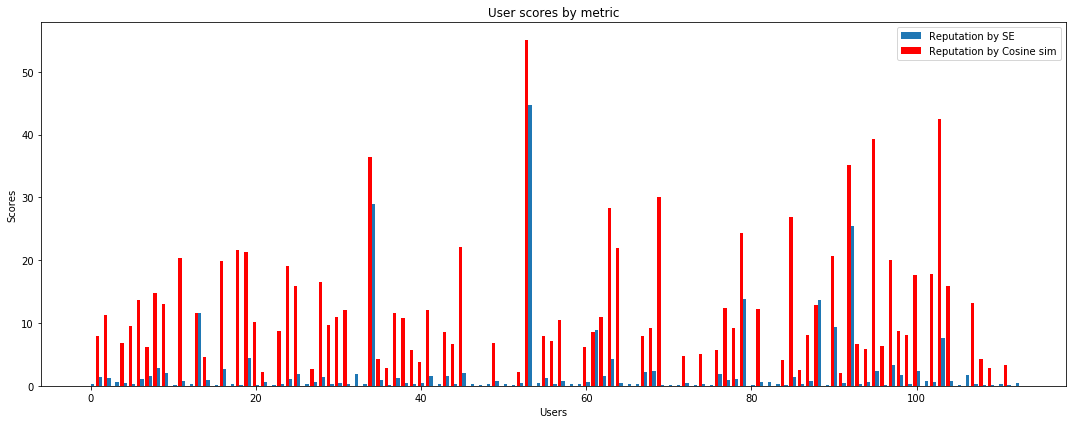

In [151]:
# normalizing the score 
# phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)

# corr_coef2 = ((expert_user/95315) * 100)/phrase_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrase_cos_expert)

# corr_coef2 = present_user_rep['userId1352']/phrases_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

In [152]:
# scaled_user_rep2

In [153]:
# scaled_cos_rep

In [154]:
phrases_overal_cos_sim['userId3249']*corr_coef2

55.10960237521239

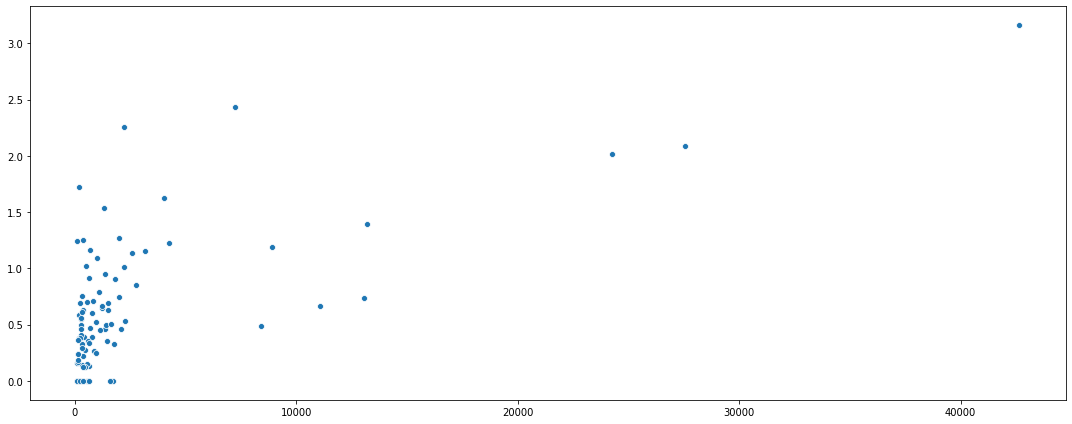

In [155]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [156]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.65588313]
 [0.65588313 1.        ]]


In [157]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

In [158]:
phrases_overal_jacq_sim['userId43880']

0.0

In [159]:
(present_user_rep['userId43880']/95315)*100

0.25284582699470176

Euclidean distance

In [160]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, merged_book)

In [161]:
# normalizing the score 
phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

In [162]:
phrases_overal_euclid_sim['userId1352']

1.0

In [163]:
metrics.euclid_dis(user_dict['userId1352'], merged_book)

164.83931569865243

In [164]:
1 / (1 + metrics.euclid_dis(user_dict['userId1352'], merged_book))

0.0060299332265522955

In [165]:
# phrase_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')

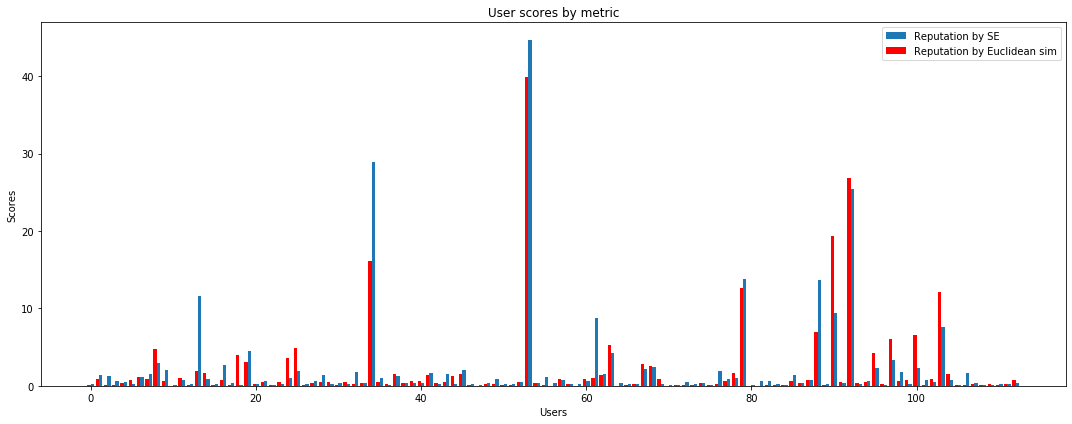

In [166]:
phrase_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')

# corr_coef3 = ((expert_user/95315)*100) / phrase_euclid_expert
corr_coef3 = get_corr_coef(expert_user, phrase_euclid_expert)

# corr_coef3 = present_user_rep['userId1352']/phrases_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

In [167]:
corr_coef3

100.0

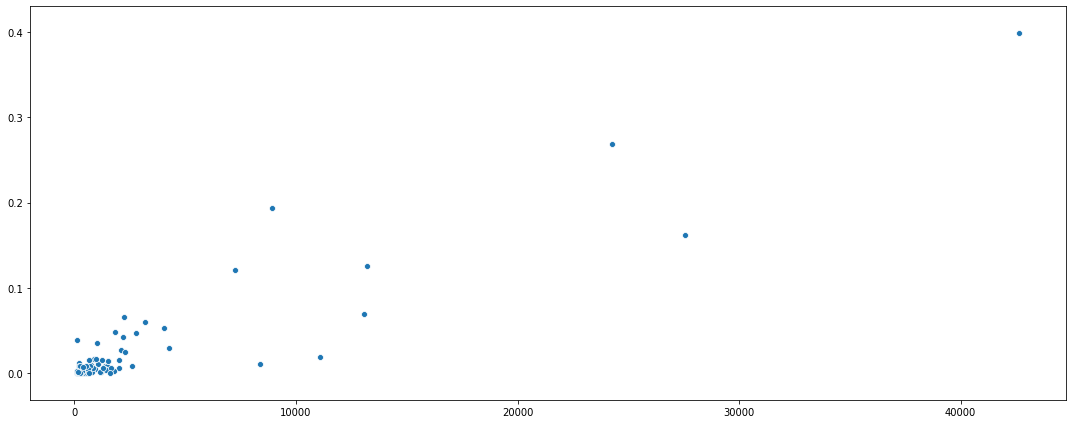

In [168]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [169]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91863172]
 [0.91863172 1.        ]]


In [170]:
phrases_overal_euclid_sim['userId3249']

0.39885743826947767

In [171]:
present_user_rep['userId3249']

42615

In [172]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Combined metrics

In [173]:
combined = {key : phrases_overal_jacq_sim[key] * phrases_overal_cos_sim[key] * phrases_overal_euclid_sim[key] for key in phrases_overal_jacq_sim.keys()}

# normalizing the score 
# combined = metrics.min_max_normalize(combined)

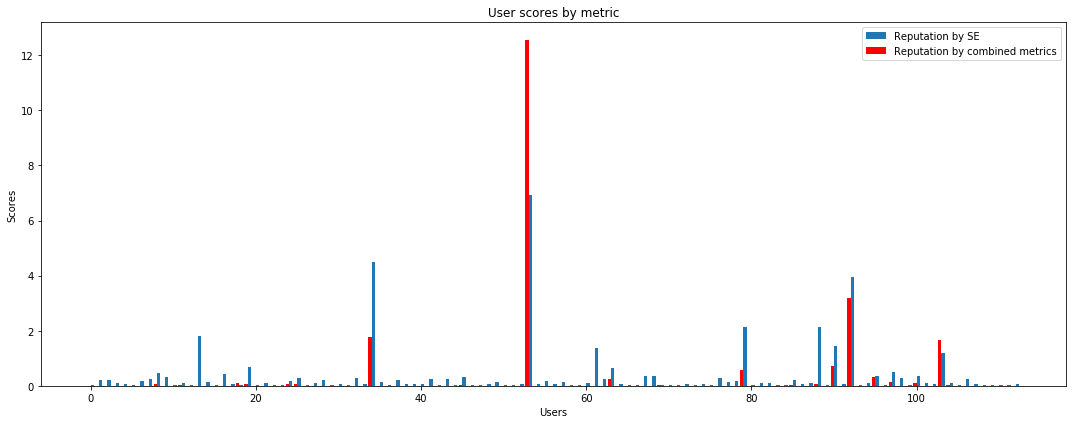

In [174]:
phrase_combined_expert = phrase_euclid_expert * phrase_cos_expert * phrase_jacc_expert

# corr_coef3 = ((expert_user/95315)*100)/phrase_combined_expert
corr_coef3 = get_corr_coef(expert_user, phrase_combined_expert)


# corr_coef3 = present_user_rep['userId1352']/combined['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100)/corr_coef3 for key in present_user_rep}
scaled_combined_rep = {key : combined[key]*corr_coef3 for key in combined}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_combined_rep, metric_name1="Reputation by SE", metric_name2="Reputation by combined metrics")

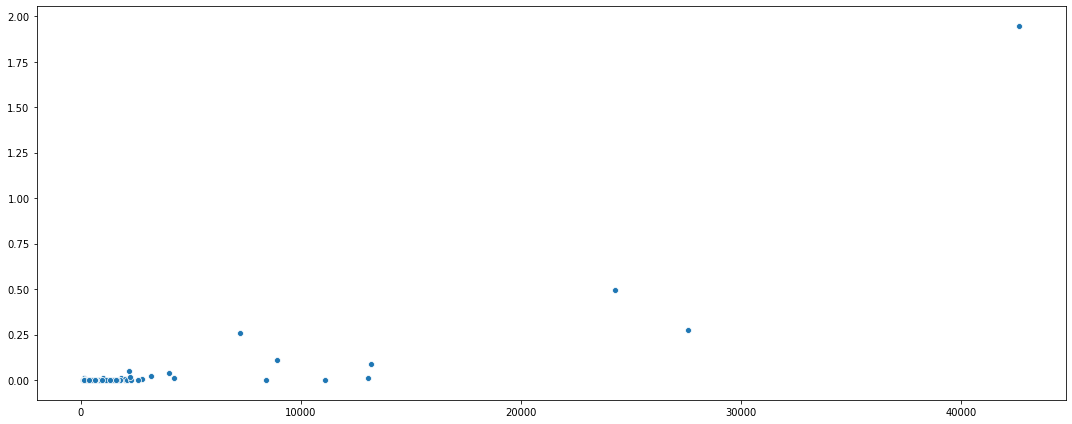

In [175]:
np_combined_sim = np.array(list(combined.values()))

sb.scatterplot(np_user_rep, np_combined_sim)

In [176]:
my_rho = np.corrcoef(np_user_rep, np_combined_sim)
print(my_rho)

[[1.         0.83937213]
 [0.83937213 1.        ]]


In [177]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(combined, present_user_rep))
print(calculate_max_deviation(combined, present_user_rep))
print(calculate_mean_deviation(combined, present_user_rep))
print(calculate_total_deviation(combined, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [178]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
merged_book = model_processing_utils.join_phrases_into_words(merged_book)

100%|██████████| 114/114 [00:01<00:00, 59.25it/s]


In [179]:
len(user_dict_words['userId11200'])

252

In [180]:
len(merged_book)

20344

Jaccard similarity

In [181]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

In [182]:
words_overal_jacq_sim['userId1352']

2.37444

In [183]:
words_jacc_expert = words_overal_jacq_sim.pop('userId1352')

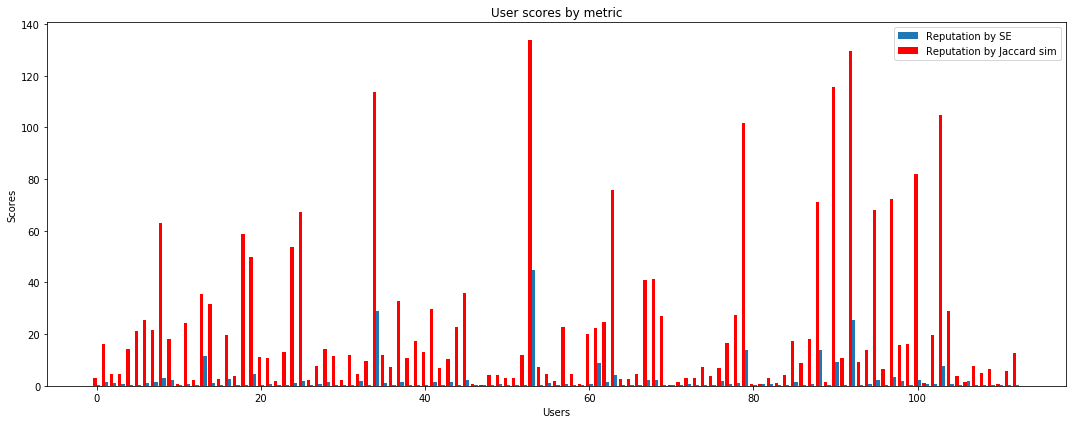

In [184]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)

# corr_coef = ((expert_user/95315) * 100) / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef = present_user_rep['userId1352']/words_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

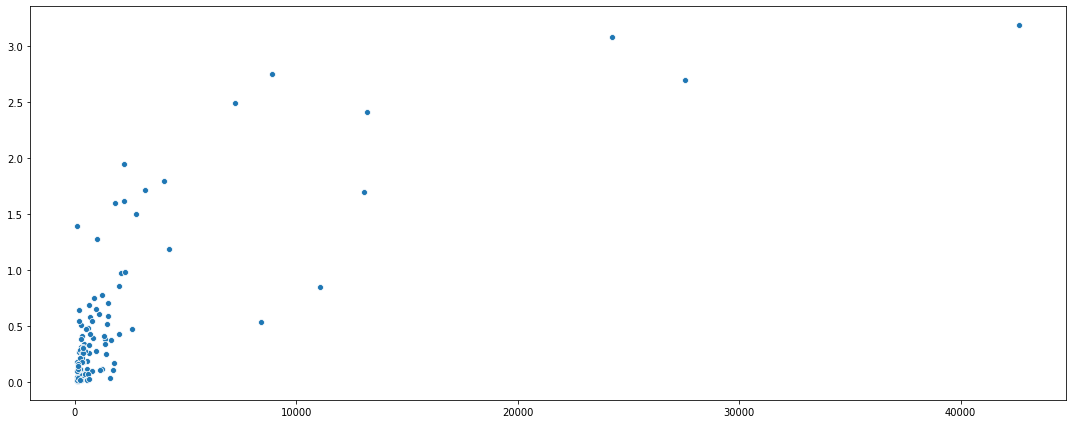

In [185]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [186]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.76009036]
 [0.76009036 1.        ]]


In [187]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [188]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, merged_book)

In [189]:
# normalizing the score 
# words_overal_cos_sim = metrics.min_max_normalize(words_overal_cos_sim)
words_cos_expert = words_overal_cos_sim.pop('userId1352')

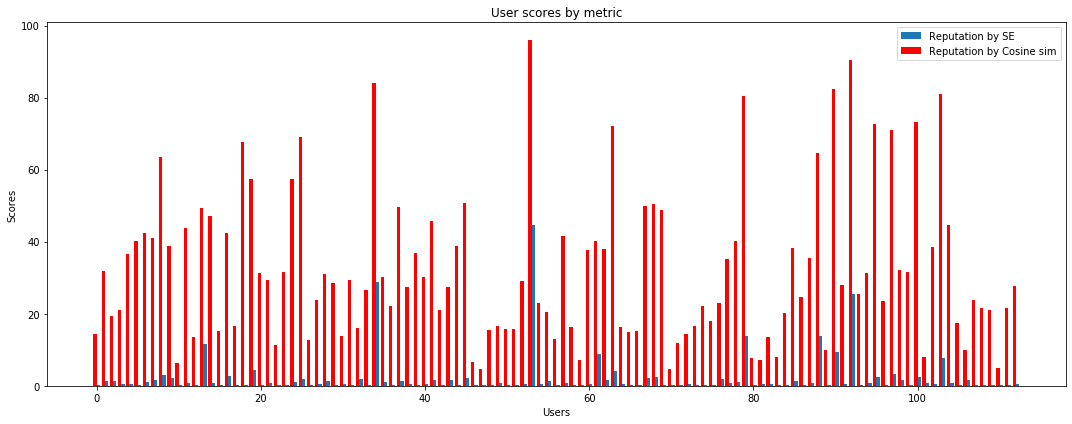

In [190]:
# corr_coef2 = ((expert_user/95315)*100) / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/words_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : words_overal_cos_sim[key]*corr_coef2 for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

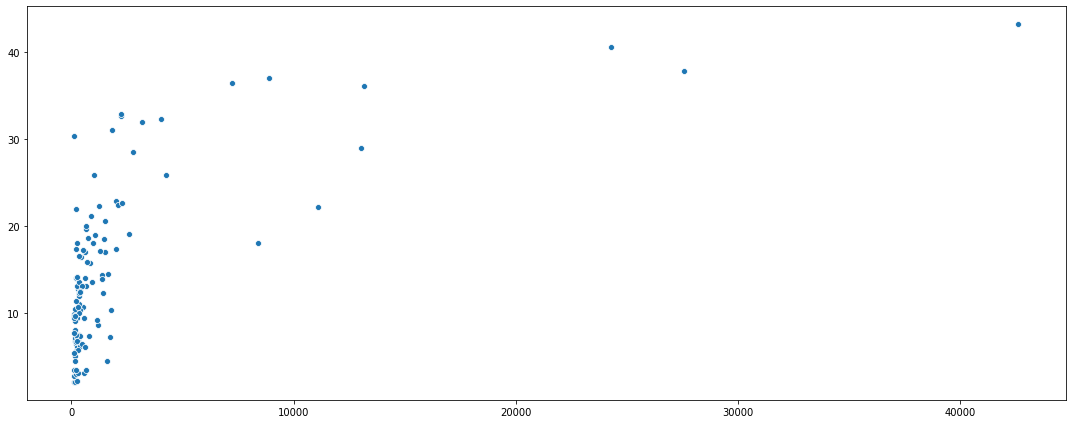

In [191]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [192]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.63553721]
 [0.63553721 1.        ]]


In [193]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [194]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, merged_book)

In [195]:
# normalizing the score 
words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

words_euclid_expert = words_overal_euclid_sim.pop('userId1352')

In [196]:
words_euclid_expert

1.0

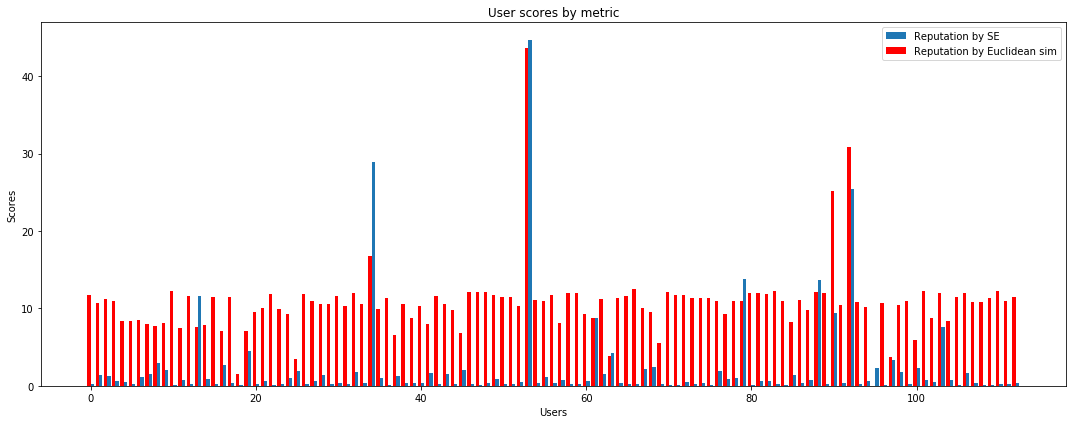

In [197]:
# corr_coef3 = ((expert_user/95315)*100) / words_euclid_expert
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

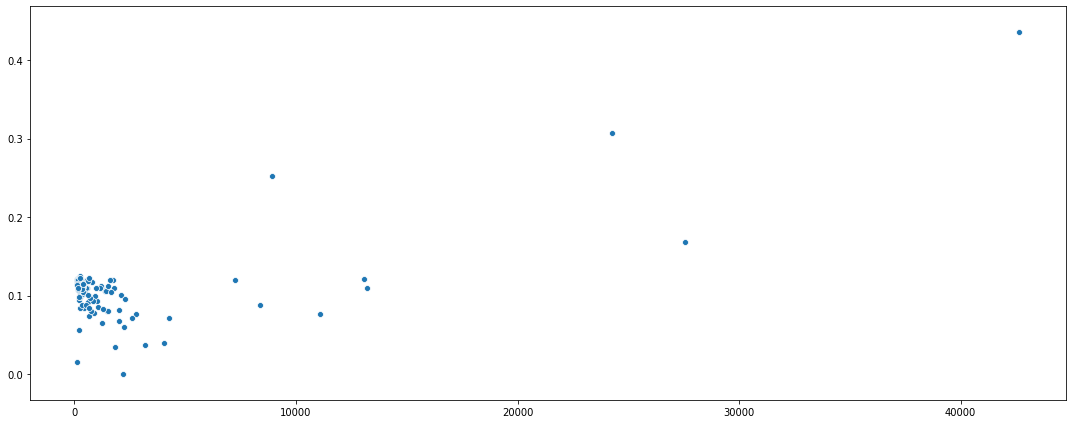

In [198]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [199]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[1.         0.69545788]
 [0.69545788 1.        ]]


In [200]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Combined

In [201]:
combined_words = {key : words_overal_jacq_sim[key] * words_overal_cos_sim[key] * words_overal_euclid_sim[key] for key in words_overal_jacq_sim.keys()}

In [202]:
# normalizing the score 
# combined_words = metrics.min_max_normalize(combined_words)

words_combined_expert = words_cos_expert * words_euclid_expert * words_jacc_expert

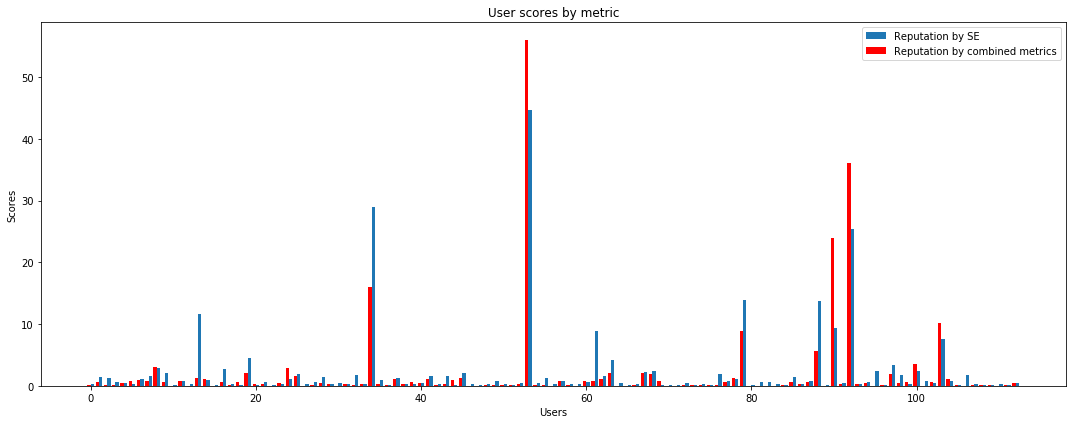

In [203]:
# corr_coef3 = ((expert_user/95315)*100) / words_combined_expert
corr_coef3 = get_corr_coef(expert_user, words_combined_expert)


# corr_coef3 = present_user_rep['userId1352']/combined_words['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_combined_rep = {key : combined_words[key]*corr_coef3 for key in combined_words}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_combined_rep, metric_name1="Reputation by SE", metric_name2="Reputation by combined metrics")

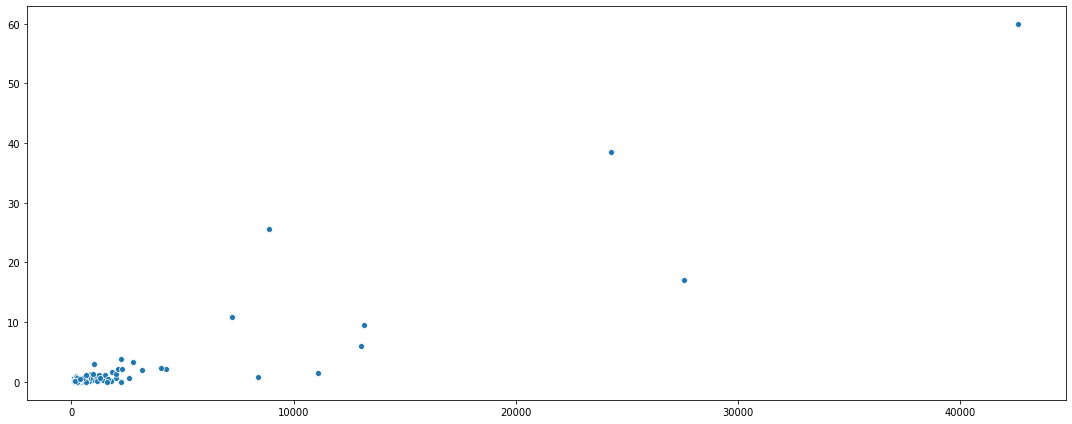

In [204]:
np_words_combined_sim = np.array(list(combined_words.values()))

sb.scatterplot(np_user_rep, np_words_combined_sim)

In [205]:
my_rho = np.corrcoef(np_user_rep, np_words_combined_sim)
print(my_rho)

[[1.         0.90695973]
 [0.90695973 1.        ]]


In [206]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(combined_words, present_user_rep))
print(calculate_max_deviation(combined_words, present_user_rep))
print(calculate_mean_deviation(combined_words, present_user_rep))
print(calculate_total_deviation(combined_words, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

### Enriched model (accepted answers) testing #2

In [207]:
acc_ans_dict = loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", num_of_files_to_read=453)
model_processing_utils.join_tuples_and_lemantize(acc_ans_dict)
merged_book = model_processing_utils.merge_models(sections_book_dict)
merged_answers = model_processing_utils.merge_models(acc_ans_dict)

100%|██████████| 453/453 [00:00<00:00, 452277.96it/s]


In [208]:
len(merged_answers)

8760

In [209]:
len(merged_book)

10172

In [210]:
enriched_merged_book = model_processing_utils.merge_into_existing_model(merged_book, merged_answers)

In [211]:
len(enriched_merged_book)

18570

#### Phrases

Jaccard similarity

In [212]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict[key]) for key in user_dict.keys()}

In [213]:
phrases_overal_jacq_sim['userId3249']

2.88908

In [214]:
# normalizing the score 
# phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

phrases_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')

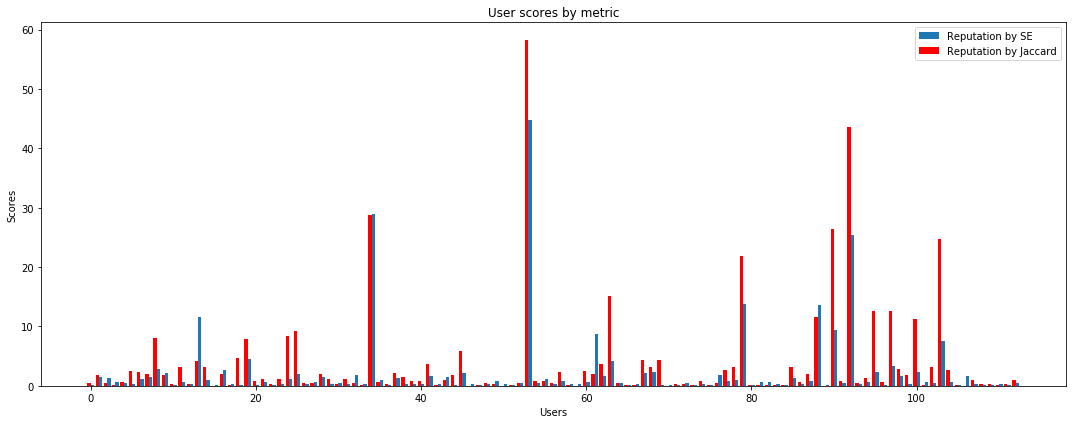

In [215]:
# corr_coef = ((expert_user/95315)*100) / phrases_jacc_expert
corr_coef = get_corr_coef(expert_user, phrases_jacc_expert)


# corr_coef = present_user_rep['userId1352']/phrases_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in phrases_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard")

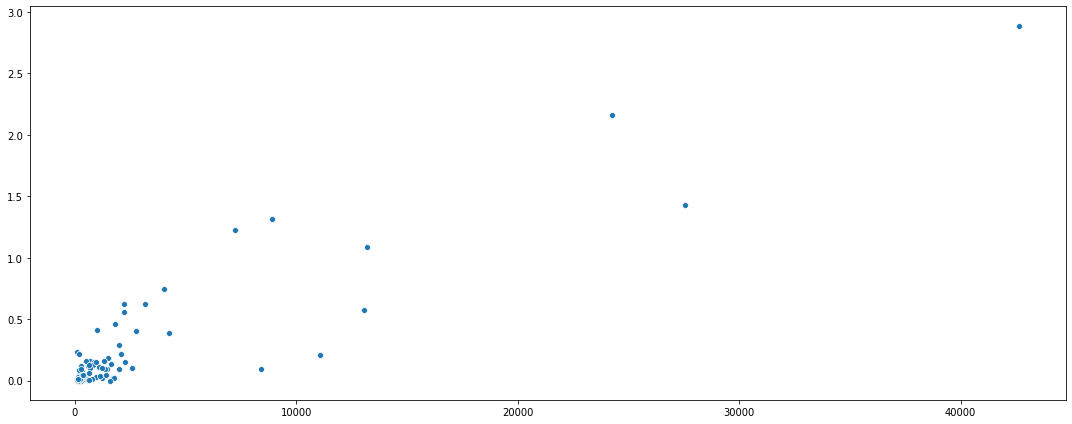

In [216]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [217]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.         0.90831082]
 [0.90831082 1.        ]]


In [218]:
# calculate_order_score(phrases_overal_jacq_sim, present_user_rep)
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [219]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, enriched_merged_book)

In [220]:
# normalizing the score 
# phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)

phrases_cos_expert = phrases_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert


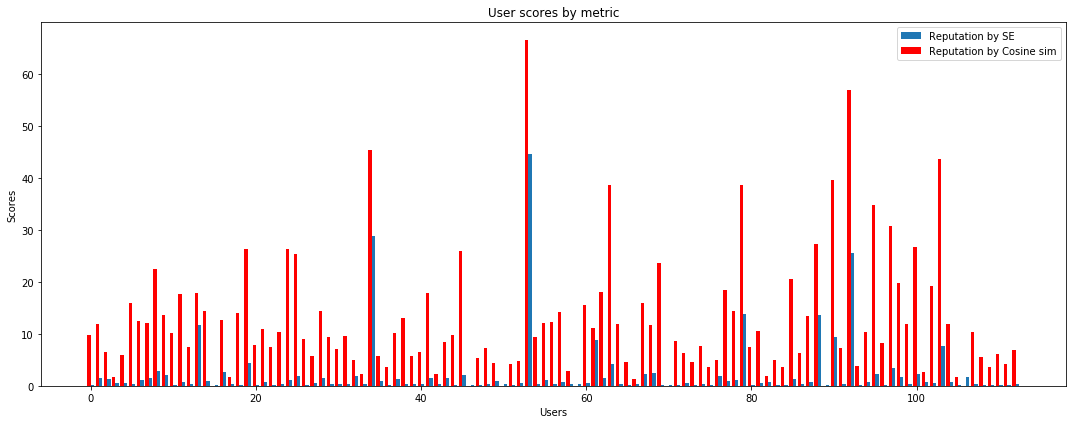

In [221]:
# corr_coef2 = ((expert_user/95315)*100) / phrases_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrases_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/phrases_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

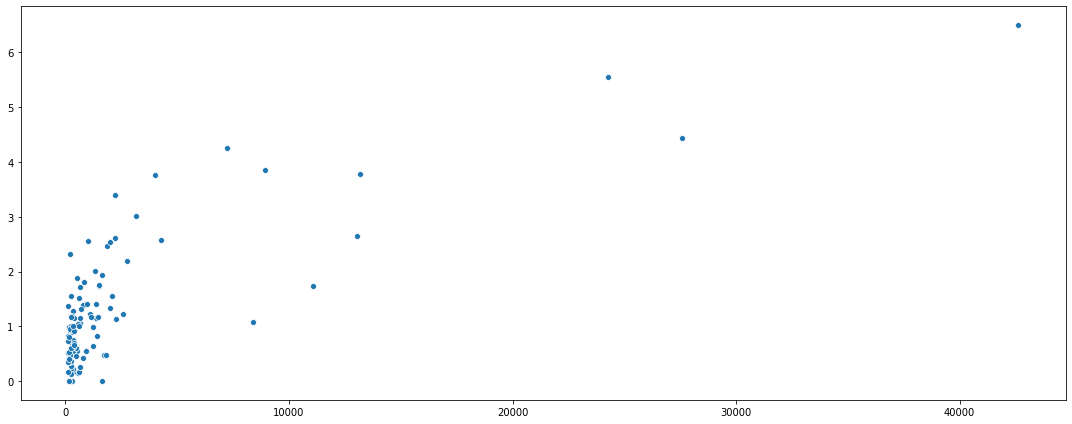

In [222]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [223]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.76796421]
 [0.76796421 1.        ]]


In [224]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [225]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, enriched_merged_book)

In [226]:
# normalizing the score 
phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

phrases_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert


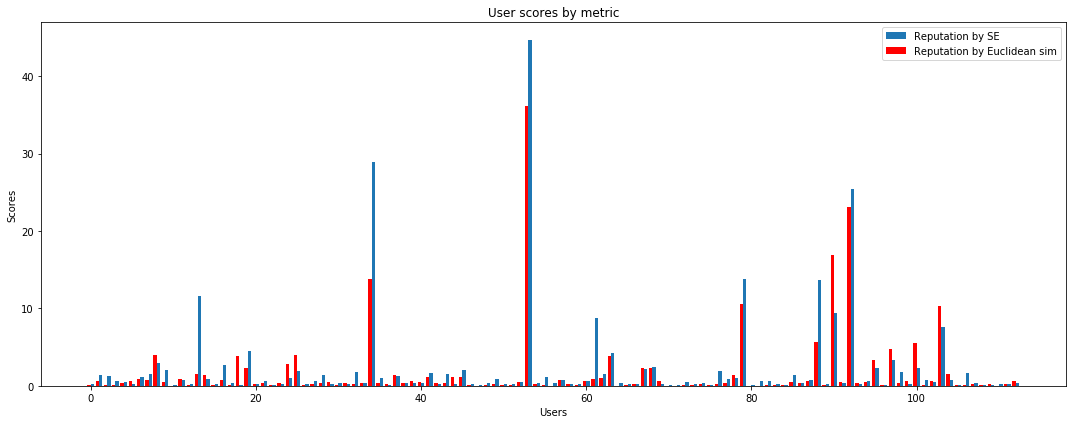

In [227]:
# corr_coef3 = ((expert_user/95315)*100) / phrases_euclid_expert
corr_coef3 = get_corr_coef(expert_user, phrases_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/phrases_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

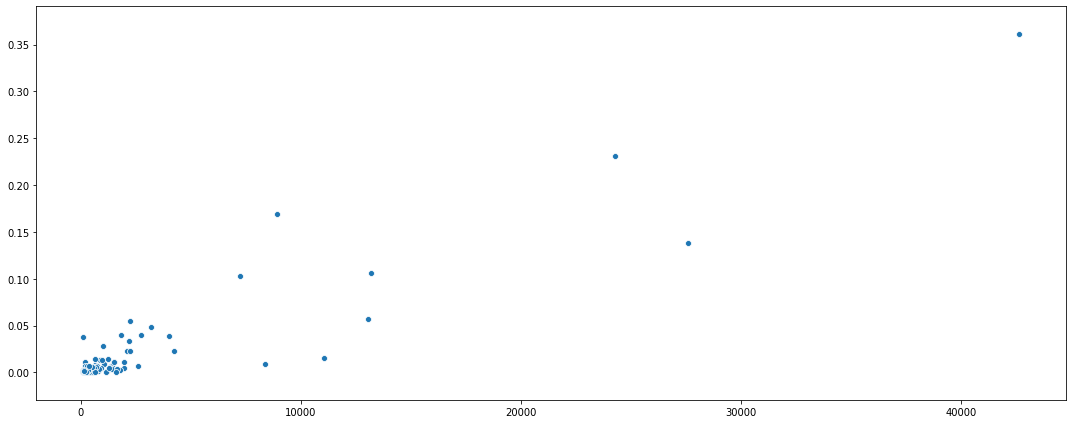

In [228]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [229]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91918824]
 [0.91918824 1.        ]]


In [230]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [231]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
enriched_merged_book = model_processing_utils.join_phrases_into_words(enriched_merged_book)

100%|██████████| 114/114 [00:01<00:00, 59.25it/s]


Jaccard similarity

In [232]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

In [233]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)

words_jacc_expert = words_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

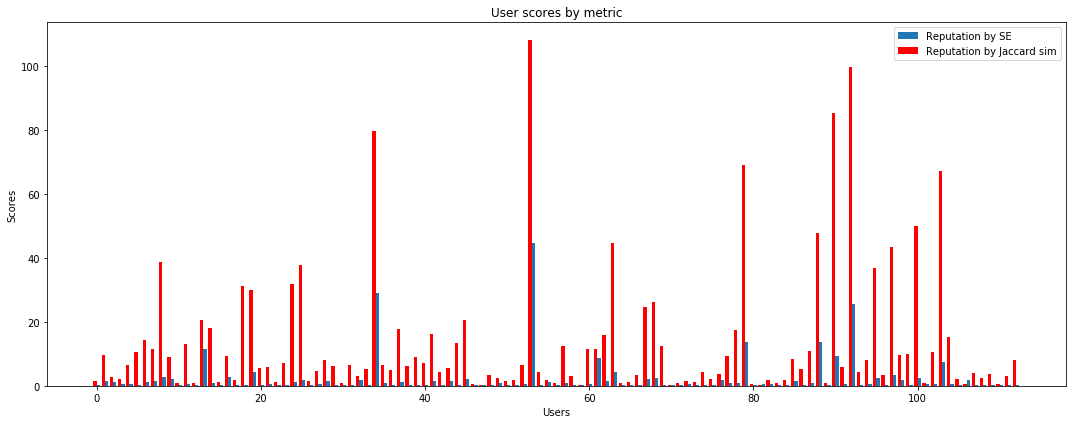

In [234]:
# corr_coef = ((expert_user/95315)*100) / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef = present_user_rep['userId1352']/words_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

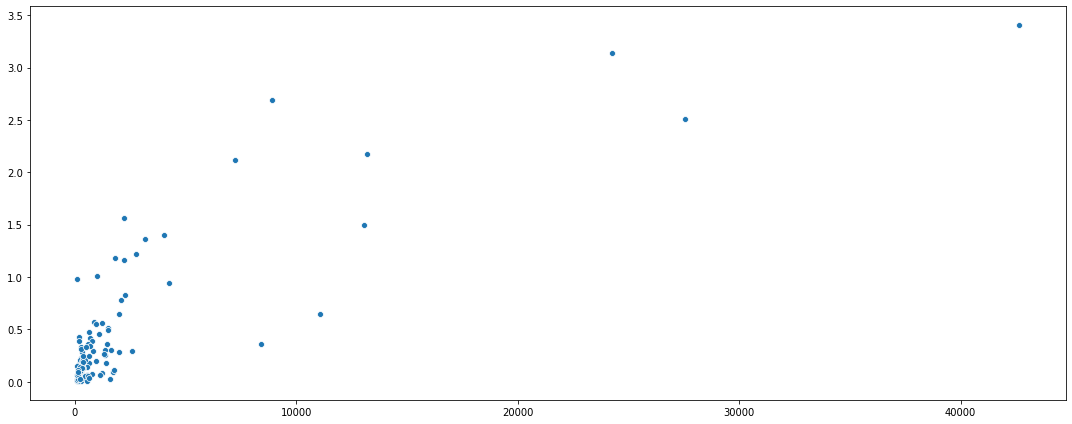

In [235]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [236]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.82382577]
 [0.82382577 1.        ]]


In [237]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [238]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, enriched_merged_book)

In [239]:
# normalizing the score 
# words_overal_cos_sim = metrics.min_max_normalize(words_overal_cos_sim)

words_cos_expert = words_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

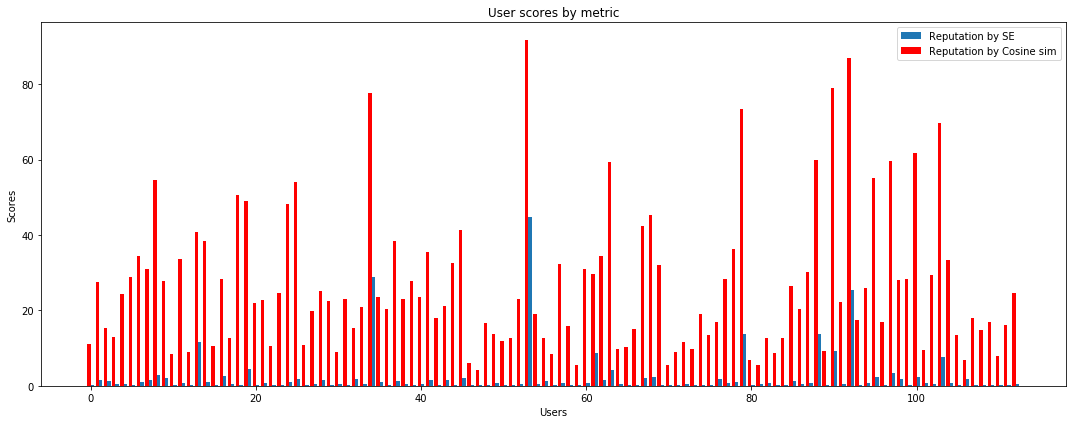

In [240]:
# corr_coef2 = ((expert_user/95315)*100) / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/words_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : words_overal_cos_sim[key]*corr_coef2 for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

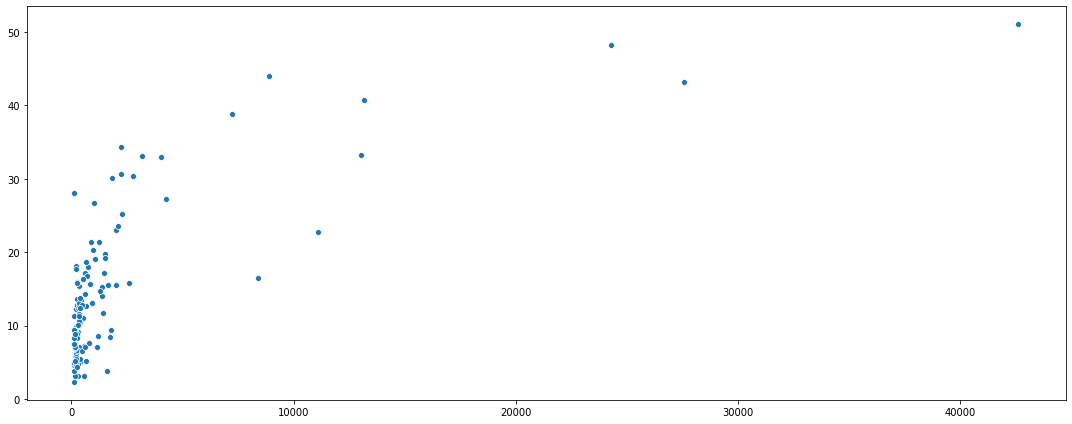

In [241]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [242]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.70304785]
 [0.70304785 1.        ]]


In [243]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [244]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, enriched_merged_book)

In [245]:
# normalizing the score 
# words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

words_euclid_expert = words_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

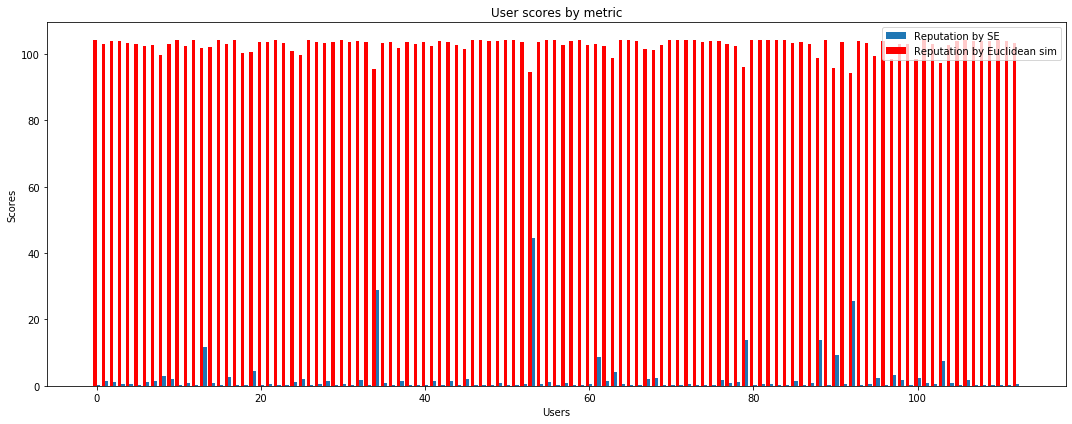

In [246]:
# corr_coef3 = ((expert_user/95315)*100) / words_euclid_expert
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

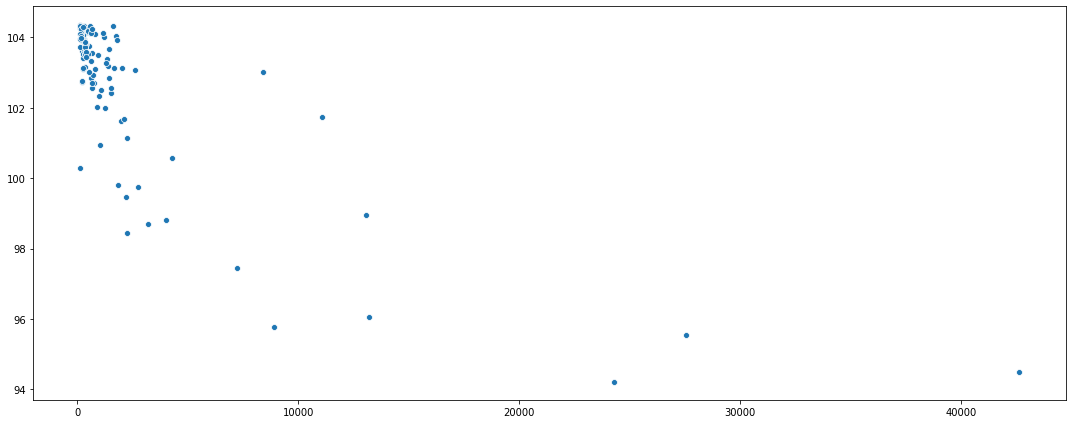

In [247]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [248]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[ 1.         -0.77392566]
 [-0.77392566  1.        ]]


In [249]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

### Enriched model (adding the most expert user) testing #3

In [250]:
merged_book = model_processing_utils.merge_models(sections_book_dict)
user_dict = loading_models.get_user_dict_from_file(r"D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers")

100%|██████████| 181/181 [00:00<00:00, 192.84it/s]


In [251]:
z_user_score_dict1 = loading_models.get_q_a_dict_from_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores\z_scores2.txt")
z_user_score_list = list(z_user_score_dict1.keys())
user_dict = { key : val for key, val in user_dict.items() if int(key.split("userId")[1]) in z_user_score_list}
z_user_score_dict1 = { key : val for key, val in z_user_score_dict1.items() if f"userId{key}" in list(user_dict.keys())}

In [252]:
model_processing_utils.join_tuples_and_lemantize(user_dict)

100%|██████████| 114/114 [00:34<00:00,  3.30it/s]


In [253]:
len(user_dict)

114

In [254]:
expert_to_enrich = user_dict['userId1352']

In [255]:
len(expert_to_enrich)

19793

In [256]:
len(merged_book)

10172

In [257]:
enriched_merged_book = model_processing_utils.merge_into_existing_model(merged_book, expert_to_enrich)

In [258]:
len(enriched_merged_book)

27960

#### Phrases

Jaccard similarity

In [259]:
present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
len(present_user_rep)

114

In [260]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict[key]) for key in user_dict.keys()}

In [261]:
# normalizing the score 
# phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

phrases_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')
present_user_rep.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

95315

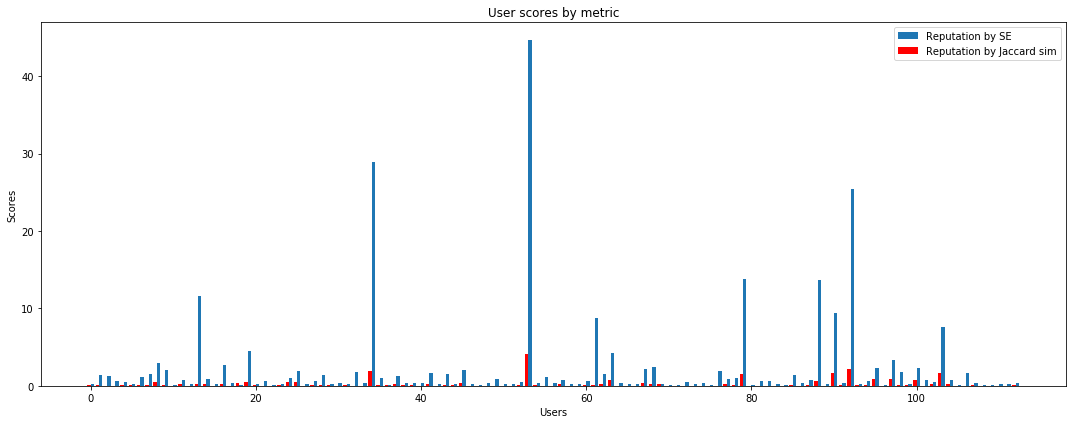

In [262]:
# corr_coef = expert_user / phrases_jacc_expert
corr_coef = get_corr_coef(expert_user, phrases_jacc_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in phrases_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

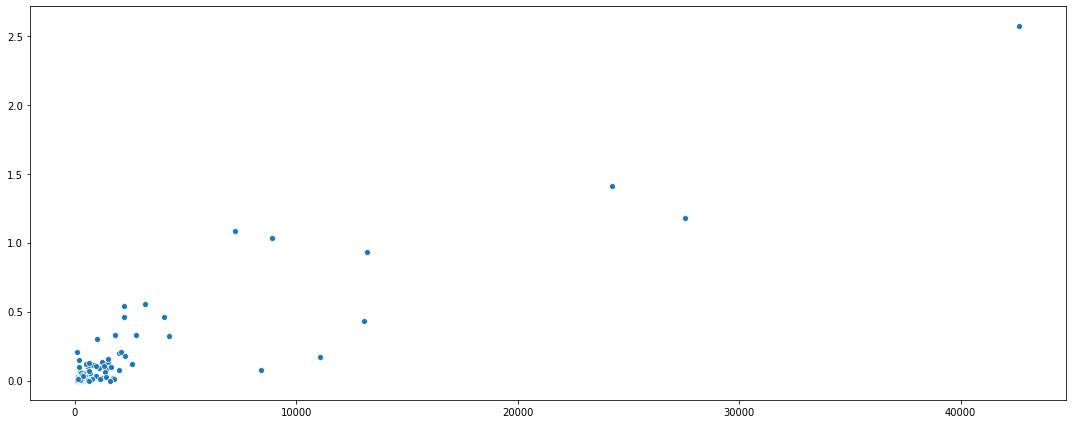

In [263]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [264]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.         0.91306787]
 [0.91306787 1.        ]]


In [265]:
# calculate_order_score(phrases_overal_jacq_sim, present_user_rep)
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, scale_coef=corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [266]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, enriched_merged_book)

In [267]:
# normalizing the score 
# phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)

phrases_cos_expert = phrases_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

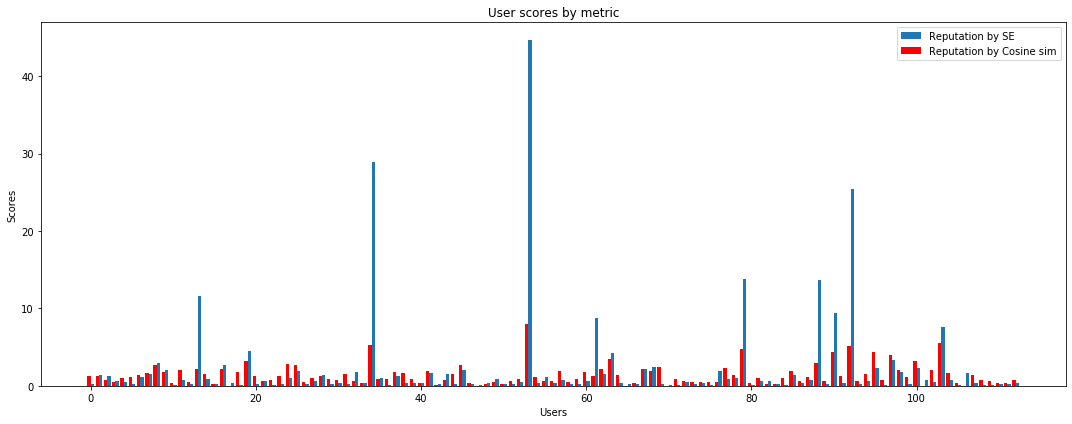

In [268]:
# corr_coef2 = expert_user / phrases_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrases_cos_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

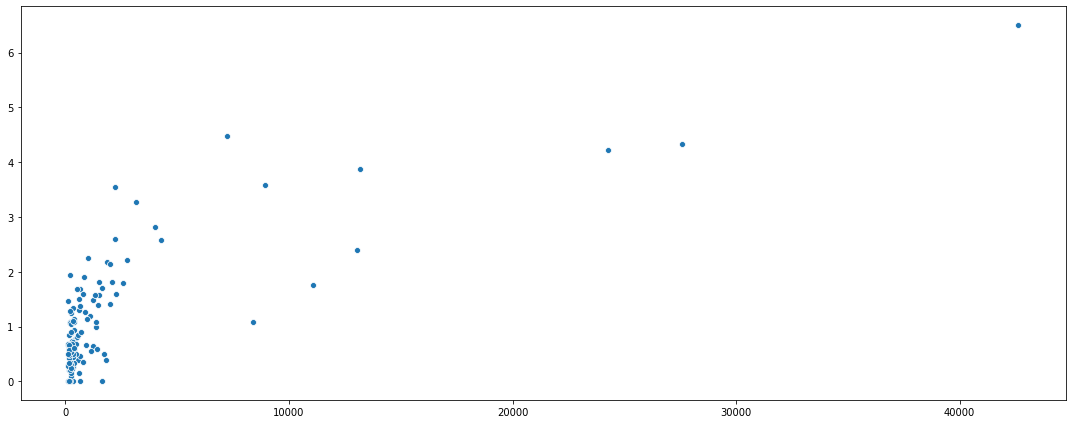

In [269]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [270]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.76207255]
 [0.76207255 1.        ]]


In [271]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, scale_coef=corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [272]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, enriched_merged_book)

In [273]:
phrases_overal_euclid_sim['userId1352']

100.0

In [274]:
# normalizing the score 
# phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

In [275]:
phrases_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

In [276]:
phrases_euclid_expert

100.0

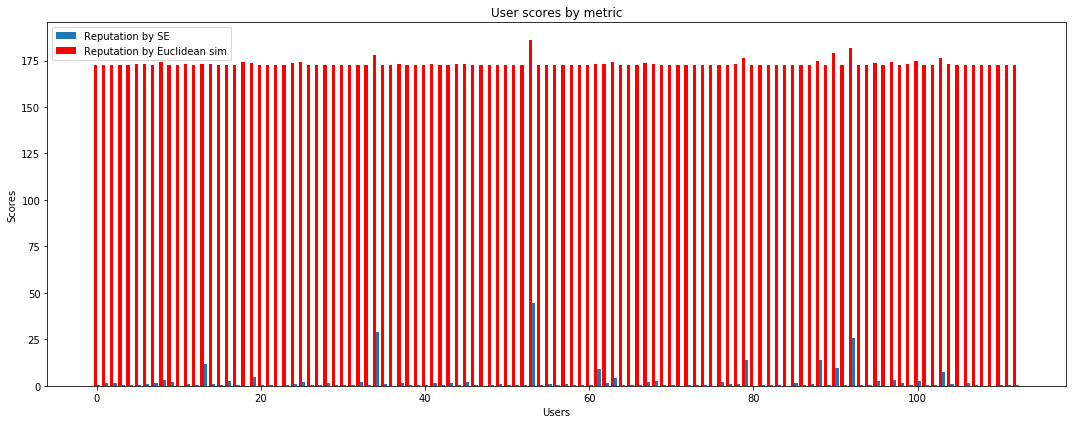

In [277]:
# corr_coef3 = expert_user / (1 + phrases_euclid_expert)

corr_coef3 = get_corr_coef(expert_user, phrases_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

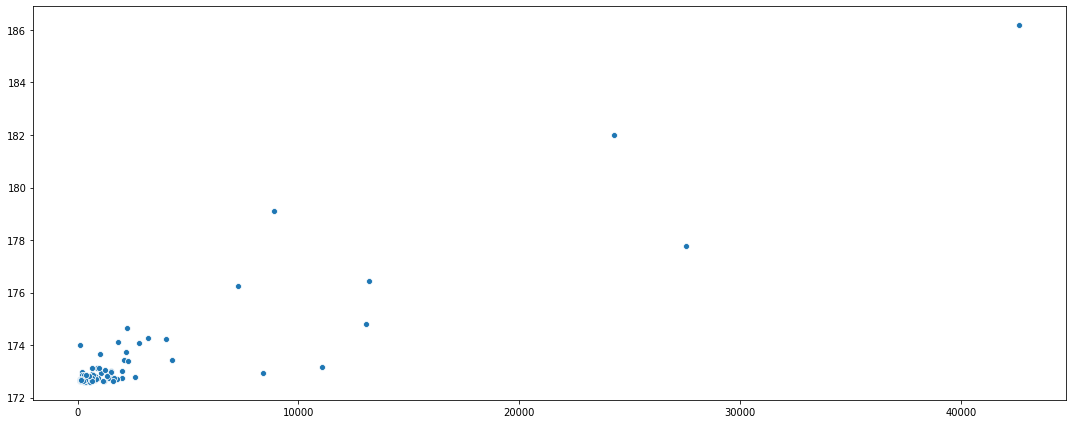

In [278]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [279]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91684339]
 [0.91684339 1.        ]]


In [280]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, scale_coef=corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [281]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
enriched_merged_book = model_processing_utils.join_phrases_into_words(enriched_merged_book)

100%|██████████| 114/114 [00:01<00:00, 58.29it/s]


Jaccard similarity

In [282]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

In [283]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)

words_jacc_expert = words_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

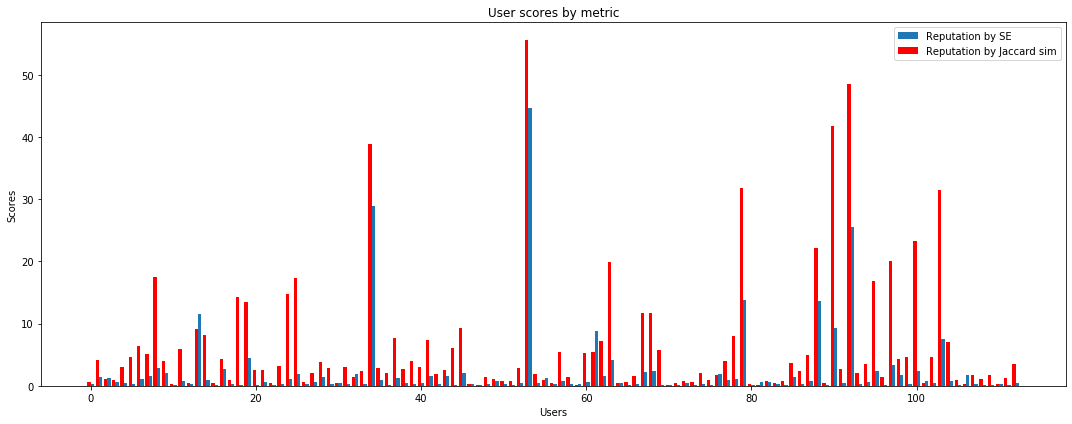

In [284]:
# corr_coef = expert_user / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

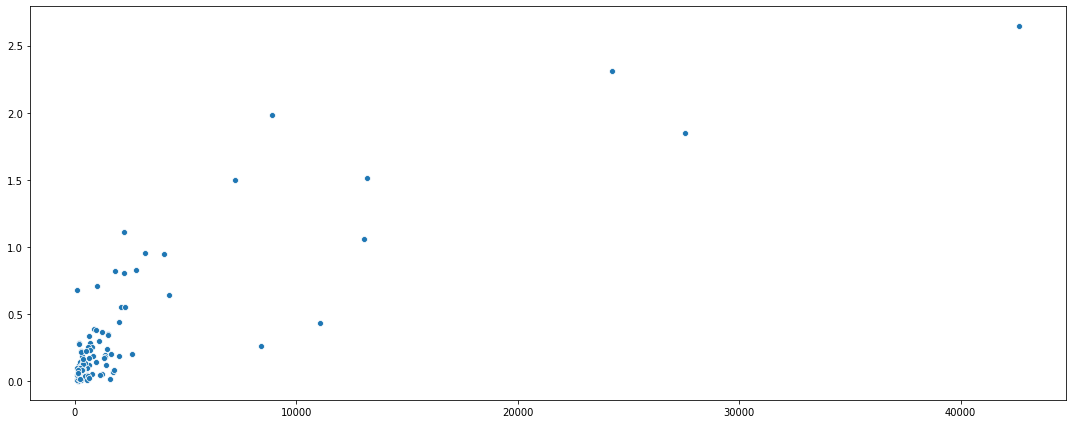

In [285]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [286]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.84264316]
 [0.84264316 1.        ]]


In [287]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, scale_coef=corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [288]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, enriched_merged_book)

In [289]:
# normalizing the score 
# words_overal_cos_sim = metrics.min_max_normalize(words_overal_cos_sim)

words_cos_expert = words_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

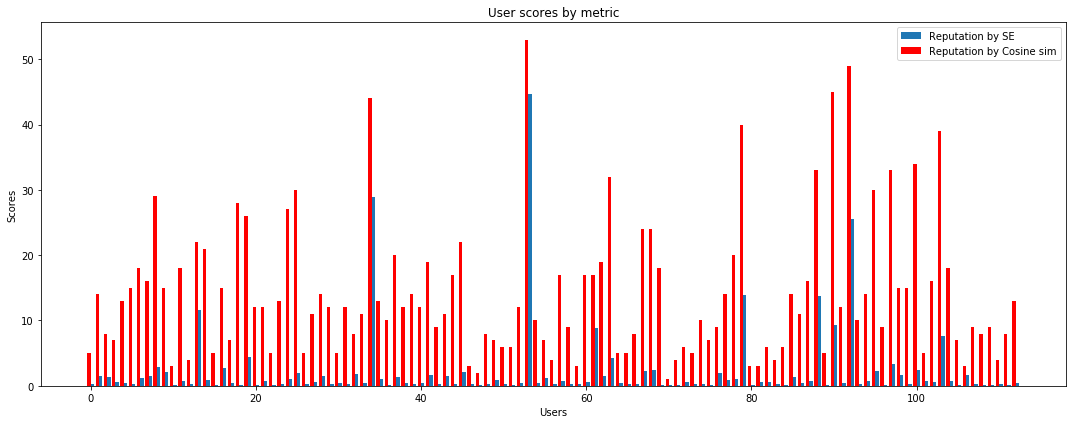

In [290]:
# corr_coef2 = expert_user / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : int(words_overal_cos_sim[key]*corr_coef2) for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

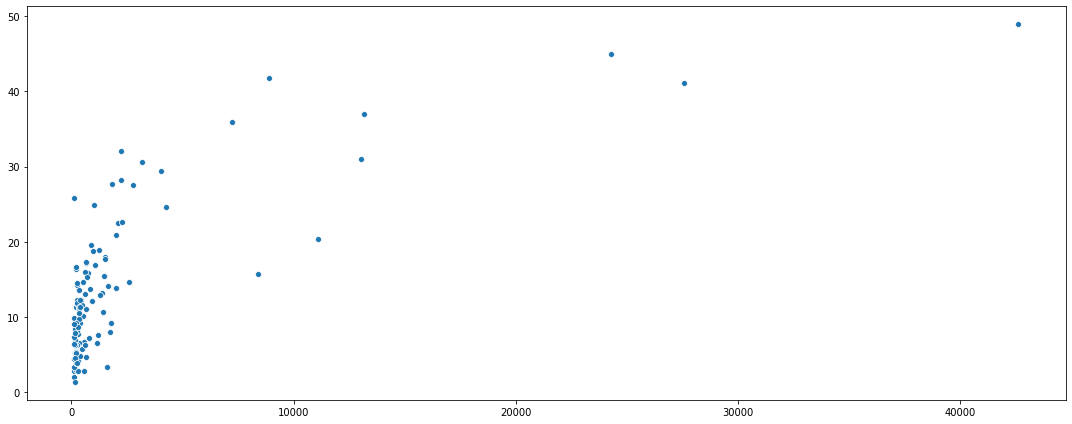

In [291]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [292]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.71530353]
 [0.71530353 1.        ]]


In [293]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, scale_coef=corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [294]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, enriched_merged_book)

In [295]:
# normalizing the score 
# words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

words_euclid_expert = words_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

In [296]:
words_euclid_expert

100.0

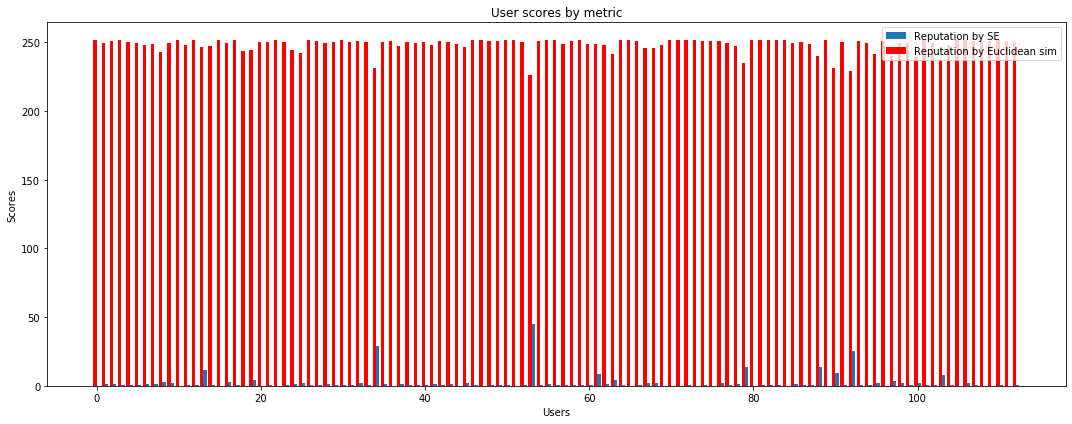

In [297]:
# corr_coef3 = expert_user / (words_euclid_expert + 1)
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

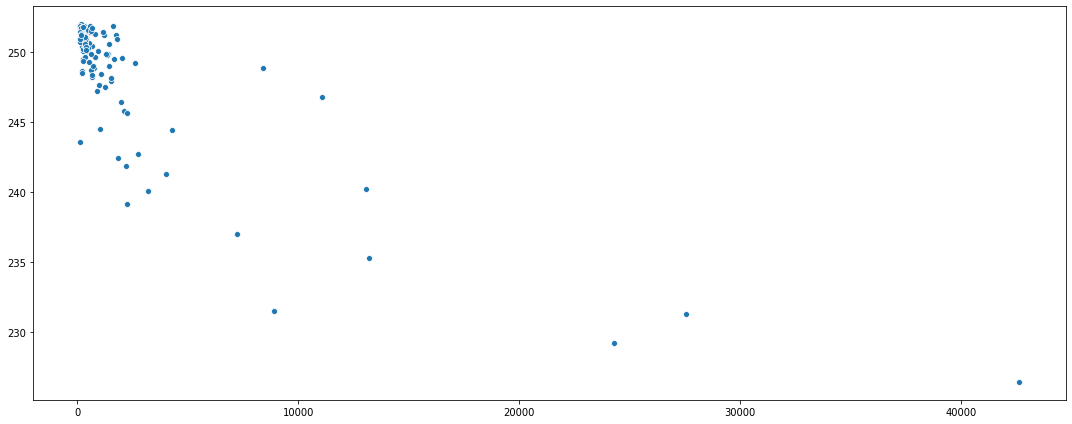

In [298]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [299]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[ 1.         -0.81643002]
 [-0.81643002  1.        ]]


In [300]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, scale_coef=corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

### Enriched model (accepted answers + adding the most expert user) testing #4

In [301]:
acc_ans_dict = loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", num_of_files_to_read=453)
model_processing_utils.join_tuples_and_lemantize(acc_ans_dict)
merged_book = model_processing_utils.merge_models(sections_book_dict)
merged_answers = model_processing_utils.merge_models(acc_ans_dict)

100%|██████████| 453/453 [00:00<00:00, 453032.84it/s]


In [302]:
len(merged_book)

10172

In [303]:
len(merged_answers)

8760

In [304]:
enriched_merged_book = model_processing_utils.merge_into_existing_model(merged_book, merged_answers)

In [305]:
len(enriched_merged_book)

18570

In [306]:
len(expert_to_enrich)

19793

In [307]:
enriched_merged_book = model_processing_utils.merge_into_existing_model(enriched_merged_book, expert_to_enrich)

In [308]:
len(enriched_merged_book)

35335

#### Phrases

Jaccard similarity

In [309]:
present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
len(present_user_rep)

114

In [310]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict[key]) for key in user_dict.keys()}

In [311]:
# normalizing the score 
# phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

phrases_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')
present_user_rep.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

95315

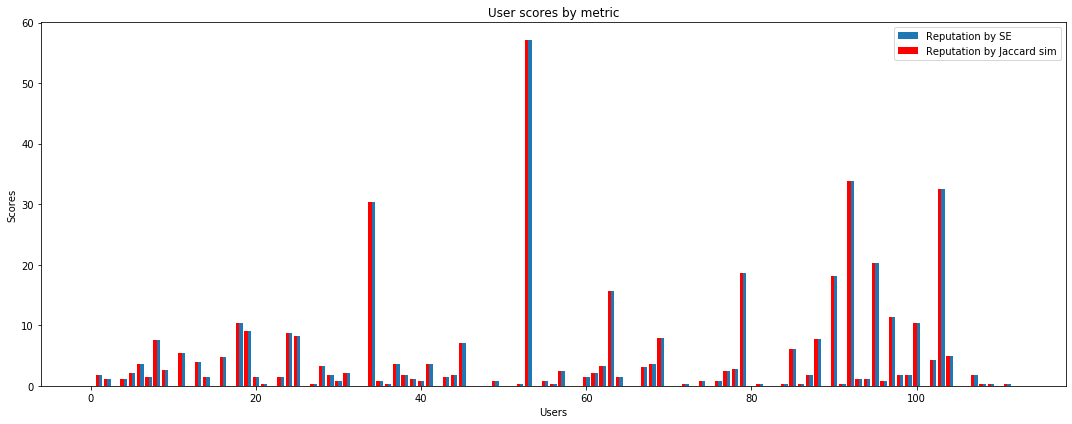

In [312]:
# corr_coef = expert_user / phrases_jacc_expert
corr_coef = get_corr_coef(expert_user, phrases_jacc_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in phrases_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_jacc_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

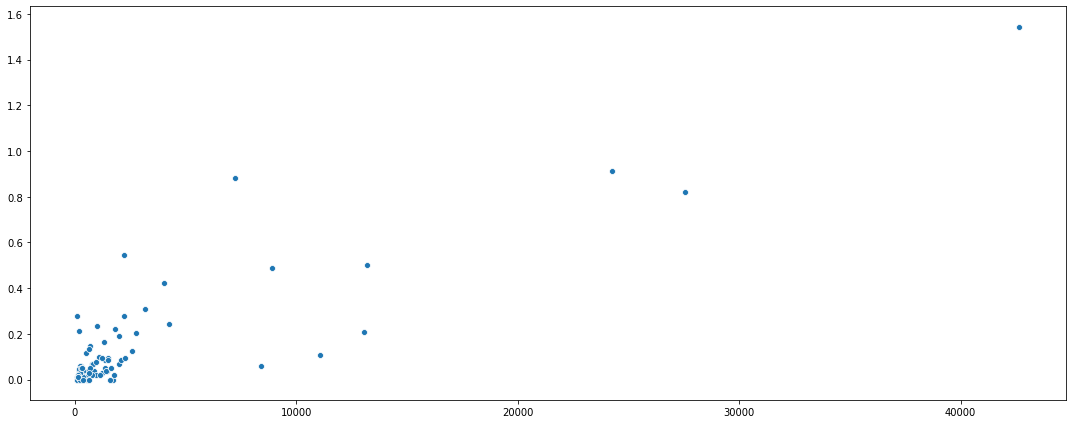

In [313]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [314]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.         0.87333856]
 [0.87333856 1.        ]]


In [315]:
# calculate_order_score(phrases_overal_jacq_sim, present_user_rep)
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, scale_coef=corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [316]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, enriched_merged_book)

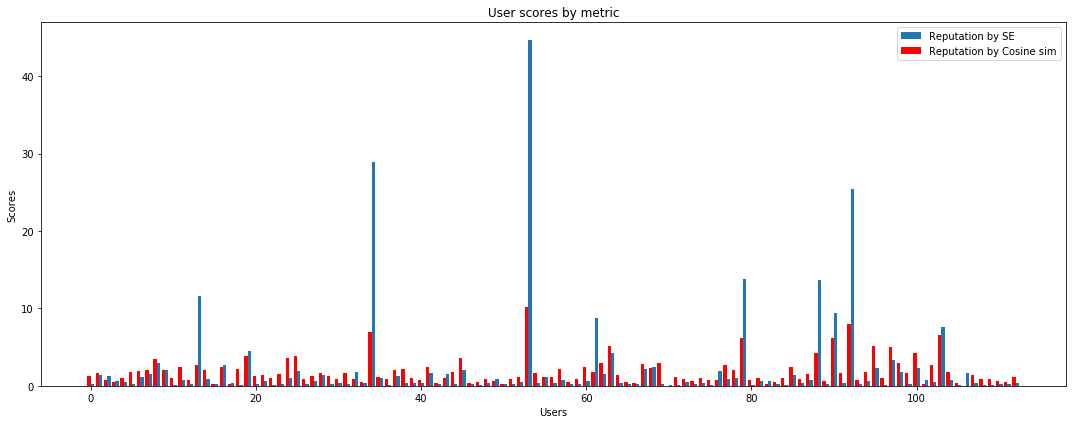

In [317]:
# normalizing the score 
# phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)

phrases_cos_expert = phrases_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / phrases_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrases_cos_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

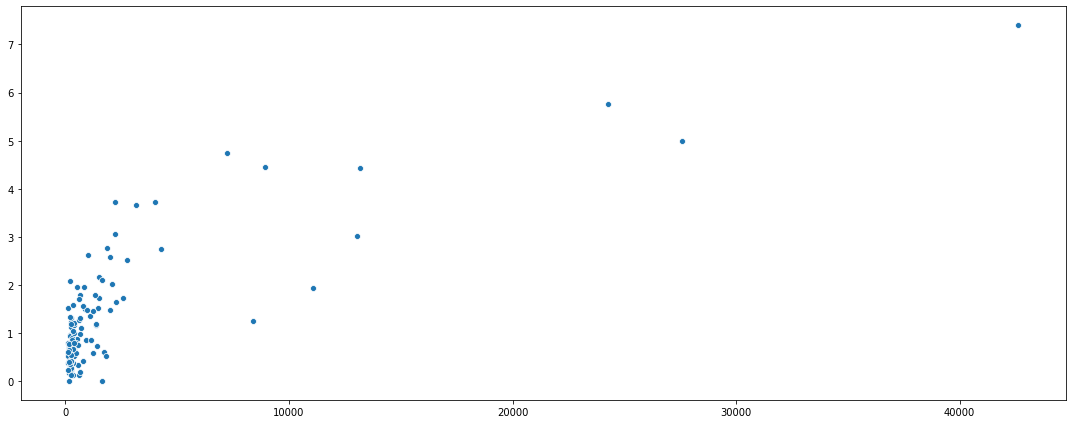

In [318]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [319]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.78667551]
 [0.78667551 1.        ]]


In [320]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, scale_coef=corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [321]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, enriched_merged_book)

In [322]:
# normalizing the score 
# phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

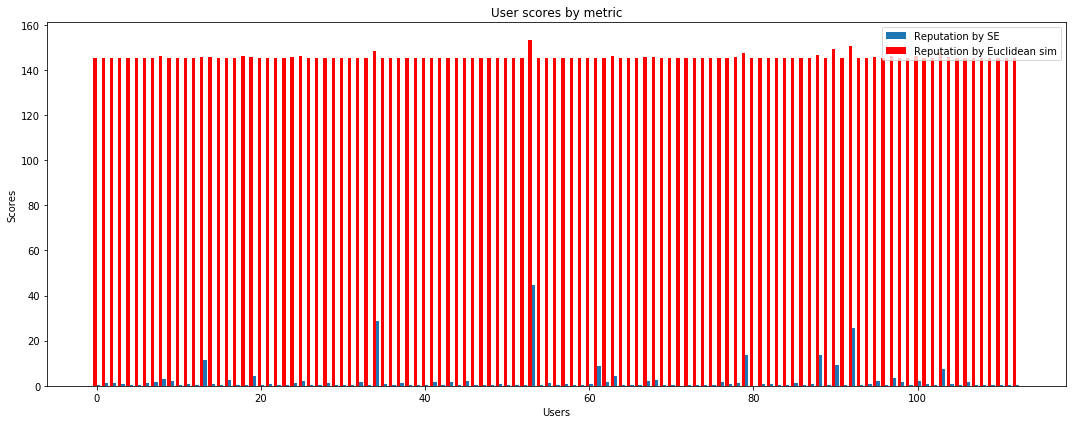

In [323]:
# normalizing the score 
# phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

phrases_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / (phrases_euclid_expert + 1)
corr_coef3 = get_corr_coef(expert_user, phrases_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

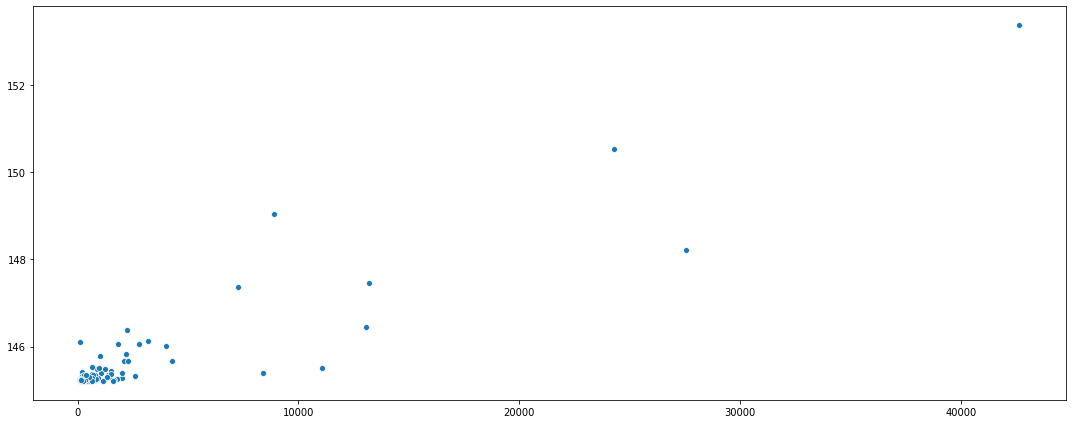

In [324]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [325]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91696534]
 [0.91696534 1.        ]]


In [326]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, scale_coef=corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [327]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
enriched_merged_book = model_processing_utils.join_phrases_into_words(enriched_merged_book)

100%|██████████| 114/114 [00:01<00:00, 58.16it/s]


Jaccard similarity

In [328]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

In [329]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)

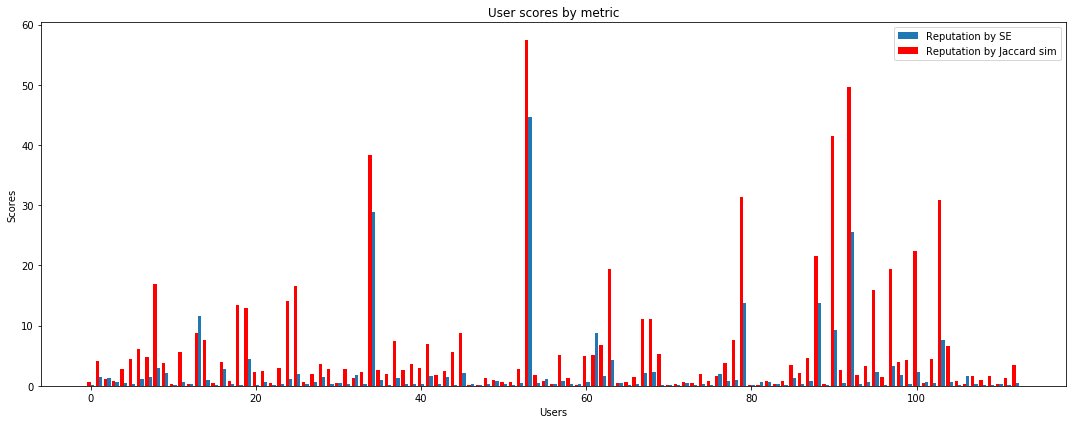

In [330]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)

words_jacc_expert = words_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

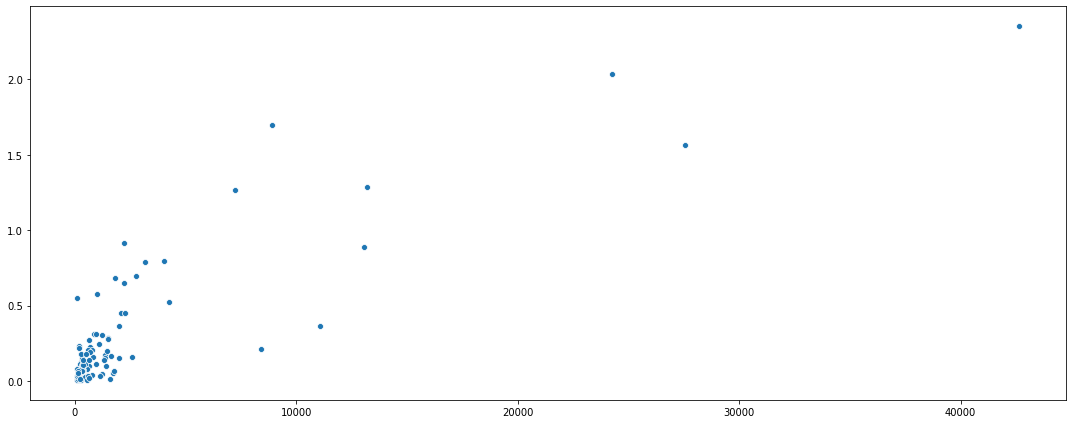

In [331]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [332]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.85360405]
 [0.85360405 1.        ]]


In [333]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, scale_coef=corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [334]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, enriched_merged_book)

In [335]:
# normalizing the score 
# words_overal_cos_sim = metrics.min_max_normalize(words_overal_cos_sim)

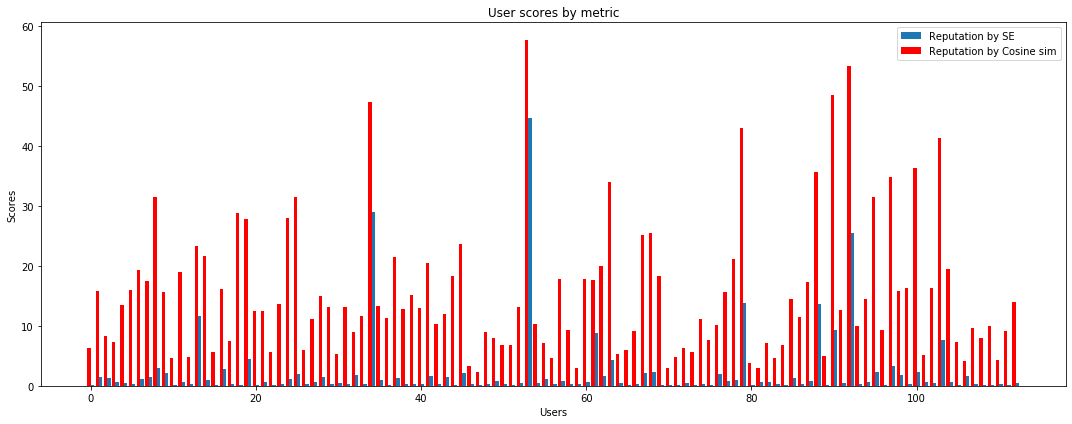

In [336]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)

words_cos_expert = words_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : words_overal_cos_sim[key]*corr_coef2 for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

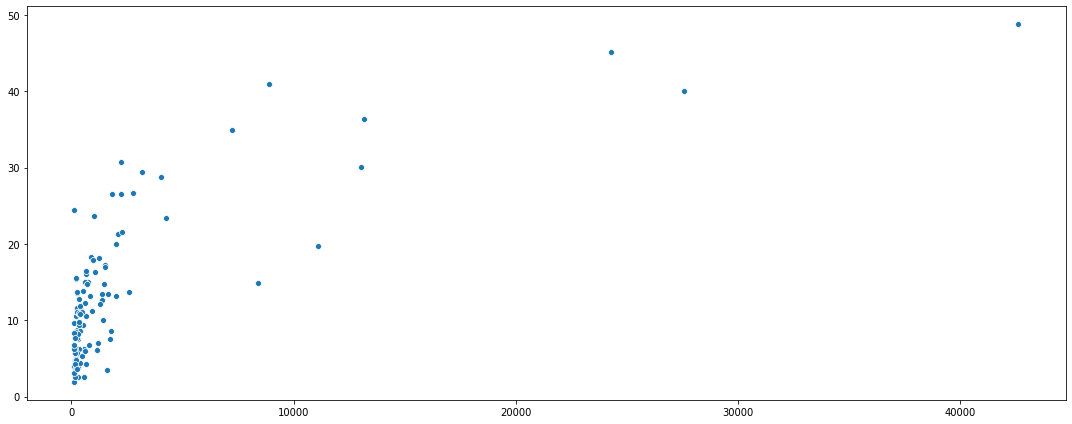

In [337]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [338]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.72968232]
 [0.72968232 1.        ]]


In [339]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, scale_coef=corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [340]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, enriched_merged_book)

In [341]:
# normalizing the score 
# words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

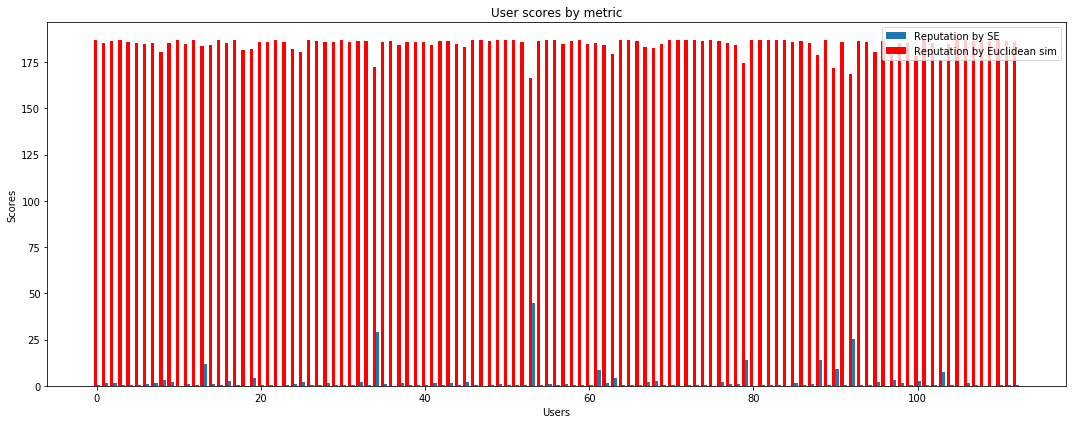

In [342]:
# normalizing the score 
# words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

words_euclid_expert = words_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / (words_euclid_expert + 1)
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

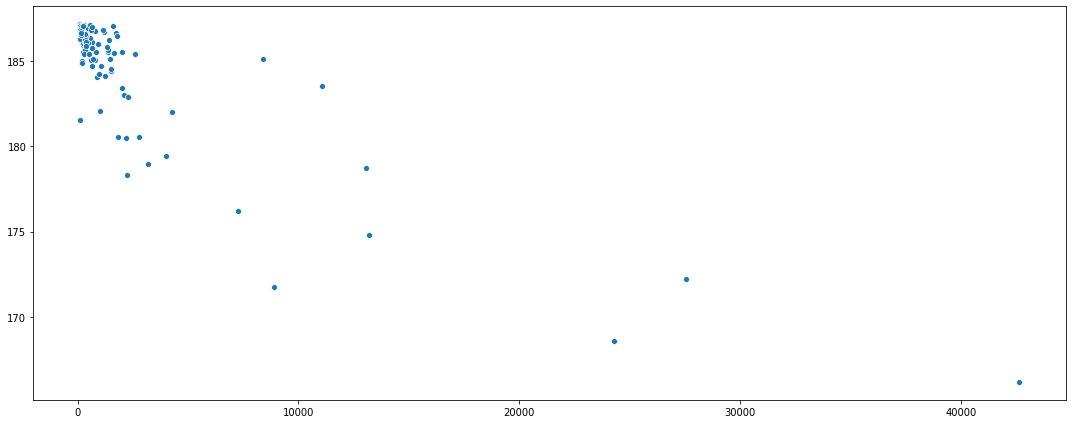

In [343]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [344]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[ 1.         -0.84582395]
 [-0.84582395  1.        ]]


In [345]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, scale_coef=corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

## Model evaluation - JavaNotesForProfessionals

### Loading the models

In [346]:
# sections_book_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters") } 
sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/java_notes_for_profesionals/acm_sub_sections", num_of_files_to_read="all")
user_dict = loading_models.get_user_dict_from_file(r"D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers")
user_rep = loading_models.get_user_reputation_dict_from_file(r"D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\reputation\user_reputation.txt")
# acc_ans_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers") } 

100%|██████████| 181/181 [00:00<00:00, 190.04it/s]


In [347]:
z_user_score_dict1 = loading_models.get_q_a_dict_from_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores\z_scores2.txt")
z_user_score_list = list(z_user_score_dict1.keys())
user_dict = { key : val for key, val in user_dict.items() if int(key.split("userId")[1]) in z_user_score_list}
z_user_score_dict1 = { key : val for key, val in z_user_score_dict1.items() if f"userId{key}" in list(user_dict.keys())}

In [348]:
print(f"num of user models: {len(user_dict)}, num of user reps: {len(user_rep)}")

num of user models: 114, num of user reps: 13085


Looking at the book model

In [349]:
%%capture
sections_book_dict

### Basic model testing #5

#### Phrases

Jaccard similarity

In [350]:
model_processing_utils.join_tuples_and_lemantize(user_dict)
model_processing_utils.join_tuples_and_lemantize(sections_book_dict)
merged_book = model_processing_utils.merge_models(sections_book_dict)

present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
len(present_user_rep)

100%|██████████| 630/630 [00:00<00:00, 629445.34it/s]


114

Merged book:

In [351]:
%%capture
merged_book

In [352]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict[key]) for key in user_dict.keys()}

In [353]:
# normalizing the score 
# phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

In [354]:
phrases_overal_jacq_sim['userId1352']

3.77171

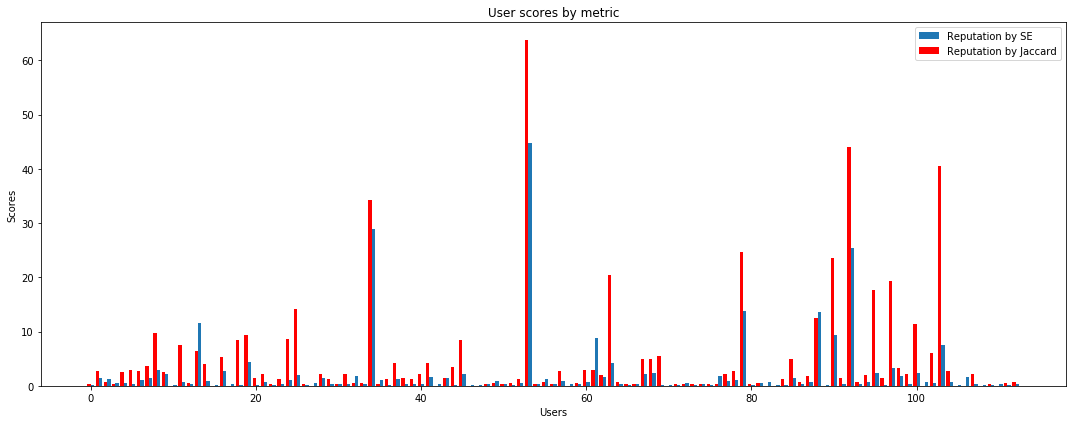

In [355]:
phrases_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')
present_user_rep.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / phrases_jacc_expert
corr_coef = get_corr_coef(expert_user, phrases_jacc_expert)


# corr_coef = present_user_rep['userId1352']/phrases_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in phrases_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard")

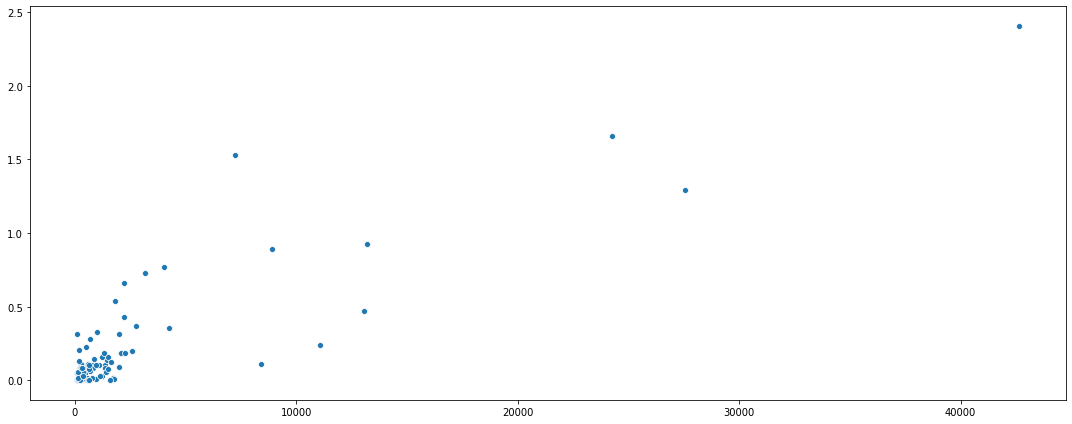

In [356]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [357]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.        0.8756224]
 [0.8756224 1.       ]]


In [358]:
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Checking if our model isnt biased by the size of user models

In [359]:
df = get_sorted_file_list_by_size(phrases_overal_jacq_sim, "D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\answers")

In [360]:
df.head(20)

,UserID,Metric score,file_size
53,userId3249,2.40674,192201
92,userId7167,1.65846,110915
90,userId7080,0.89083,79009
34,userId2314,1.29163,70386
103,userId90992,1.52840,54876
79,userId5692,0.92826,51428
100,userId8500,0.42825,26354
88,userId66,0.47079,26119
97,userId79256,0.73205,25411
63,userId39690,0.77230,22454


Doesnt look like it - first 3 positions match but the rest not 

Cosine similarity

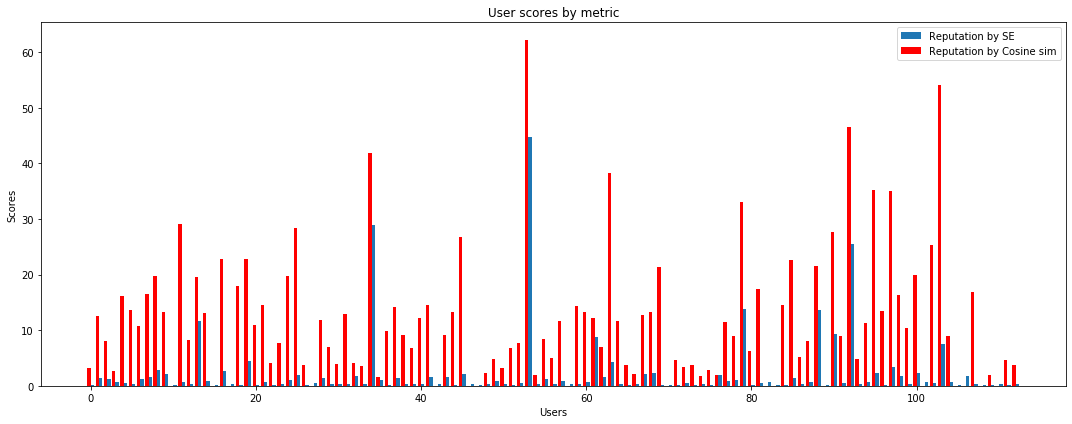

In [361]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, merged_book)

# normalizing the score 
# phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)

phrases_cos_expert = phrases_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / phrases_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrases_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/phrases_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

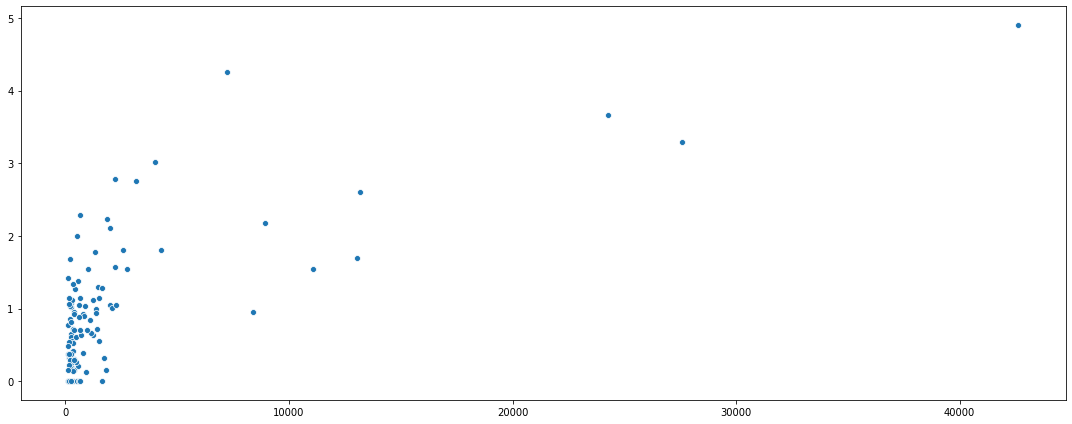

In [362]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [363]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.69511859]
 [0.69511859 1.        ]]


In [364]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

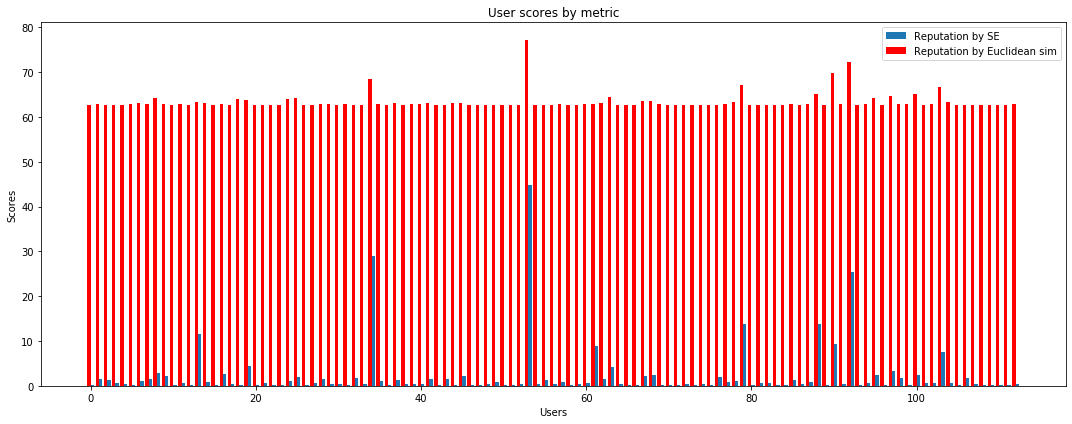

In [365]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, merged_book)

# normalizing the score 
# phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

phrases_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / phrases_euclid_expert
corr_coef3 = get_corr_coef(expert_user, phrases_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/phrases_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

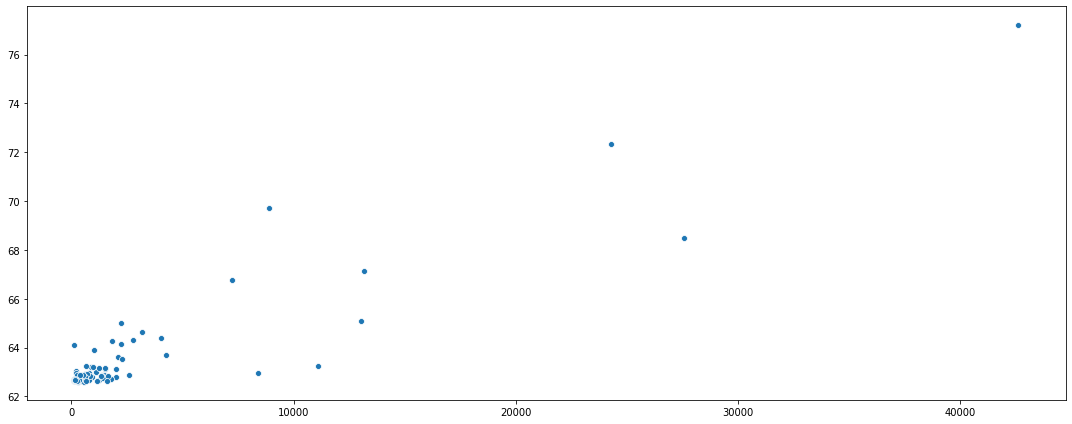

In [366]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [367]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91859442]
 [0.91859442 1.        ]]


In [368]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [369]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
merged_book = model_processing_utils.join_phrases_into_words(merged_book)

100%|██████████| 114/114 [00:01<00:00, 59.61it/s]


In [370]:
len(user_dict_words['userId11200'])

252

In [371]:
len(merged_book)

21108

Jaccard similarity

In [372]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

In [373]:
words_overal_jacq_sim['userId1352']

2.89211

In [374]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)

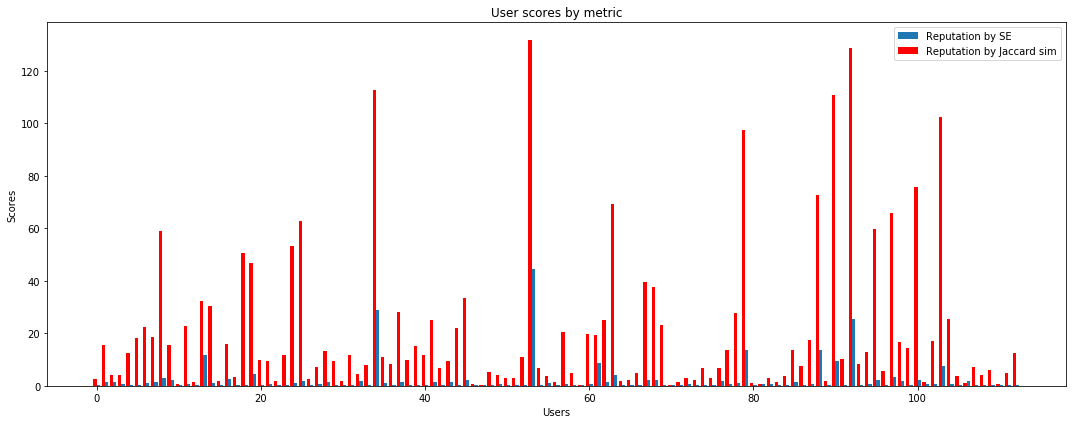

In [375]:
words_jacc_expert = words_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef = present_user_rep['userId1352']/words_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

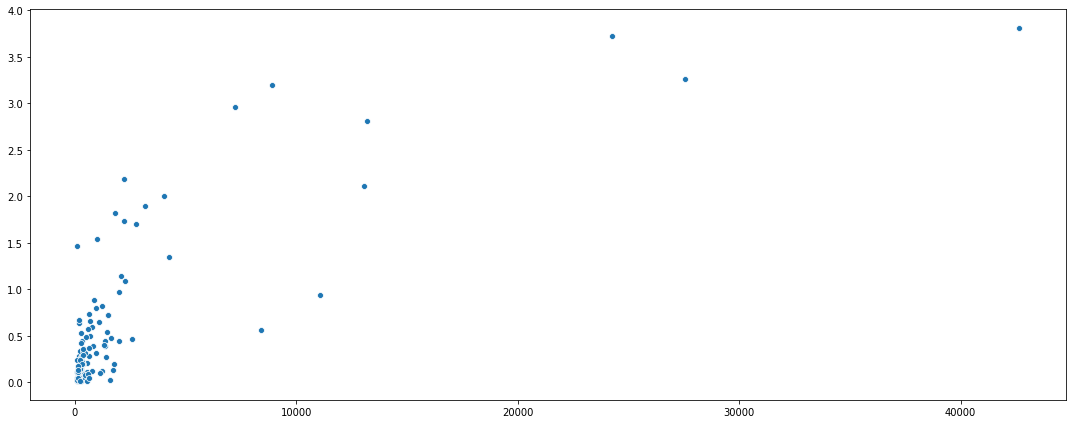

In [376]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [377]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.77786543]
 [0.77786543 1.        ]]


In [378]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [379]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, merged_book)

In [380]:
# normalizing the score 
# words_overal_cos_sim = metrics.min_max_normalize(words_overal_cos_sim)

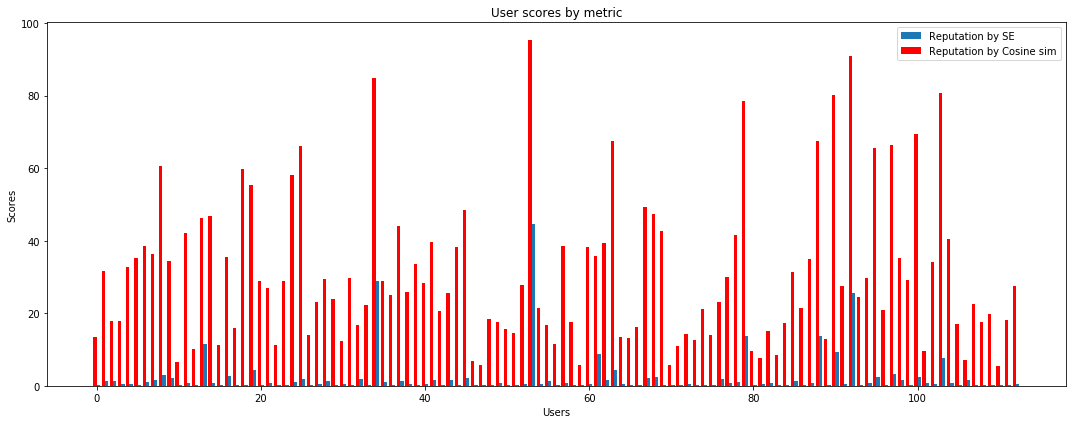

In [381]:
words_cos_expert = words_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/words_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : words_overal_cos_sim[key]*corr_coef2 for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

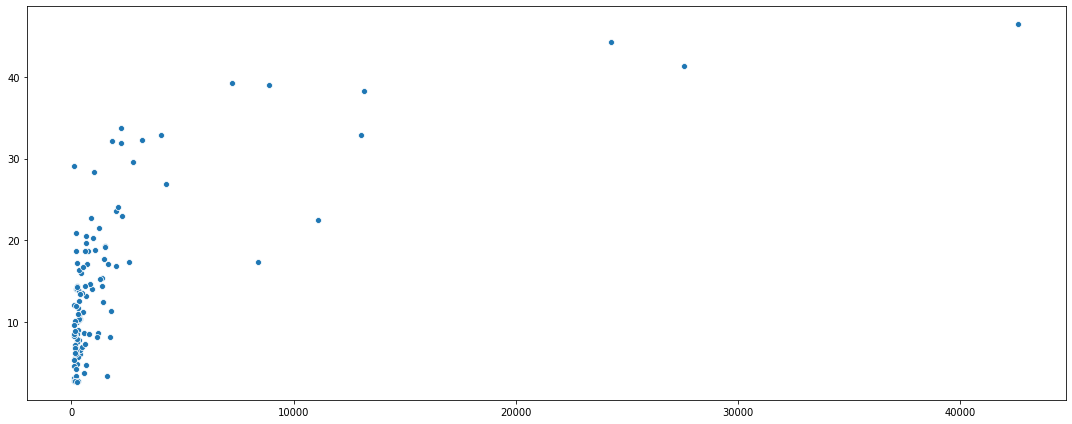

In [382]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [383]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.66412022]
 [0.66412022 1.        ]]


In [384]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [385]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, merged_book)

In [386]:
# normalizing the score 
# words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

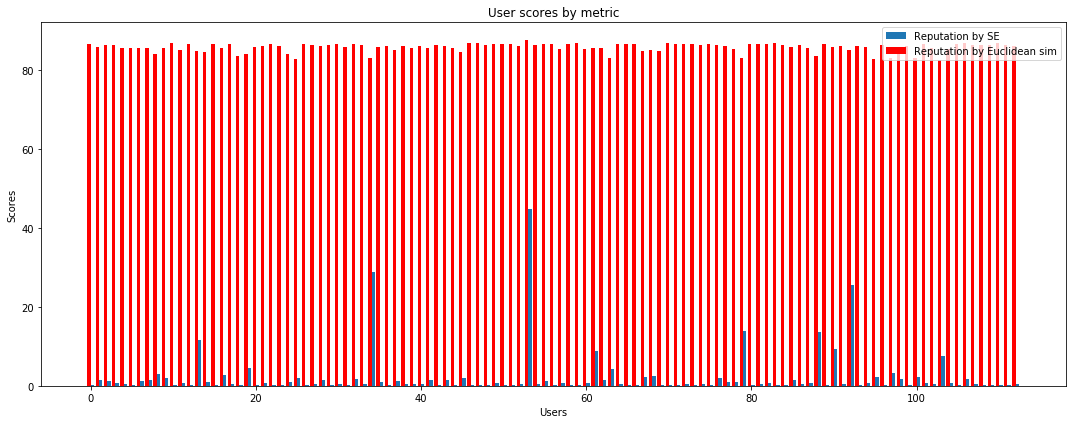

In [387]:
words_euclid_expert = words_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / words_euclid_expert
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

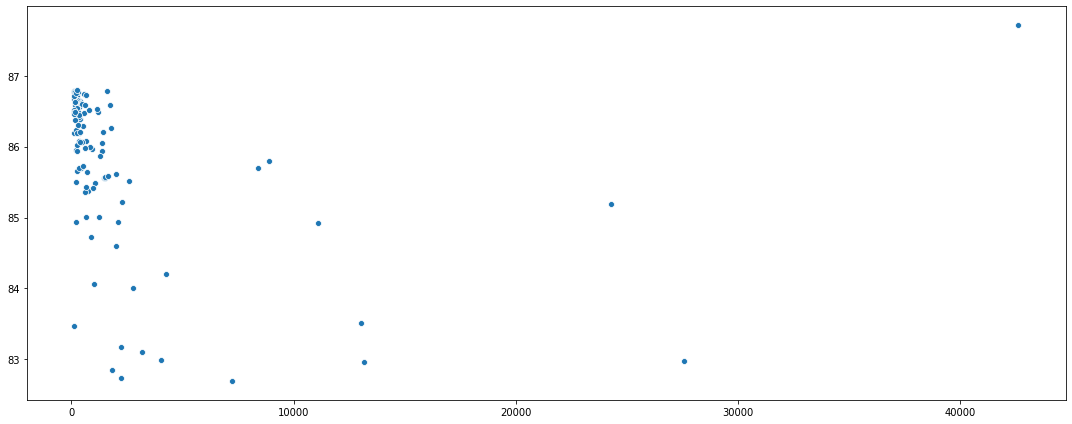

In [388]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [389]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[ 1.        -0.2417017]
 [-0.2417017  1.       ]]


In [390]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

### Enriched model (accepted answers) testing #6

In [391]:
acc_ans_dict = loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", num_of_files_to_read=453)
model_processing_utils.join_tuples_and_lemantize(acc_ans_dict)
merged_book = model_processing_utils.merge_models(sections_book_dict)
merged_answers = model_processing_utils.merge_models(acc_ans_dict)

100%|██████████| 453/453 [00:00<00:00, 463645.61it/s]


In [392]:
len(merged_answers)

8760

In [393]:
len(merged_book)

10554

In [394]:
enriched_merged_book = model_processing_utils.merge_into_existing_model(merged_book, merged_answers)

In [395]:
len(enriched_merged_book)

18657

#### Phrases

Jaccard similarity

In [396]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict[key]) for key in user_dict.keys()}

In [397]:
phrases_overal_jacq_sim['userId1352']

5.44936

In [398]:
# normalizing the score 
# phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

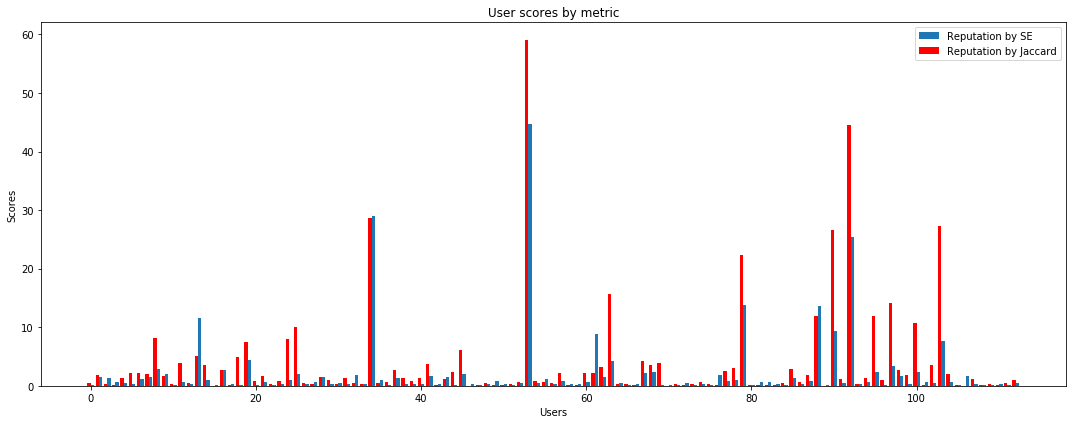

In [399]:
phrases_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / phrases_jacc_expert
corr_coef = get_corr_coef(expert_user, phrases_jacc_expert)



# corr_coef = present_user_rep['userId1352']/phrases_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in phrases_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard")

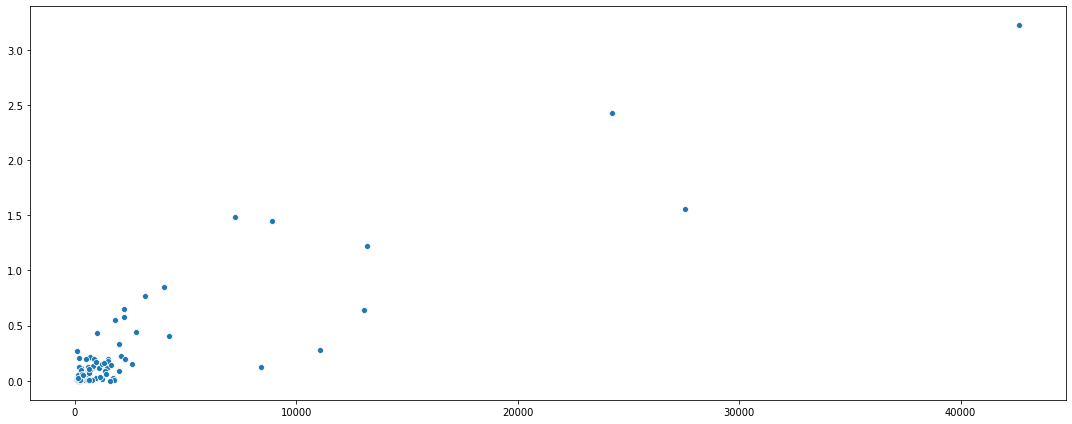

In [400]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [401]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.         0.90544661]
 [0.90544661 1.        ]]


In [402]:
# calculate_order_score(phrases_overal_jacq_sim, present_user_rep)
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

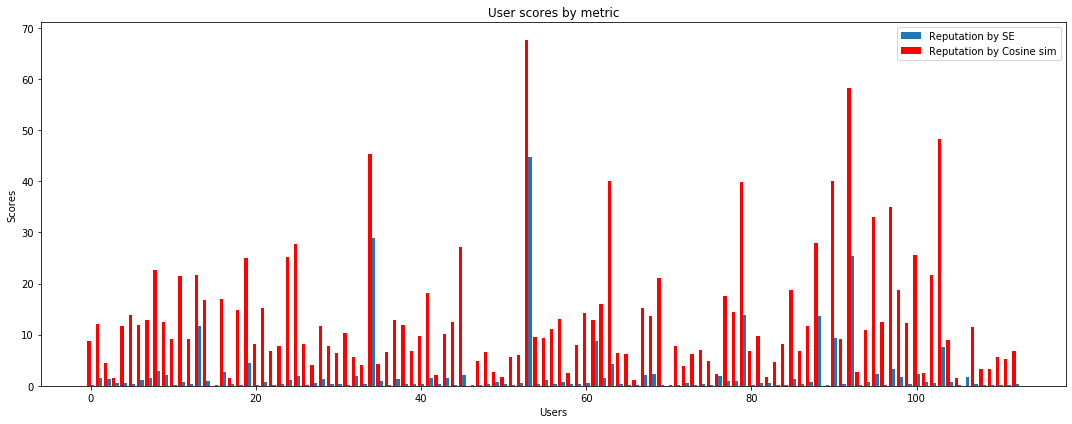

In [403]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, enriched_merged_book)

# normalizing the score 
# phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)

phrases_cos_expert = phrases_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / phrases_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrases_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/phrases_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

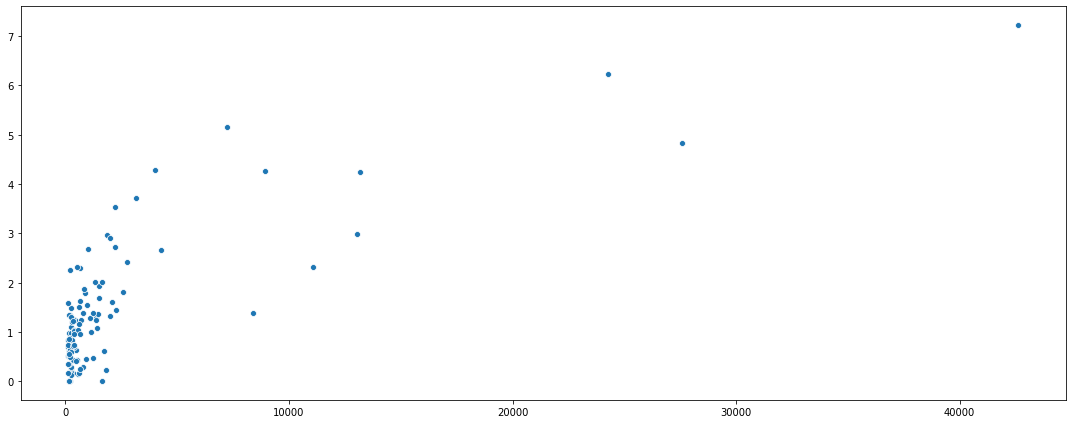

In [404]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [405]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.77026142]
 [0.77026142 1.        ]]


In [406]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

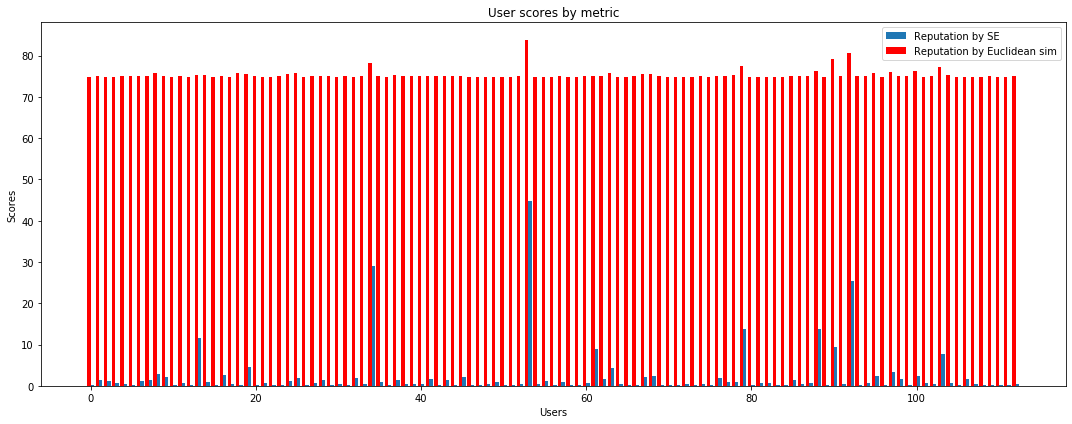

In [408]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, enriched_merged_book)

# normalizing the score 
# phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

phrases_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / phrases_euclid_expert
corr_coef3 = get_corr_coef(expert_user, phrases_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/phrases_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

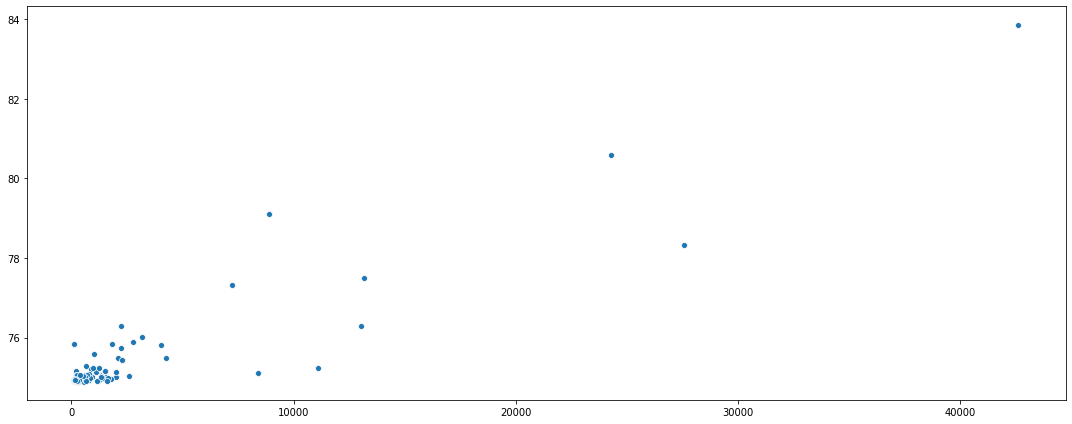

In [409]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [410]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91916881]
 [0.91916881 1.        ]]


In [411]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [412]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
enriched_merged_book = model_processing_utils.join_phrases_into_words(enriched_merged_book)

100%|██████████| 114/114 [00:02<00:00, 56.84it/s]


Jaccard similarity

In [413]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

In [414]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)

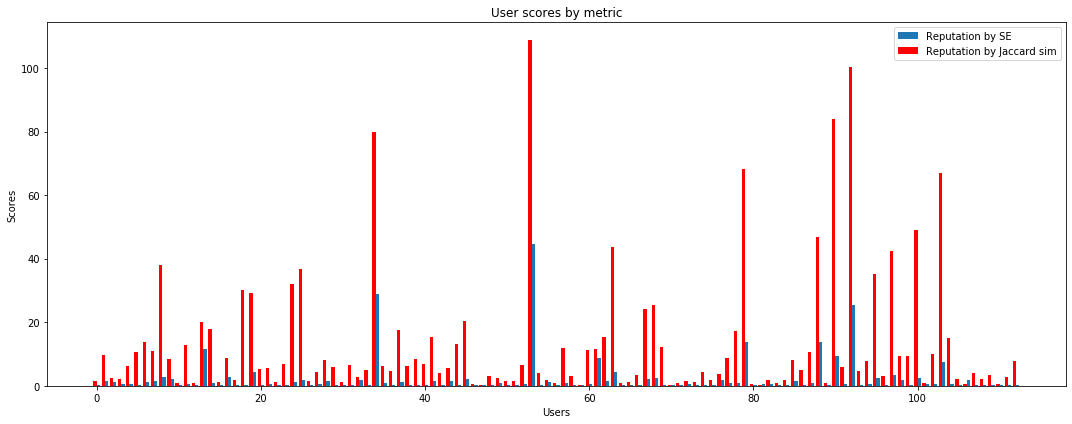

In [415]:
words_jacc_expert = words_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef = present_user_rep['userId1352']/words_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

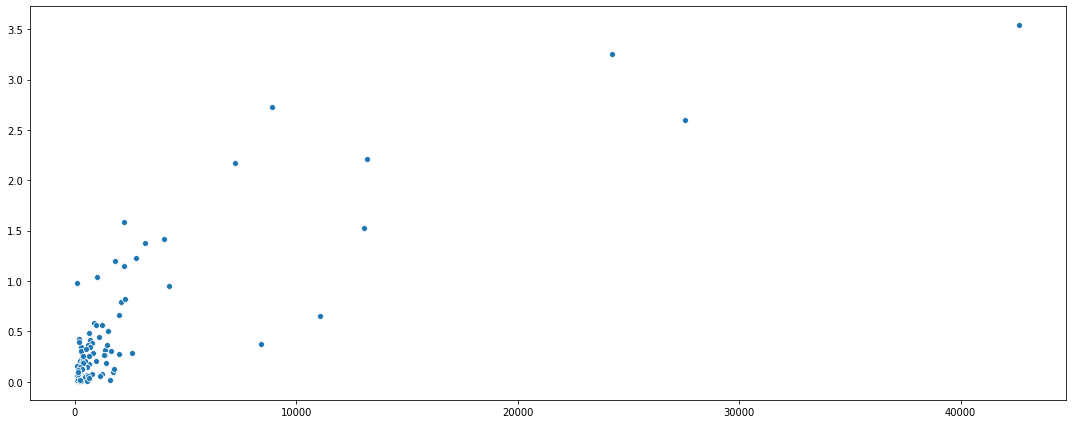

In [416]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [417]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.82985154]
 [0.82985154 1.        ]]


In [418]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [419]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, enriched_merged_book)

In [420]:
# normalizing the score 
# words_overal_cos_sim = metrics.min_max_normalize(words_overal_cos_sim)

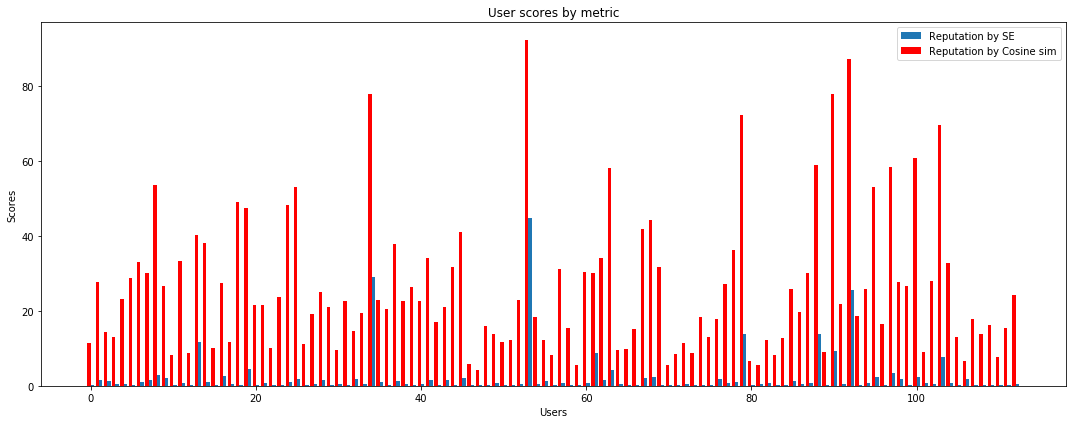

In [421]:
words_cos_expert = words_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/words_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : words_overal_cos_sim[key]*corr_coef2 for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

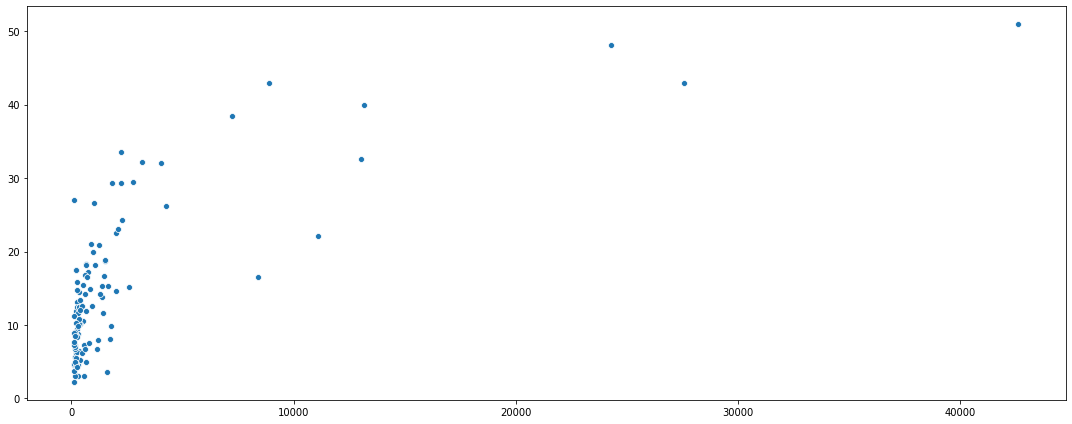

In [422]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [423]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.71290293]
 [0.71290293 1.        ]]


In [424]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [425]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, enriched_merged_book)

In [426]:
# normalizing the score 
words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

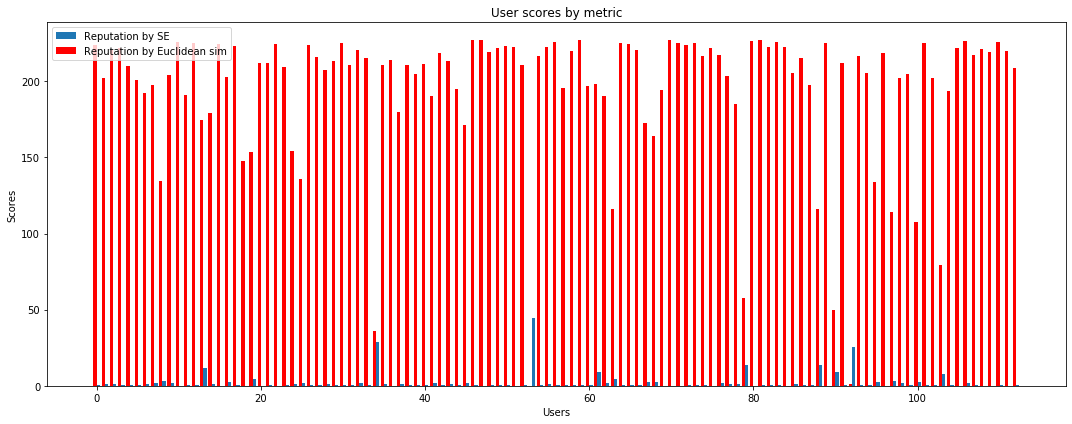

In [427]:
words_euclid_expert = words_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / words_euclid_expert
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

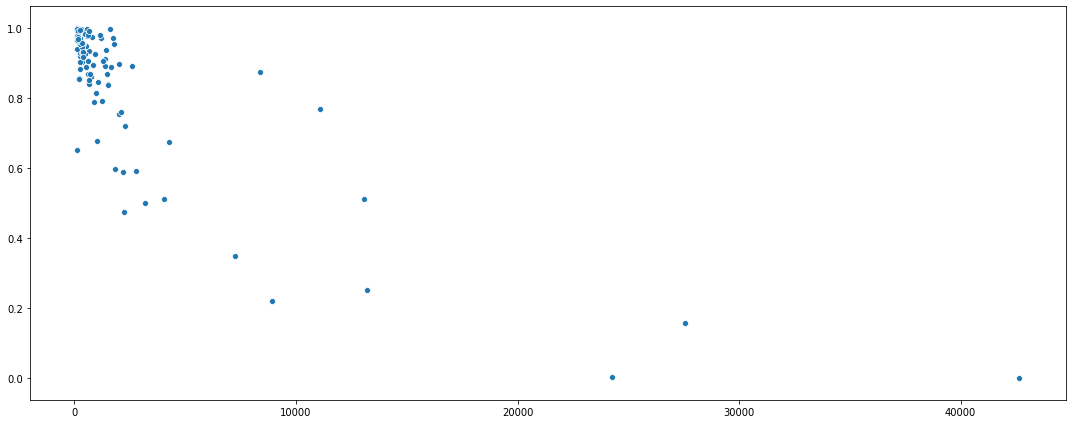

In [428]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [429]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[ 1.         -0.80523953]
 [-0.80523953  1.        ]]


In [430]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

### Enriched model (adding the most expert user) testing #7

In [431]:
merged_book = model_processing_utils.merge_models(sections_book_dict)
user_dict = loading_models.get_user_dict_from_file(r"D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers")

100%|██████████| 181/181 [00:01<00:00, 159.60it/s]


In [432]:
z_user_score_dict1 = loading_models.get_q_a_dict_from_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores\z_scores2.txt")
z_user_score_list = list(z_user_score_dict1.keys())
user_dict = { key : val for key, val in user_dict.items() if int(key.split("userId")[1]) in z_user_score_list}
z_user_score_dict1 = { key : val for key, val in z_user_score_dict1.items() if f"userId{key}" in list(user_dict.keys())}

In [433]:
model_processing_utils.join_tuples_and_lemantize(user_dict)

100%|██████████| 114/114 [00:34<00:00,  3.27it/s]


In [434]:
expert_to_enrich = user_dict['userId1352']

In [435]:
len(expert_to_enrich)

19793

In [436]:
len(merged_book)

10554

In [437]:
enriched_merged_book = model_processing_utils.merge_into_existing_model(merged_book, expert_to_enrich)

In [438]:
len(enriched_merged_book)

28027

#### Phrases

Jaccard similarity

In [439]:
present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
len(present_user_rep)

114

In [440]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict[key]) for key in user_dict.keys()}

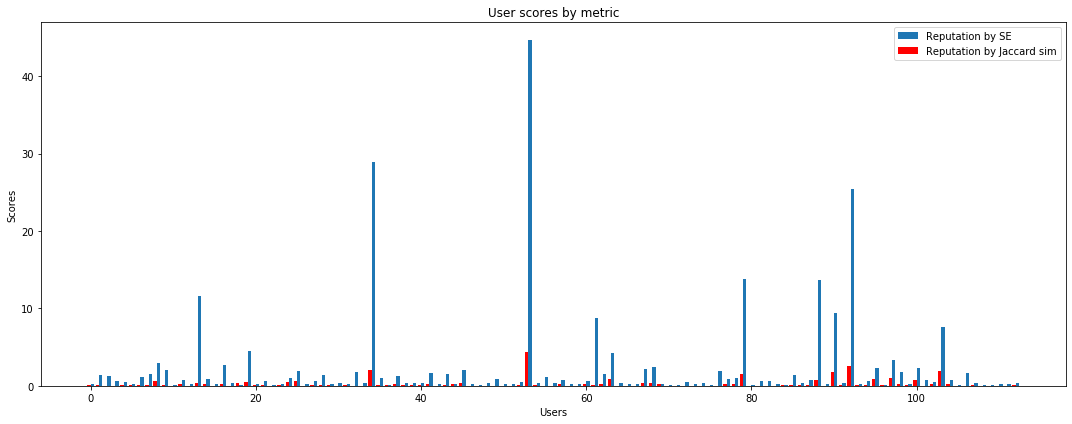

In [441]:
# normalizing the score 
# phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

phrases_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')
present_user_rep.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / phrases_jacc_expert
corr_coef = get_corr_coef(expert_user, phrases_jacc_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in phrases_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

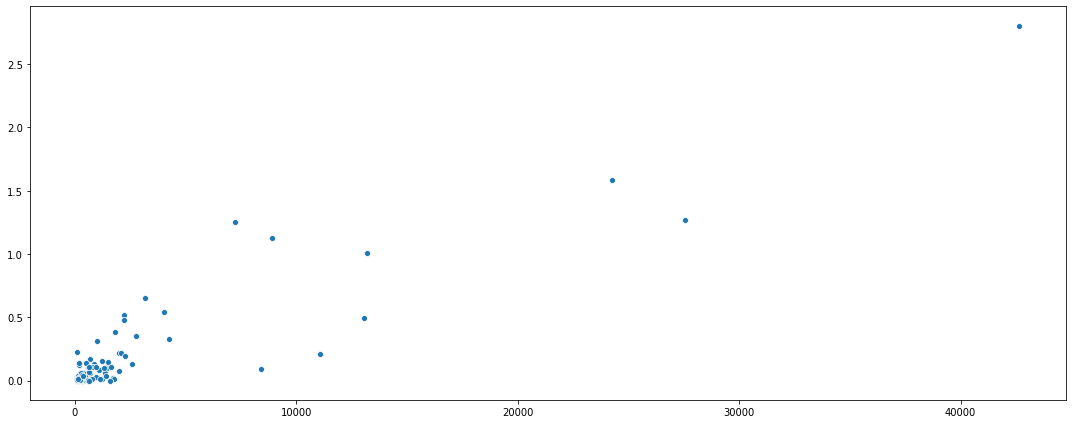

In [442]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [443]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.         0.91222267]
 [0.91222267 1.        ]]


In [444]:
# calculate_order_score(phrases_overal_jacq_sim, present_user_rep)
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [445]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, enriched_merged_book)

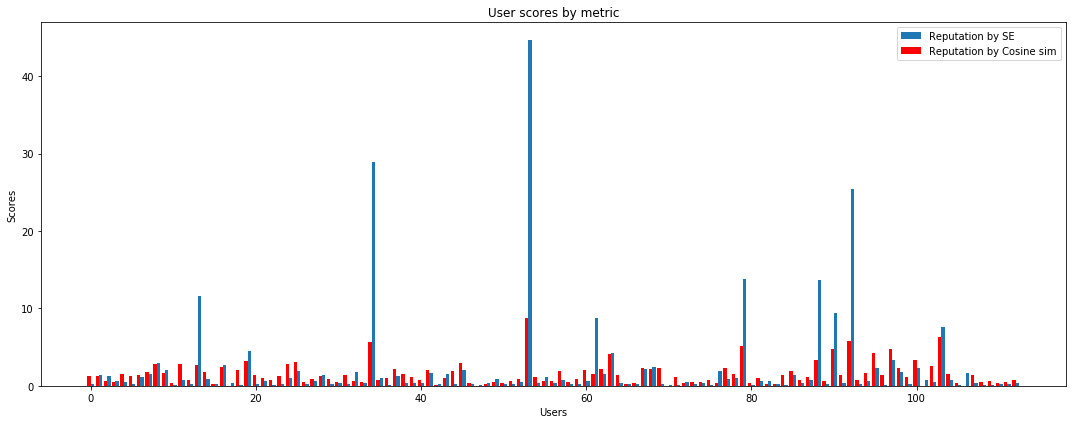

In [446]:
# normalizing the score 
# phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)

phrases_cos_expert = phrases_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / phrases_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrases_cos_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

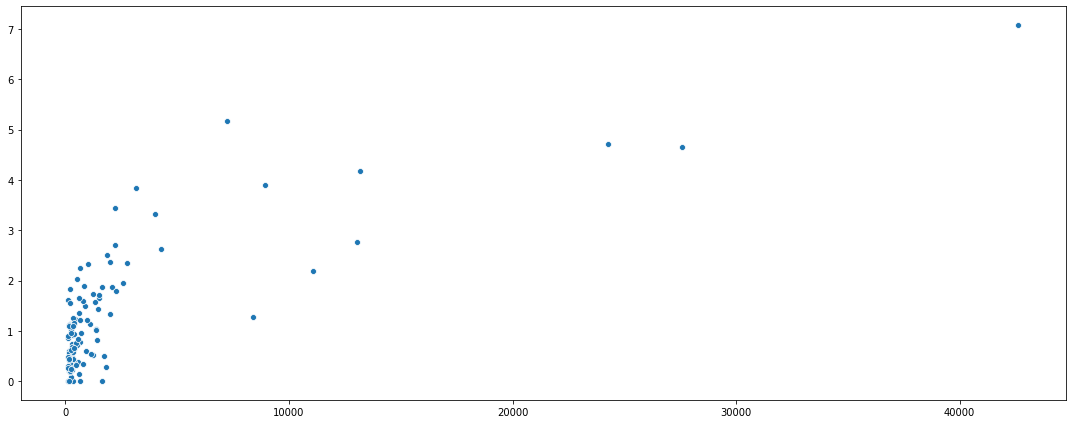

In [447]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [448]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.76676924]
 [0.76676924 1.        ]]


In [449]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [450]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, enriched_merged_book)

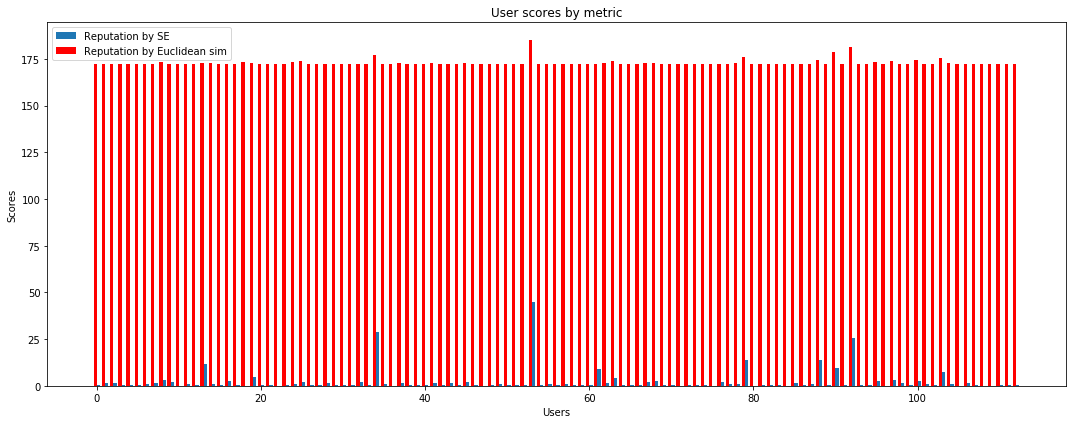

In [451]:
# normalizing the score 
# phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

phrases_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / (phrases_euclid_expert + 1)
corr_coef3 = get_corr_coef(expert_user, phrases_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

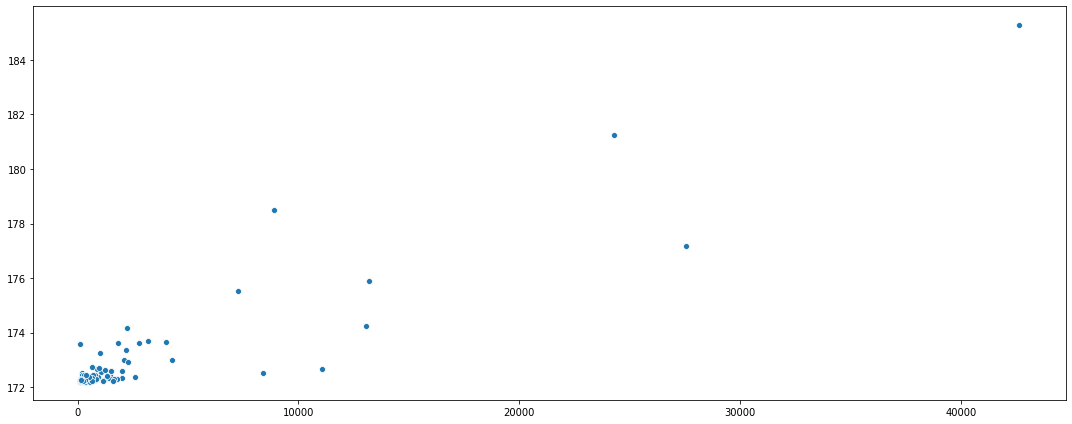

In [452]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [453]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91632827]
 [0.91632827 1.        ]]


In [454]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [455]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
enriched_merged_book = model_processing_utils.join_phrases_into_words(enriched_merged_book)

100%|██████████| 114/114 [00:01<00:00, 59.66it/s]


Jaccard similarity

In [456]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

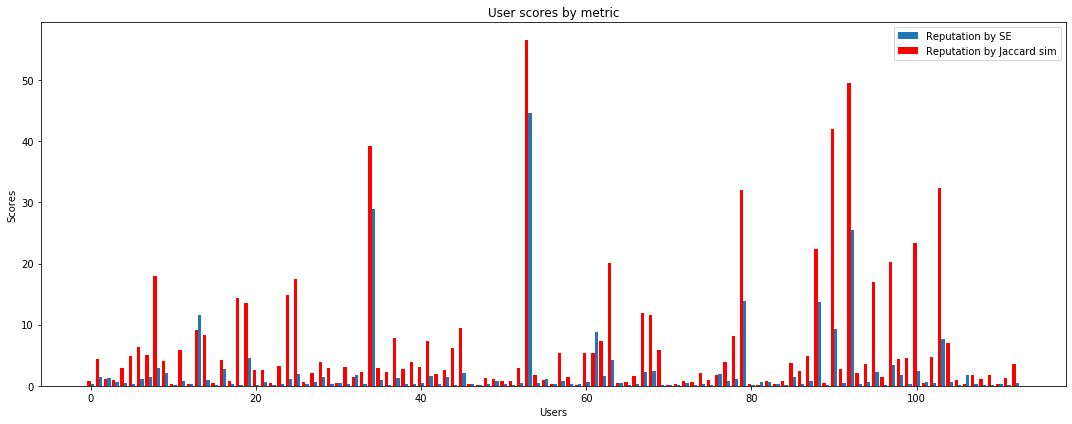

In [457]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)


words_jacc_expert = words_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

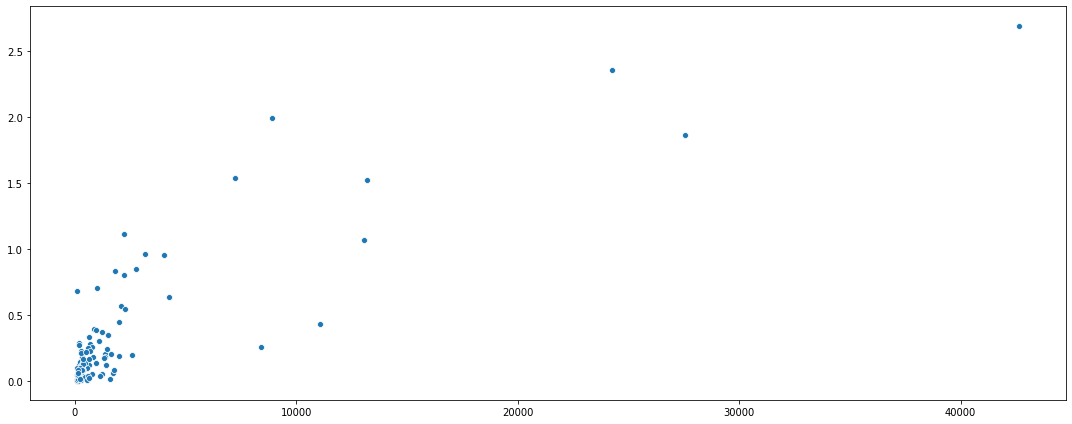

In [458]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [459]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.84331549]
 [0.84331549 1.        ]]


In [460]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [461]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, enriched_merged_book)

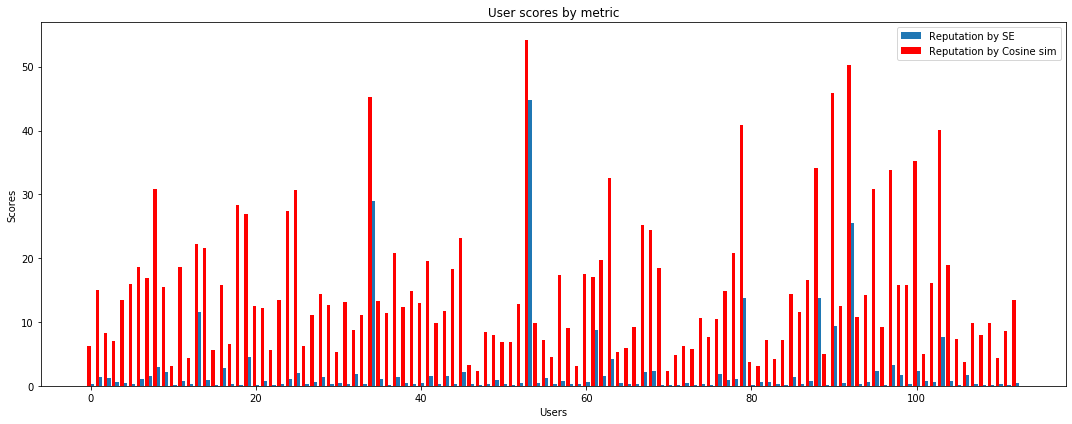

In [462]:
# normalizing the score 
# words_overal_cos_sim = metrics.min_max_normalize(words_overal_cos_sim)

words_cos_expert = words_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : words_overal_cos_sim[key]*corr_coef2 for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

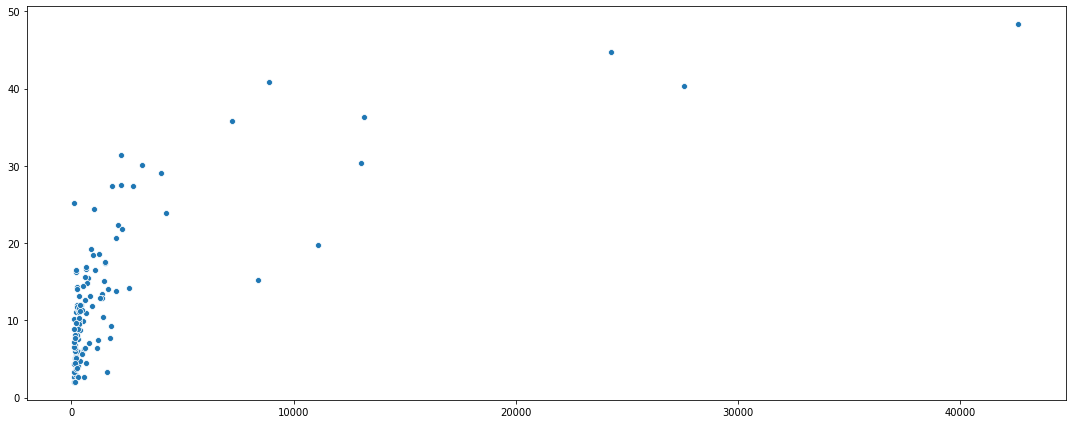

In [463]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [464]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.71663521]
 [0.71663521 1.        ]]


In [465]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [466]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, enriched_merged_book)

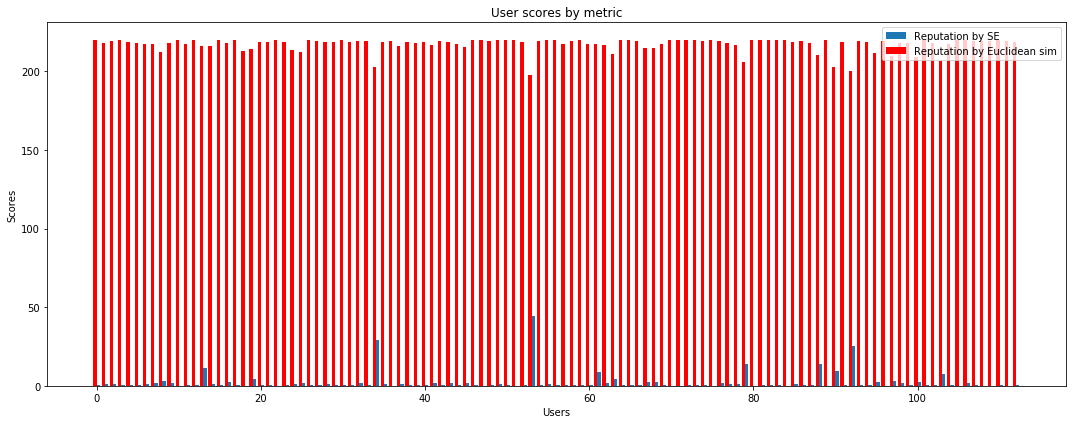

In [467]:
# normalizing the score 
# words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)


words_euclid_expert = words_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / (words_euclid_expert + 1)
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

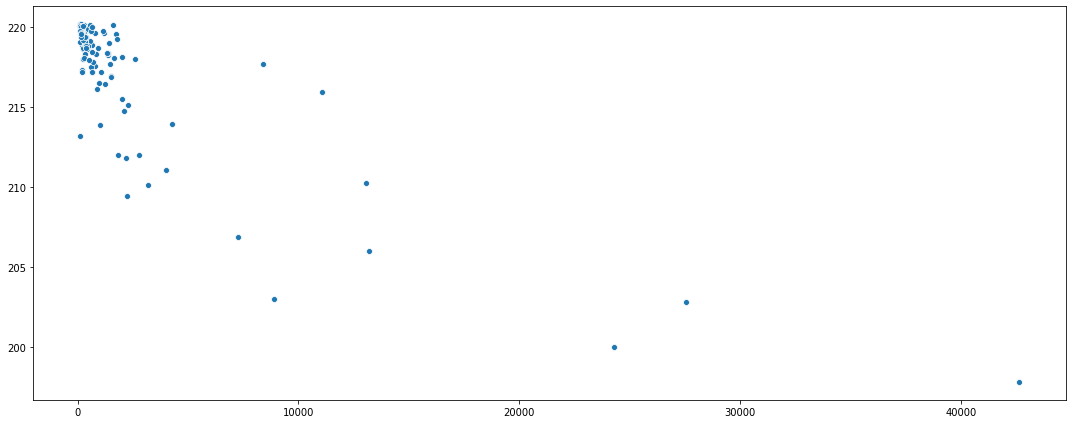

In [468]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [469]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[ 1.         -0.82192593]
 [-0.82192593  1.        ]]


In [470]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

### Enriched model (accepted answers + adding the most expert user) testing #8

In [471]:
acc_ans_dict = loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", num_of_files_to_read=453)
model_processing_utils.join_tuples_and_lemantize(acc_ans_dict)
merged_book = model_processing_utils.merge_models(sections_book_dict)
merged_answers = model_processing_utils.merge_models(acc_ans_dict)

100%|██████████| 453/453 [00:00<?, ?it/s]


In [472]:
len(merged_book)

10554

In [473]:
len(merged_answers)

8760

In [474]:
enriched_merged_book = model_processing_utils.merge_into_existing_model(merged_book, merged_answers)

In [475]:
len(enriched_merged_book)

18657

In [476]:
len(expert_to_enrich)

19793

In [477]:
enriched_merged_book = model_processing_utils.merge_into_existing_model(enriched_merged_book, expert_to_enrich)

In [478]:
len(enriched_merged_book)

35246

#### Phrases

Jaccard similarity

In [479]:
present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
len(present_user_rep)

114

In [480]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict[key]) for key in user_dict.keys()}

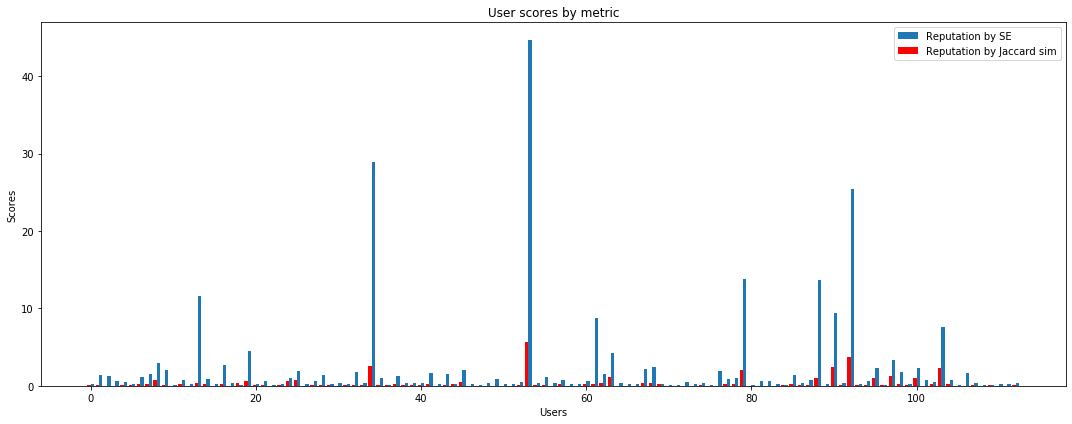

In [481]:
# normalizing the score 
# phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

phrases_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')
present_user_rep.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / phrases_jacc_expert
corr_coef = get_corr_coef(expert_user, phrases_jacc_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in phrases_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

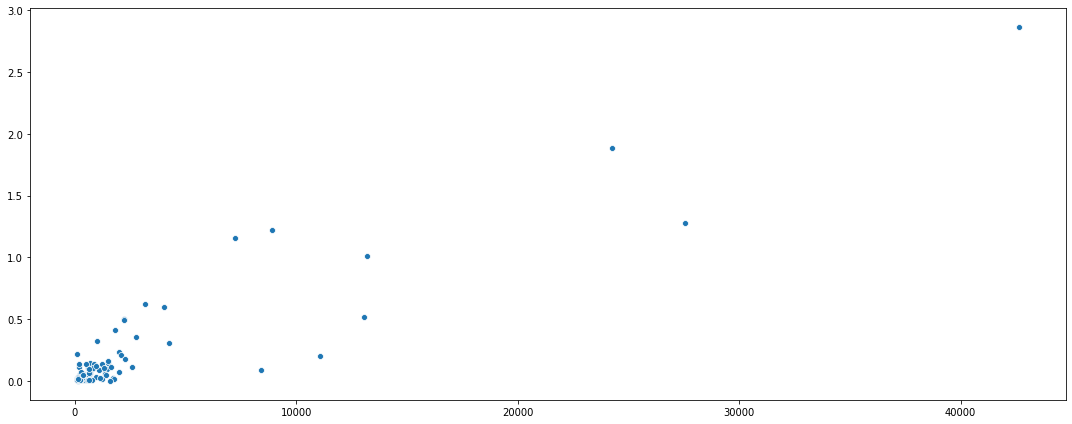

In [482]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [483]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.         0.91669934]
 [0.91669934 1.        ]]


In [484]:
# calculate_order_score(phrases_overal_jacq_sim, present_user_rep)
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [485]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, enriched_merged_book)

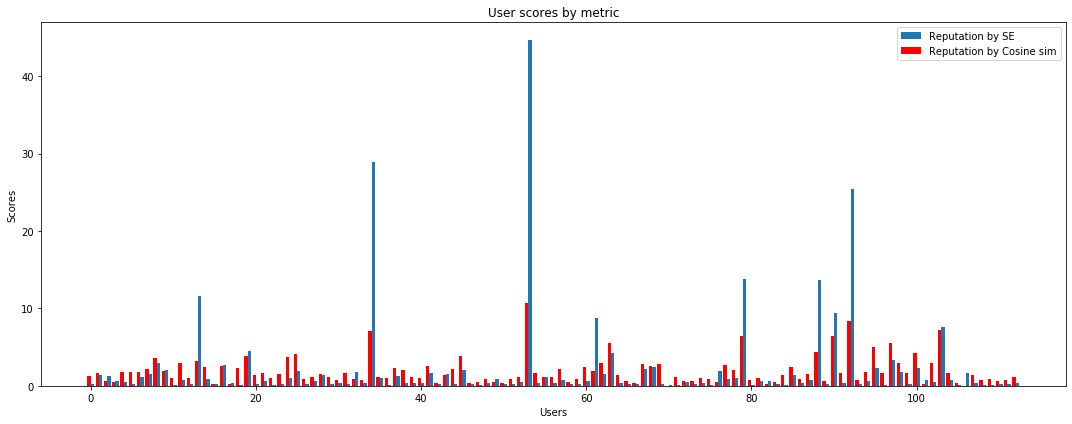

In [486]:
# normalizing the score 
# phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)

phrases_cos_expert = phrases_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / phrases_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrases_cos_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

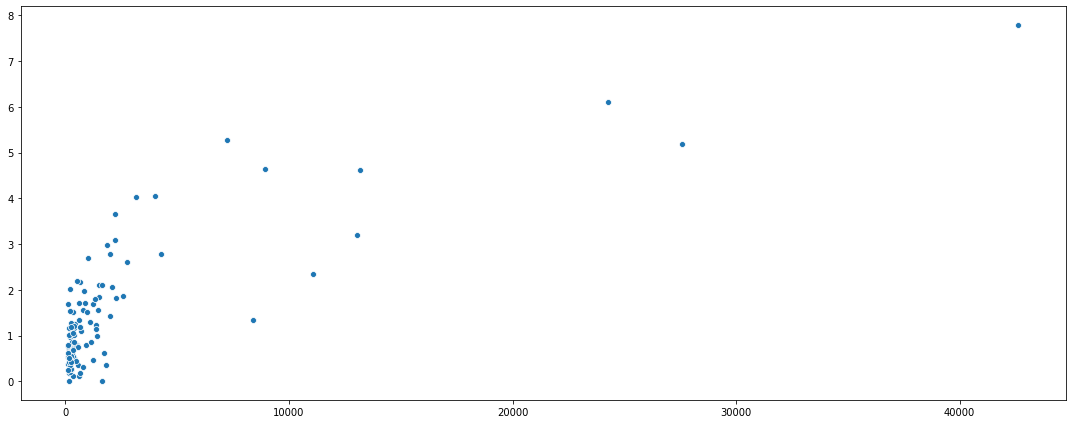

In [487]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [488]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.78716529]
 [0.78716529 1.        ]]


In [489]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [490]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, enriched_merged_book)

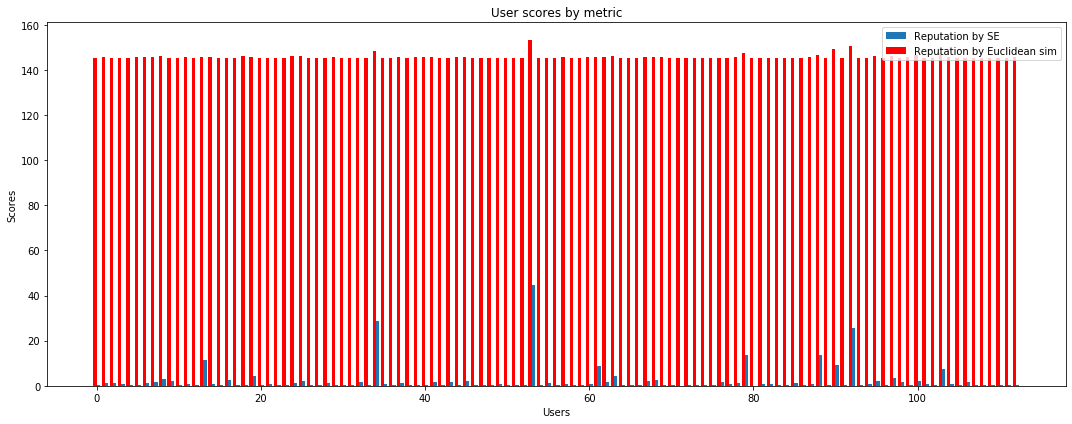

In [491]:
# normalizing the score 
# phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

phrases_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / (phrases_euclid_expert + 1)
corr_coef3 = get_corr_coef(expert_user, phrases_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

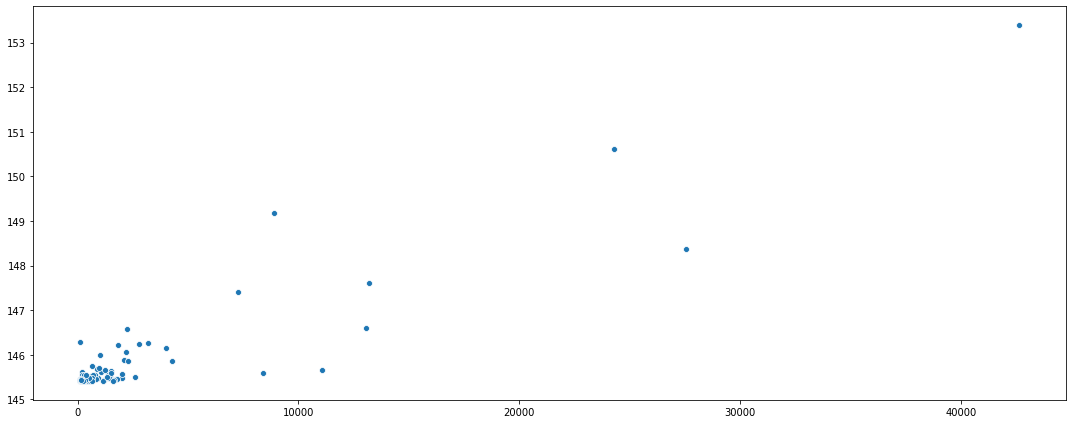

In [492]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [493]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91681854]
 [0.91681854 1.        ]]


In [494]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [495]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
enriched_merged_book = model_processing_utils.join_phrases_into_words(enriched_merged_book)

100%|██████████| 114/114 [00:01<00:00, 59.20it/s]


Jaccard similarity

In [496]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(enriched_merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

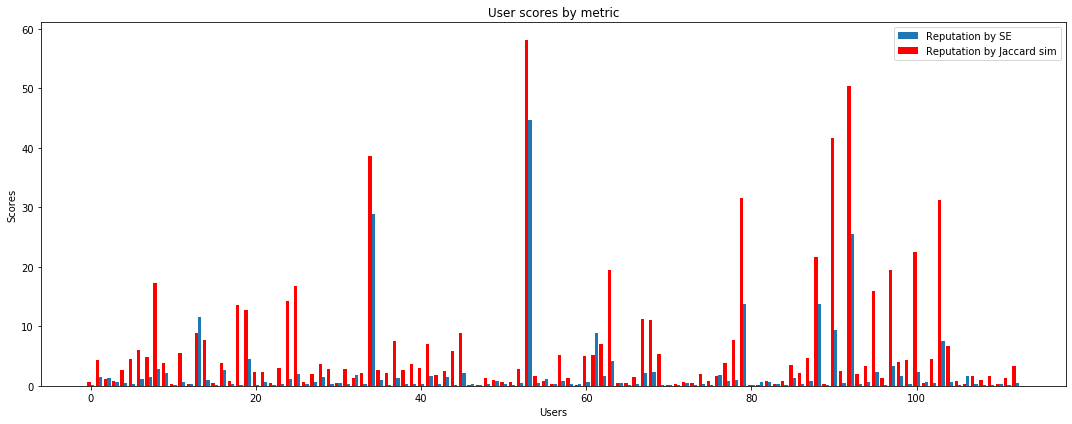

In [497]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)


words_jacc_expert = words_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

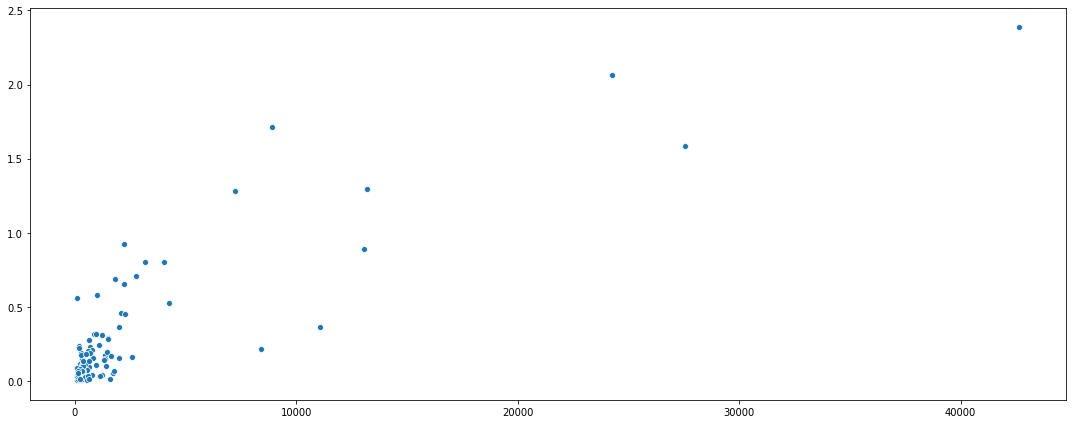

In [498]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [499]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.85432135]
 [0.85432135 1.        ]]


In [500]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [501]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, enriched_merged_book)

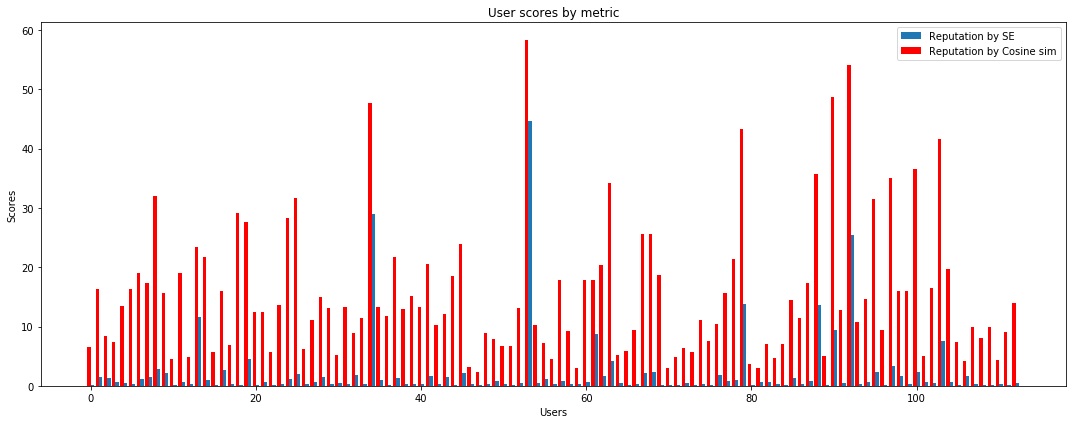

In [502]:
# normalizing the score 
# words_overal_cos_sim = metrics.min_max_normalize(words_overal_cos_sim)

words_cos_expert = words_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : words_overal_cos_sim[key]*corr_coef2 for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

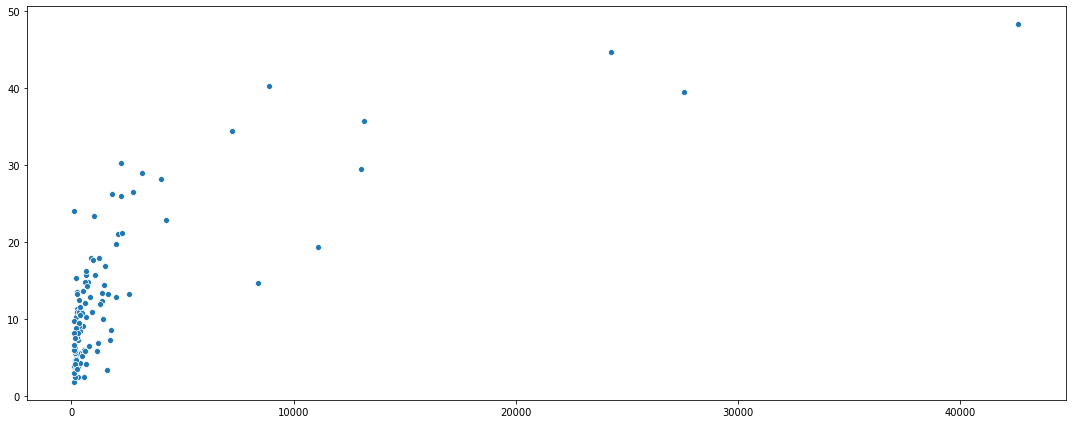

In [503]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [504]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.73061978]
 [0.73061978 1.        ]]


In [505]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [506]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, enriched_merged_book)

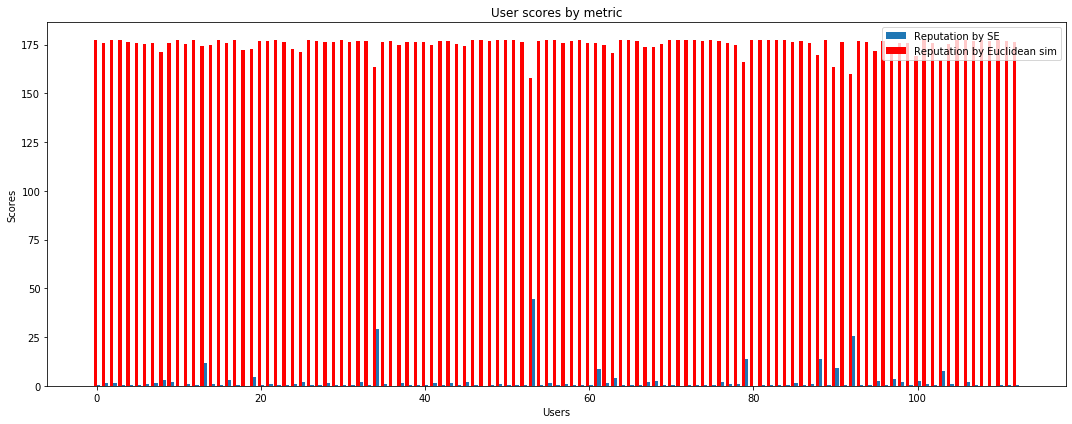

In [507]:
# normalizing the score 
# words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

words_euclid_expert = words_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / (words_euclid_expert + 1)
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

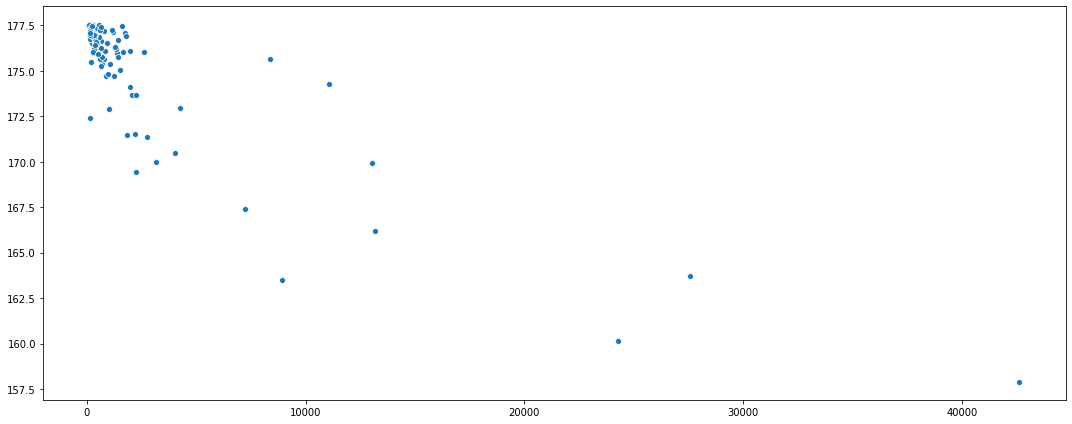

In [508]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [509]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[ 1.         -0.84878239]
 [-0.84878239  1.        ]]


In [510]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

## Evaluation between books - jls8 vs. JavaNotesForProfessionals

In [511]:
jls8_sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/jls8/acm_sub_sections", num_of_files_to_read="all")
java_notes_sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/java_notes_for_profesionals/acm_sub_sections", num_of_files_to_read="all")

100%|██████████| 630/630 [01:15<00:00,  8.08it/s]


In [512]:
model_processing_utils.join_tuples_and_lemantize(jls8_sections_book_dict)
model_processing_utils.join_tuples_and_lemantize(java_notes_sections_book_dict)

jls8_merged_book = model_processing_utils.merge_models(jls8_sections_book_dict)
java_notes_merged_book = model_processing_utils.merge_models(java_notes_sections_book_dict)

100%|██████████| 630/630 [00:00<?, ?it/s]


#### Phrases

Jaccard similarity

In [513]:
metrics.jaccard_similarity(jls8_merged_book, java_notes_merged_book)

5.28004

Cosine similarity

In [514]:
metrics.cosine_sim(jls8_merged_book, java_notes_merged_book) * 100

1003.265

Euclidean distance

In [515]:
metrics.euclid_dis(jls8_merged_book, java_notes_merged_book)

136.39281506003167

#### Words

In [516]:
jls8_merged_book = model_processing_utils.join_phrases_into_words(jls8_merged_book)
java_notes_merged_book = model_processing_utils.join_phrases_into_words(java_notes_merged_book)

Jaccard similarity

In [517]:
metrics.jaccard_similarity(jls8_merged_book, java_notes_merged_book)

3.28946

Cosine similarity

In [518]:
metrics.cosine_sim(jls8_merged_book, java_notes_merged_book) * 100

5295.849

Euclidean distance

In [519]:
metrics.euclid_dis(jls8_merged_book, java_notes_merged_book)

48.80573736764972

In [520]:
metrics.jaccard_similarity(jls8_merged_book, jls8_merged_book)

5.6984

In [521]:
metrics.jaccard_similarity(java_notes_merged_book, java_notes_merged_book)

7.19346

## Model evaluation - Comibined book (jls8 & JavaNotesForProfessionals)

### Loading the models

In [522]:
from parsing.model_evaluation import loading_models, metrics, ploting, model_processing_utils

In [523]:
# sections_book_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters") } 
jls8_sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/jls8/acm_sub_sections", num_of_files_to_read="all")
java_notes_sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/java_notes_for_profesionals/acm_sub_sections", num_of_files_to_read="all")
user_dict = loading_models.get_user_dict_from_file(r"D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers")
user_rep = loading_models.get_user_reputation_dict_from_file(r"D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\reputation\user_reputation.txt")
# acc_ans_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers") } 

100%|██████████| 181/181 [00:00<00:00, 190.16it/s]


In [524]:
z_user_score_dict1 = loading_models.get_q_a_dict_from_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores\z_scores2.txt")
z_user_score_list = list(z_user_score_dict1.keys())
user_dict = { key : val for key, val in user_dict.items() if int(key.split("userId")[1]) in z_user_score_list}
z_user_score_dict1 = { key : val for key, val in z_user_score_dict1.items() if f"userId{key}" in list(user_dict.keys())}

In [525]:
print(f"num of user models: {len(user_dict)}, num of user reps: {len(user_rep)}")

num of user models: 114, num of user reps: 13085


### Basic model testing

In [526]:
model_processing_utils.join_tuples_and_lemantize(user_dict)
model_processing_utils.join_tuples_and_lemantize(jls8_sections_book_dict)
model_processing_utils.join_tuples_and_lemantize(java_notes_sections_book_dict)

jls8_merged_book = model_processing_utils.merge_models(jls8_sections_book_dict)
java_notes_merged_book = model_processing_utils.merge_models(java_notes_sections_book_dict)

merged_book = model_processing_utils.merge_into_existing_model(jls8_merged_book, java_notes_merged_book)

present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
len(present_user_rep)

100%|██████████| 630/630 [00:00<00:00, 630948.31it/s]


114

#### Phrases

Jaccard similarity

In [527]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict[key]) for key in user_dict.keys()}

In [528]:
# phrases_overal_jacq_sim

In [529]:
phrases_overal_jacq_sim['userId1352']

4.2484

In [530]:
# normalizing the score 
# phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

In [531]:
# Reputation:
# 'userId611': 21854, 'userId2314': 27571, 'userId3249': 42615, 'userId14221': 45837, 'userId1352': 95315
# Jaccard:
# 'userId16349': 0.36975, 'userId611': 0.63611, 'userId2314': 0.82183, 'userId90149': 1.10006, 'userId14221': 1.36162, 'userId3249': 1.5441, 'userId1352': 2.70076

    

In [532]:
def calculate_file_size(dir_path):
    files = os.listdir(dir_path)
    files_size = sum(os.stat(os.path.join(dir_path, f)).st_size for f in files)
    return files_size


# using the dictionary create a dataframe and for each user/dir calculate the size of files, sort it and display the df
def get_sorted_file_list_by_size(metric_dict1, root_path):
    df = pd.DataFrame(list(metric_dict1.items()), columns=['UserID', 'Metric score'])
    df['file_size'] = df.apply(lambda x: calculate_file_size(os.path.join(root_path, str(x['UserID']))), axis=1)
    df = df.sort_values(by=['file_size'], ascending=False)
    return df
    

In [533]:
from parsing.model_evaluation.metrics import get_sorted_dicts, calculate_order_score, calculate_max_deviation, calculate_mean_deviation, calculate_total_deviation

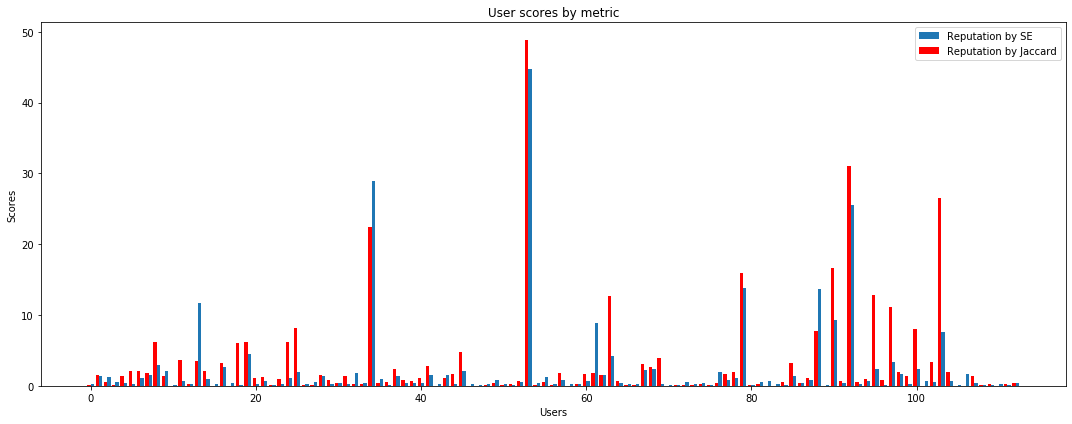

In [534]:
phrases_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')
present_user_rep.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / phrases_jacc_expert
corr_coef = get_corr_coef(expert_user, phrases_jacc_expert)



# corr_coef = present_user_rep['userId1352']/phrases_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in metrics.min_max_normalize(phrases_overal_jacq_sim)}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard")

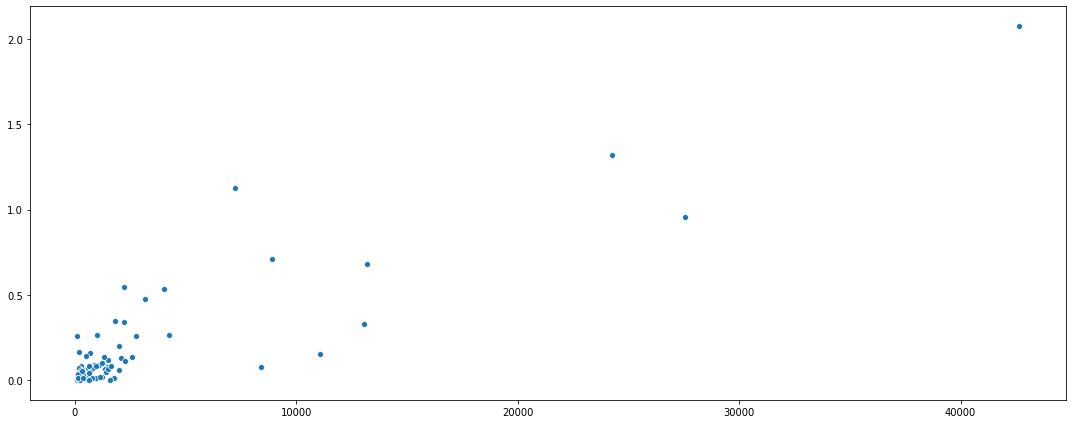

In [535]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [536]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.         0.89051034]
 [0.89051034 1.        ]]


In [537]:
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

In [538]:
# Z score
# 1352: 28.896449047944508,
# 79256: 7.216053531635459,
# 8500: 6.563924617405255,
# 1813: 4.458963213705229,
# 66: 4.458892287340829,
# 3922: 4.426352063787131,
# 24912: 4.024922359499621,
# 91249: 2.5298221281347035,
# 82: 2.523573072576179,

Checking if our model isnt biased by the size of user models

In [539]:
df = get_sorted_file_list_by_size(phrases_overal_jacq_sim, "D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\answers")

In [540]:
df.head(20)

,UserID,Metric score,file_size
53,userId3249,2.07625,192201
92,userId7167,1.31899,110915
90,userId7080,0.70877,79009
34,userId2314,0.95456,70386
103,userId90992,1.12846,54876
79,userId5692,0.67960,51428
100,userId8500,0.34135,26354
88,userId66,0.33103,26119
97,userId79256,0.47526,25411
63,userId39690,0.53618,22454


Doesnt look like it - first 3 positions match but the rest not 

Cosine similarity

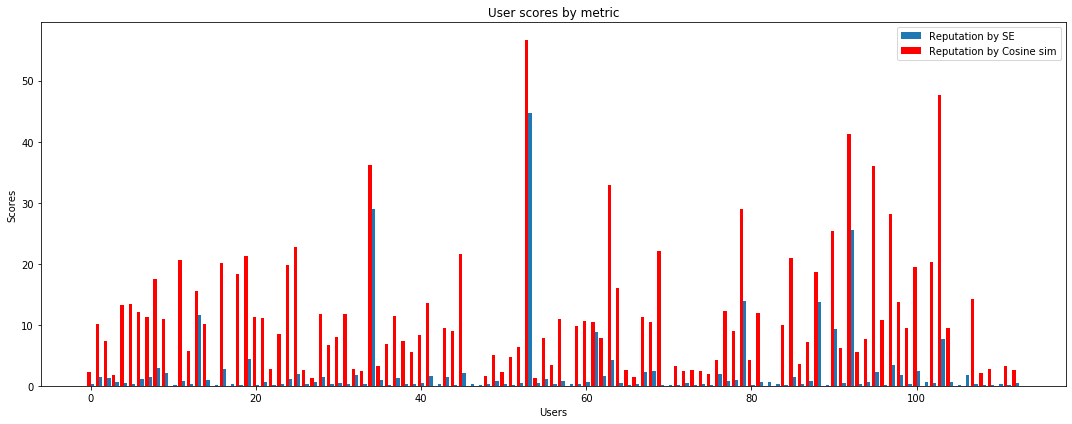

In [541]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, merged_book)

# normalizing the score 
# phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)


phrases_cos_expert = phrases_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / phrases_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrases_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/phrases_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

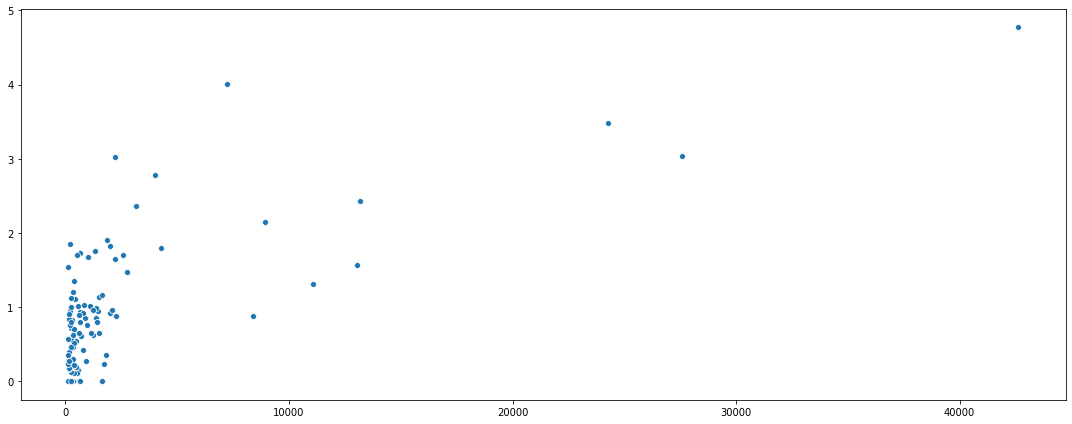

In [542]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [543]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.70141593]
 [0.70141593 1.        ]]


In [544]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

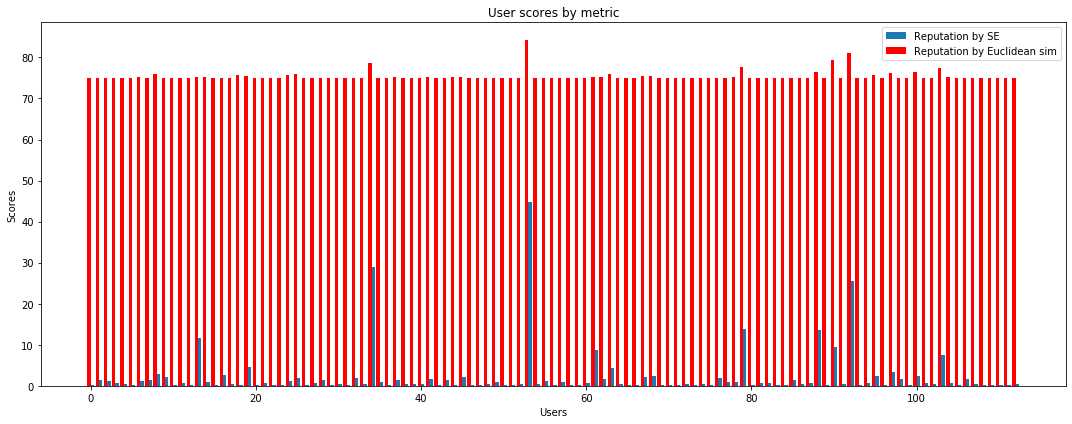

In [545]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, merged_book)

# normalizing the score 
# phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

phrases_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / phrases_euclid_expert
corr_coef3 = get_corr_coef(expert_user, phrases_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/phrases_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

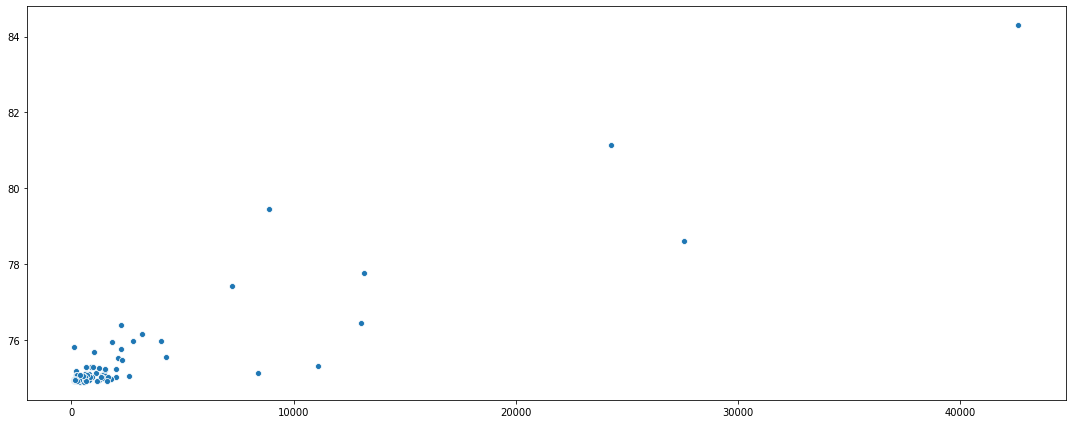

In [546]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [547]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91958596]
 [0.91958596 1.        ]]


In [548]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [549]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
merged_book = model_processing_utils.join_phrases_into_words(merged_book)

100%|██████████| 114/114 [00:01<00:00, 60.28it/s]


In [550]:
len(user_dict_words['userId11200'])

252

In [551]:
len(merged_book)

39280

Jaccard similarity

In [552]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

In [553]:
# normalizing the score 
# words_overal_jacq_sim = metrics.min_max_normalize(words_overal_jacq_sim)

In [554]:
words_overal_jacq_sim['userId1352']

2.59793

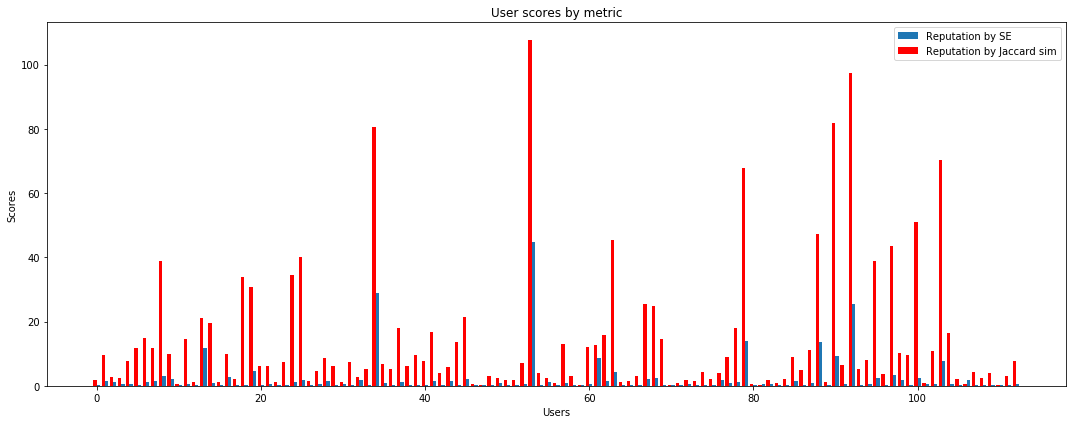

In [555]:
words_jacc_expert = words_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef = present_user_rep['userId1352']/words_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

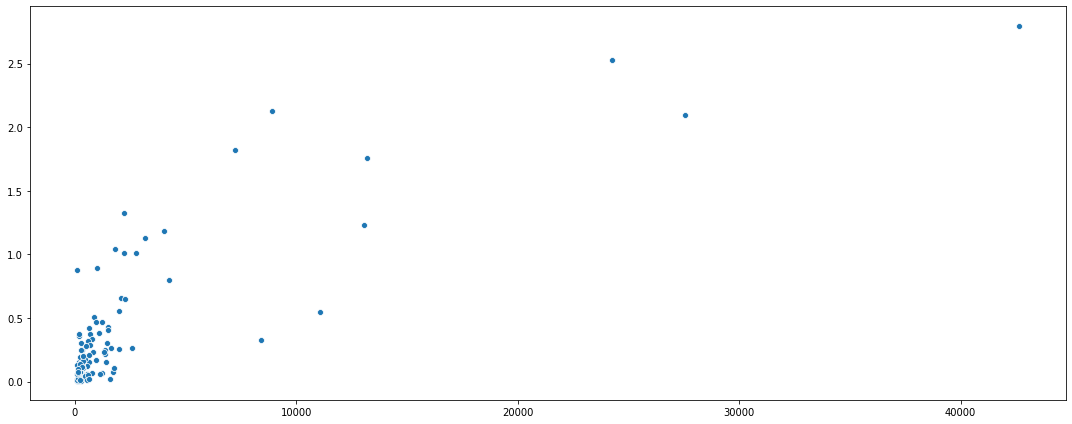

In [556]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [557]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.81820045]
 [0.81820045 1.        ]]


In [558]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [559]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, merged_book)

In [560]:
# normalizing the score 
# words_overal_cos_sim = metrics.min_max_normalize(words_overal_cos_sim)

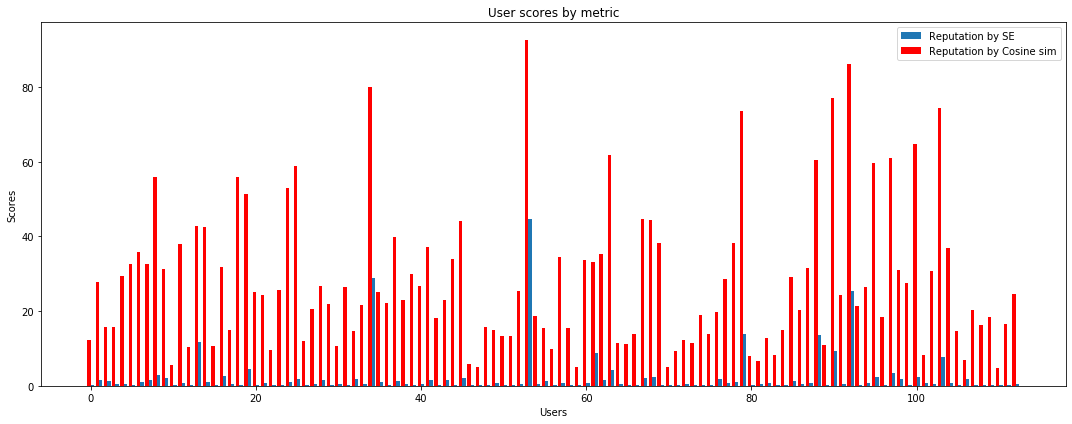

In [561]:
words_cos_expert = words_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/words_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : words_overal_cos_sim[key]*corr_coef2 for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

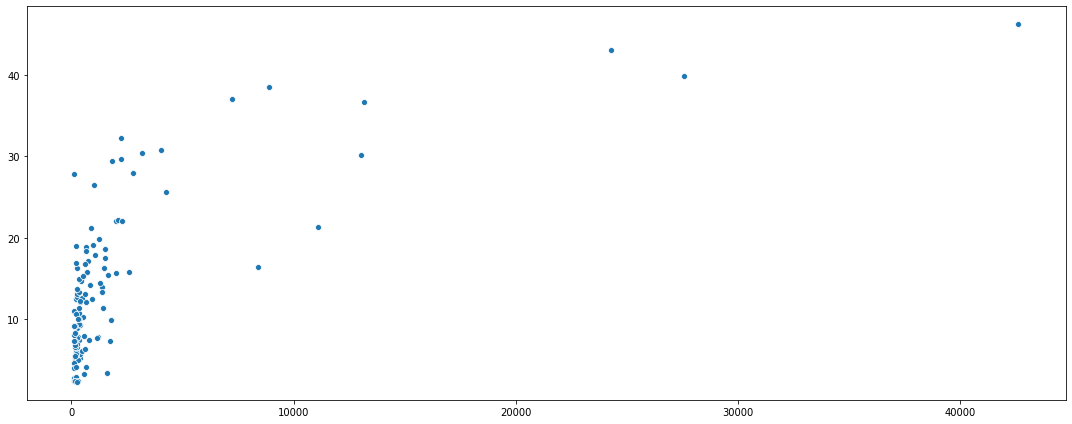

In [562]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [563]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.68221037]
 [0.68221037 1.        ]]


In [564]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [565]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, merged_book)

In [566]:
# normalizing the score 
# words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

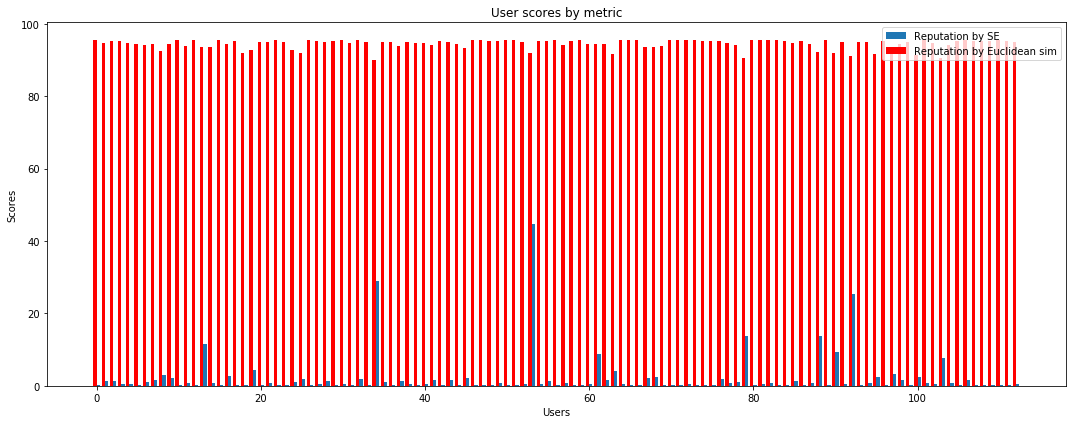

In [567]:
words_euclid_expert = words_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / words_euclid_expert
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

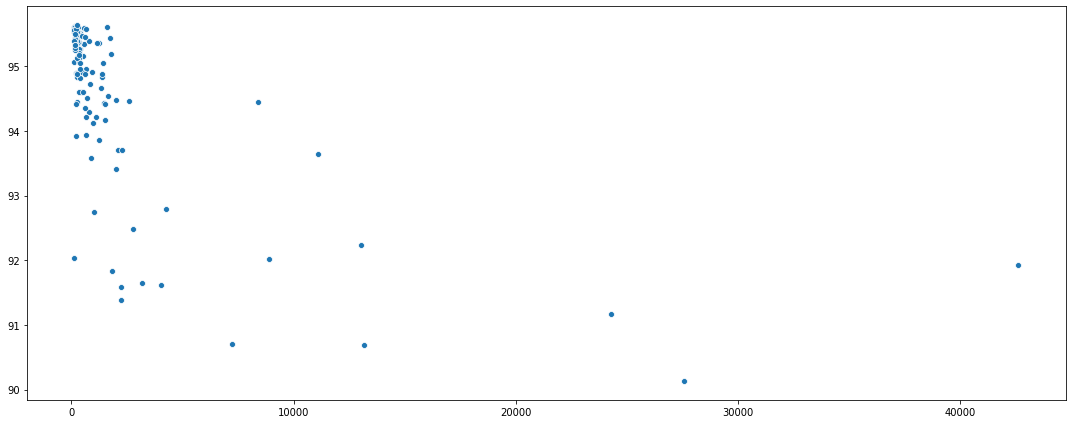

In [568]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [569]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[ 1.         -0.61305594]
 [-0.61305594  1.        ]]


In [570]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

### Model testing with transformation

In [571]:
from parsing.model_evaluation import loading_models, metrics, ploting, model_processing_utils

In [572]:
# sections_book_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters") } 
jls8_sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/jls8/acm_sub_sections", num_of_files_to_read="all")
java_notes_sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/java_notes_for_profesionals/acm_sub_sections", num_of_files_to_read="all")
user_dict = loading_models.get_user_dict_from_file(r"D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers")
user_rep = loading_models.get_user_reputation_dict_from_file(r"D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\reputation\user_reputation.txt")
# acc_ans_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers") } 

100%|██████████| 181/181 [00:00<00:00, 188.80it/s]


In [573]:
z_user_score_dict1 = loading_models.get_q_a_dict_from_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores\z_scores2.txt")
z_user_score_list = list(z_user_score_dict1.keys())
user_dict = { key : val for key, val in user_dict.items() if int(key.split("userId")[1]) in z_user_score_list}
z_user_score_dict1 = { key : val for key, val in z_user_score_dict1.items() if f"userId{key}" in list(user_dict.keys())}

In [574]:
print(f"num of user models: {len(user_dict)}, num of user reps: {len(user_rep)}")

num of user models: 114, num of user reps: 13085


In [575]:
model_processing_utils.join_tuples_and_lemantize(user_dict)
model_processing_utils.join_tuples_and_lemantize(jls8_sections_book_dict)
model_processing_utils.join_tuples_and_lemantize(java_notes_sections_book_dict)

jls8_merged_book = model_processing_utils.merge_models(jls8_sections_book_dict)
java_notes_merged_book = model_processing_utils.merge_models(java_notes_sections_book_dict)

merged_book = model_processing_utils.merge_into_existing_model(jls8_merged_book, java_notes_merged_book)

present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
len(present_user_rep)

100%|██████████| 630/630 [00:00<00:00, 630195.93it/s]


114

Define the transformations

In [576]:
transform_funcs = {
    "square_root" : lambda x: x**0.25,
    "pow2" : lambda x: x**2,
    # "log" : lambda x: math.log(x)
}

transform_key = "square_root"

#### Phrases

Jaccard similarity

In [577]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict[key]) for key in user_dict.keys()}

Applying the transformation

In [578]:
phrases_overal_jacq_sim = { key : transform_funcs[transform_key](phrases_overal_jacq_sim[key]) for key in phrases_overal_jacq_sim.keys()}

In [579]:
phrases_overal_jacq_sim['userId1352']

1.4356757012915151

In [580]:
# Reputation:
# 'userId611': 21854, 'userId2314': 27571, 'userId3249': 42615, 'userId14221': 45837, 'userId1352': 95315
# Jaccard:
# 'userId16349': 0.36975, 'userId611': 0.63611, 'userId2314': 0.82183, 'userId90149': 1.10006, 'userId14221': 1.36162, 'userId3249': 1.5441, 'userId1352': 2.70076

    

In [581]:
def calculate_file_size(dir_path):
    files = os.listdir(dir_path)
    files_size = sum(os.stat(os.path.join(dir_path, f)).st_size for f in files)
    return files_size


# using the dictionary create a dataframe and for each user/dir calculate the size of files, sort it and display the df
def get_sorted_file_list_by_size(metric_dict1, root_path):
    df = pd.DataFrame(list(metric_dict1.items()), columns=['UserID', 'Metric score'])
    df['file_size'] = df.apply(lambda x: calculate_file_size(os.path.join(root_path, str(x['UserID']))), axis=1)
    df = df.sort_values(by=['file_size'], ascending=False)
    return df
    

In [582]:
from parsing.model_evaluation.metrics import get_sorted_dicts, calculate_order_score, calculate_max_deviation, calculate_mean_deviation, calculate_total_deviation

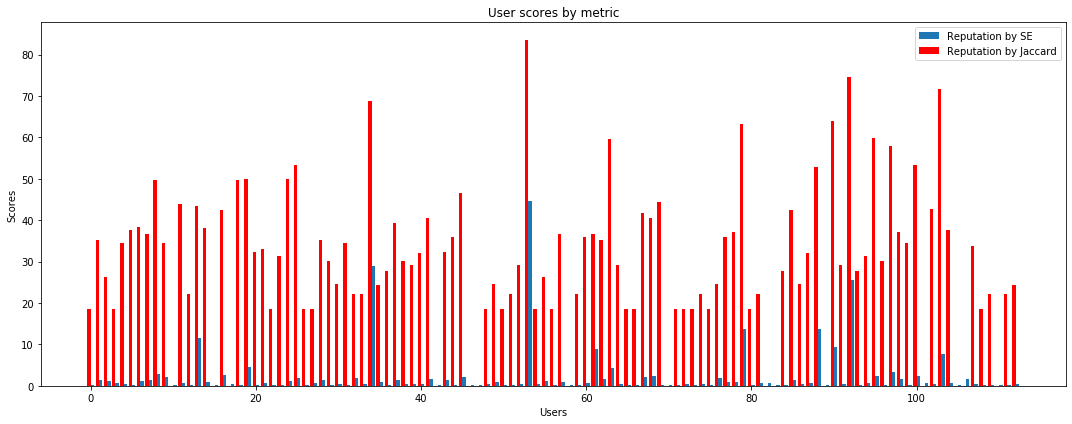

In [583]:
phrases_jacc_expert = phrases_overal_jacq_sim.pop('userId1352')
present_user_rep.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / phrases_jacc_expert
corr_coef = get_corr_coef(expert_user, phrases_jacc_expert)


# corr_coef = present_user_rep['userId1352']/phrases_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : phrases_overal_jacq_sim[key]*corr_coef for key in phrases_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard")

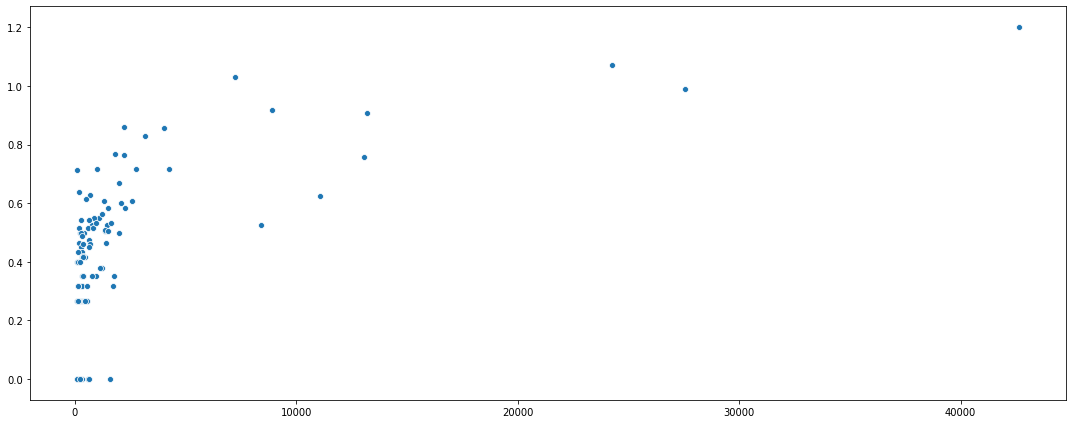

In [584]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [585]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.         0.59193745]
 [0.59193745 1.        ]]


In [586]:
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

In [587]:
# Z score
# 1352: 28.896449047944508,
# 79256: 7.216053531635459,
# 8500: 6.563924617405255,
# 1813: 4.458963213705229,
# 66: 4.458892287340829,
# 3922: 4.426352063787131,
# 24912: 4.024922359499621,
# 91249: 2.5298221281347035,
# 82: 2.523573072576179,

Checking if our model isnt biased by the size of user models

In [588]:
df = get_sorted_file_list_by_size(phrases_overal_jacq_sim, "D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\answers")

In [589]:
df.head(20)

,UserID,Metric score,file_size
53,userId3249,1.200383,192201
92,userId7167,1.071668,110915
90,userId7080,0.917543,79009
34,userId2314,0.988441,70386
103,userId90992,1.030675,54876
79,userId5692,0.907953,51428
100,userId8500,0.764364,26354
88,userId66,0.758520,26119
97,userId79256,0.830296,25411
63,userId39690,0.855712,22454


Doesnt look like it - first 3 positions match but the rest not 

Cosine similarity

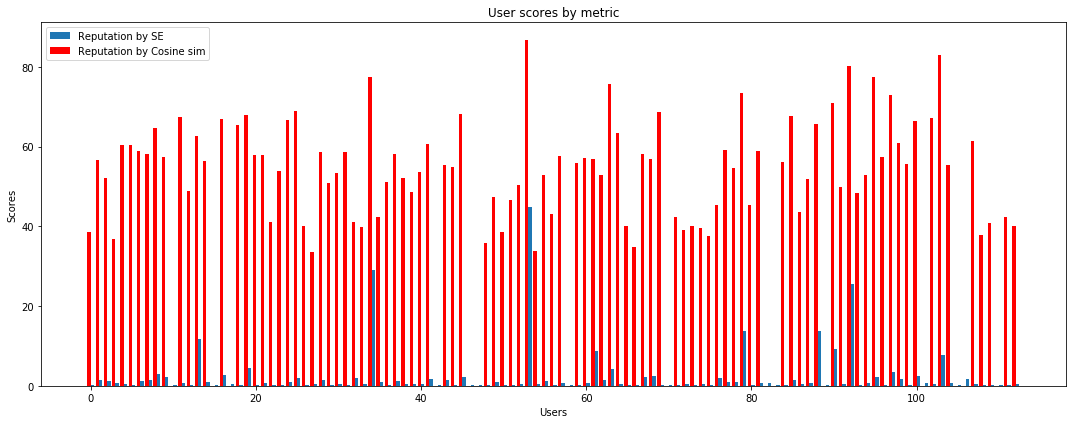

In [590]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, merged_book)

# transformation
phrases_overal_cos_sim = { key : transform_funcs[transform_key](phrases_overal_cos_sim[key]) for key in phrases_overal_cos_sim.keys()}

phrases_cos_expert = phrases_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / phrases_cos_expert
corr_coef2 = get_corr_coef(expert_user, phrases_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/phrases_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : phrases_overal_cos_sim[key]*corr_coef2 for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

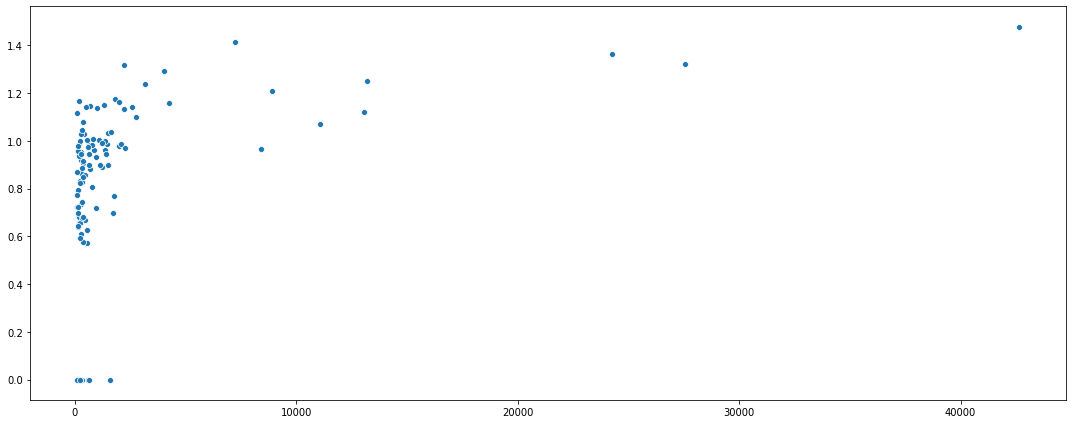

In [591]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [592]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.38294013]
 [0.38294013 1.        ]]


In [593]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

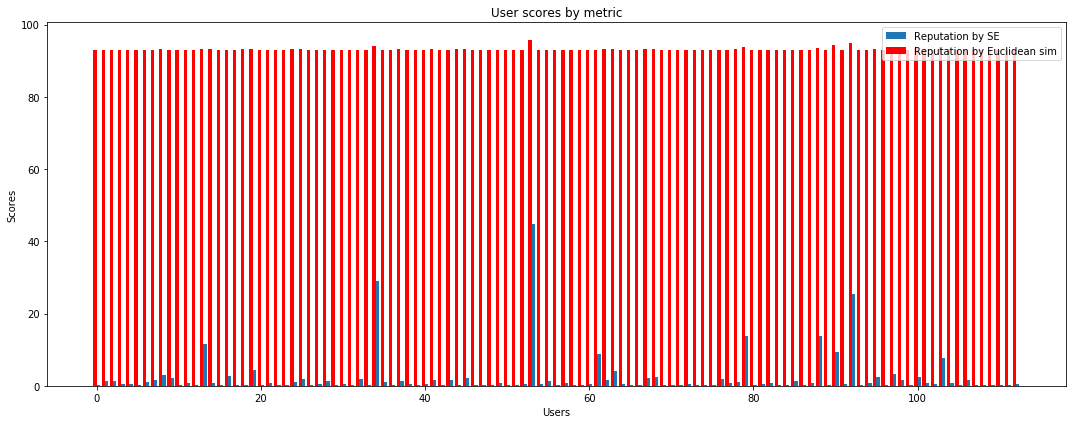

In [594]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, merged_book)


# transformation
phrases_overal_euclid_sim = { key : transform_funcs[transform_key](phrases_overal_euclid_sim[key]) for key in phrases_overal_euclid_sim.keys()}

# normalizing the score 
# phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

phrases_euclid_expert = phrases_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / phrases_euclid_expert
corr_coef3 = get_corr_coef(expert_user, phrases_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/phrases_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : phrases_overal_euclid_sim[key]*corr_coef3 for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

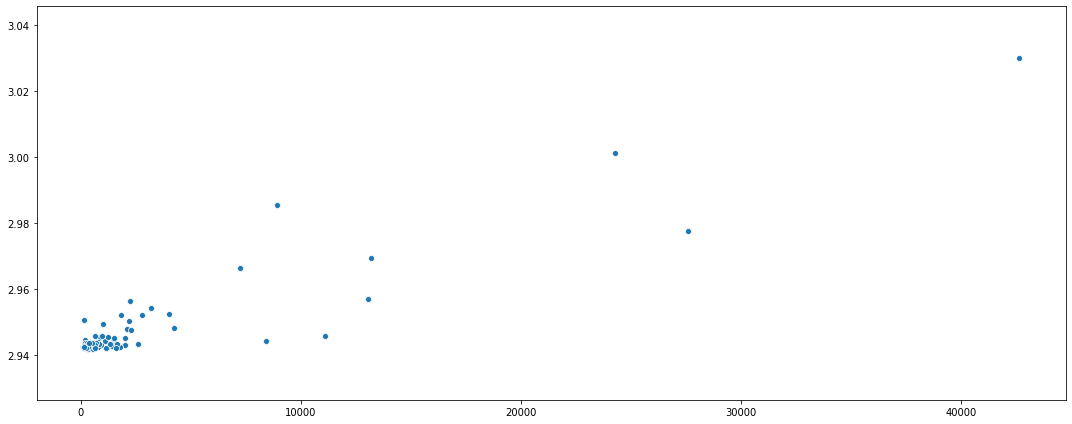

In [595]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [596]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.91875132]
 [0.91875132 1.        ]]


In [597]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

#### Words

In [598]:
user_dict_words = model_processing_utils.join_phrases_into_words(user_dict, "users")
merged_book = model_processing_utils.join_phrases_into_words(merged_book)

100%|██████████| 114/114 [00:01<00:00, 58.47it/s]


In [599]:
len(user_dict_words['userId11200'])

252

In [600]:
len(merged_book)

39280

Jaccard similarity

In [601]:
words_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict_words[key]) for key in user_dict_words.keys()}

In [602]:
words_overal_jacq_sim['userId1352']

2.59793

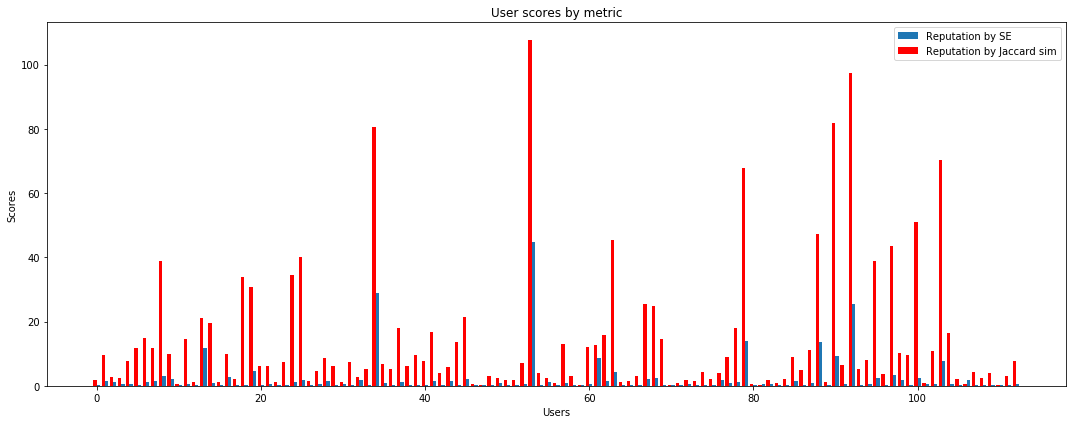

In [603]:
words_jacc_expert = words_overal_jacq_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef = expert_user / words_jacc_expert
corr_coef = get_corr_coef(expert_user, words_jacc_expert)


# corr_coef = present_user_rep['userId1352']/words_overal_jacq_sim['userId1352']
scaled_user_rep = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_jacc_rep = {key : words_overal_jacq_sim[key]*corr_coef for key in words_overal_jacq_sim}
ploting.plot_vals(val_dict1=scaled_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard sim")

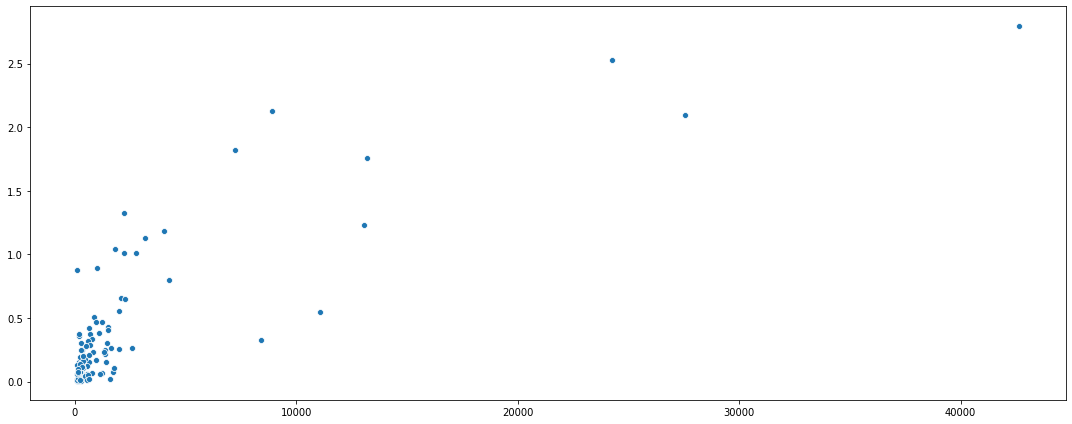

In [604]:
np_words_jacq_sim = np.array(list(words_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_words_jacq_sim)

In [605]:
my_rho = np.corrcoef(np_user_rep, np_words_jacq_sim)
print(my_rho)

[[1.         0.81820045]
 [0.81820045 1.        ]]


In [606]:
# calculate_order_score(words_overal_jacq_sim, present_user_rep)
print(calculate_order_score(words_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(words_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Cosine similarity

In [607]:
words_overal_cos_sim = metrics.get_cosine_sim(user_dict_words, merged_book)

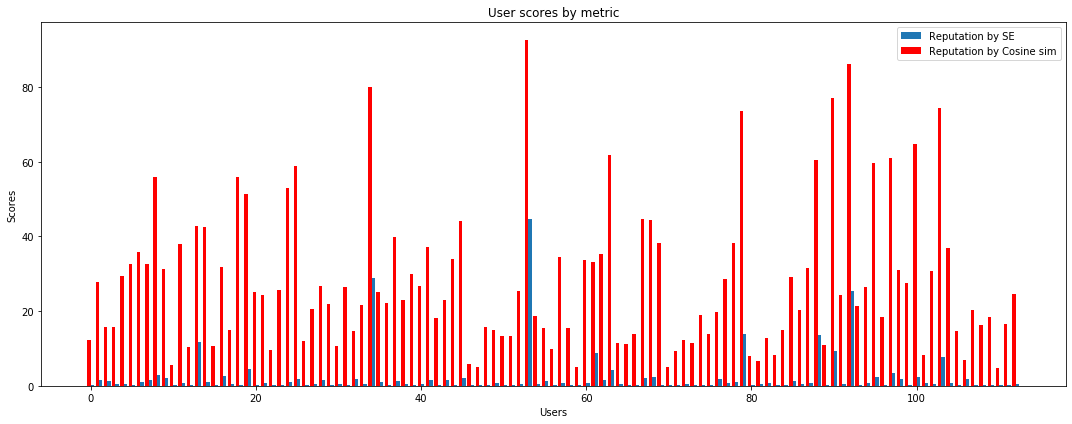

In [608]:
words_cos_expert = words_overal_cos_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef2 = expert_user / words_cos_expert
corr_coef2 = get_corr_coef(expert_user, words_cos_expert)


# corr_coef2 = present_user_rep['userId1352']/words_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_cos_rep = {key : words_overal_cos_sim[key]*corr_coef2 for key in words_overal_cos_sim}
ploting.plot_vals(val_dict1=scaled_user_rep2, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

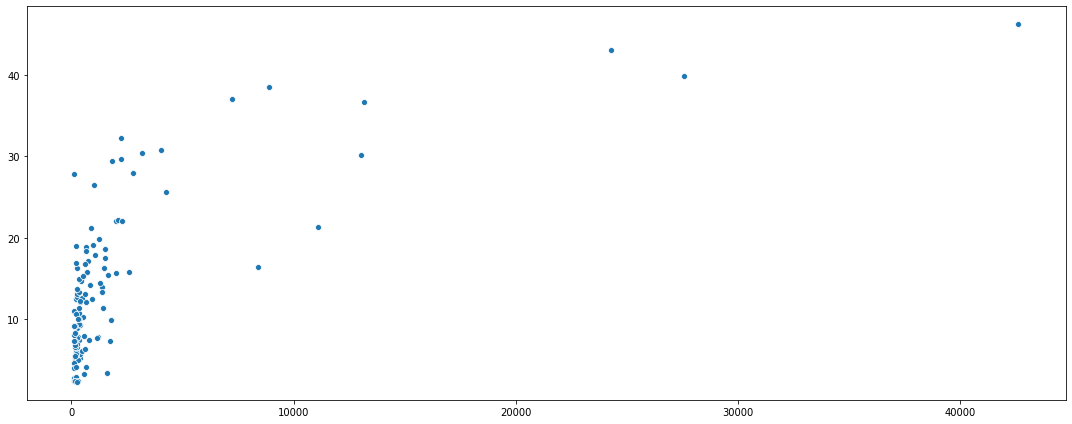

In [609]:
np_words_cos_sim = np.array(list(words_overal_cos_sim.values()))

sb.scatterplot(np_user_rep, np_words_cos_sim)

In [610]:
my_rho = np.corrcoef(np_user_rep, np_words_cos_sim)
print(my_rho)

[[1.         0.68221037]
 [0.68221037 1.        ]]


In [611]:
# calculate_order_score(words_overal_cos_sim, present_user_rep)
print(calculate_order_score(words_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(words_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

In [612]:
words_overal_euclid_sim = metrics.get_euclid_dis(user_dict_words, merged_book)

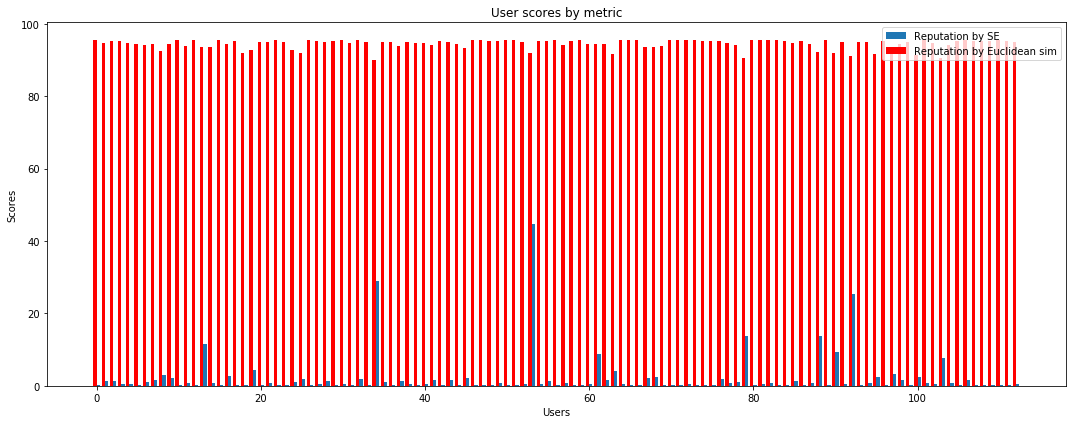

In [613]:
# normalizing the score 
# words_overal_euclid_sim = metrics.min_max_normalize(words_overal_euclid_sim)

words_euclid_expert = words_overal_euclid_sim.pop('userId1352')
# corr_coef2 = expert_user / phrases_cos_expert

# corr_coef3 = expert_user / words_euclid_expert
corr_coef3 = get_corr_coef(expert_user, words_euclid_expert)


# corr_coef3 = present_user_rep['userId1352']/words_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : ((present_user_rep[key]/expert_user)*100) for key in present_user_rep}
scaled_euclid_rep = {key : words_overal_euclid_sim[key]*corr_coef3 for key in words_overal_euclid_sim}
ploting.plot_vals(val_dict1=scaled_user_rep3, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

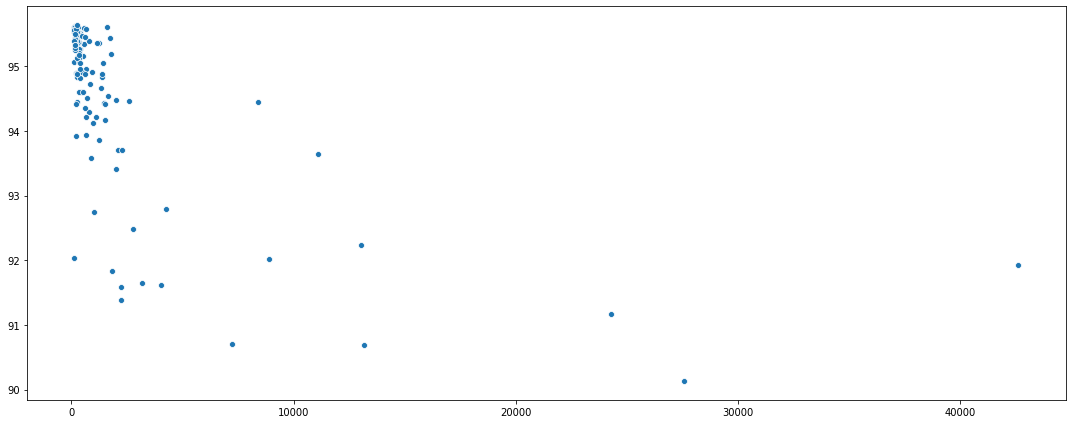

In [614]:
np_words_euclid_sim = np.array(list(words_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_words_euclid_sim)

In [615]:
my_rho = np.corrcoef(np_user_rep, np_words_euclid_sim)
print(my_rho)

[[ 1.         -0.61305594]
 [-0.61305594  1.        ]]


In [616]:
# calculate_order_score(words_overal_euclid_sim, present_user_rep)
print(calculate_order_score(words_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(words_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(words_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

## Z score

In [617]:
q_a_dictionary = loading_models.get_q_a_dict_from_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores\z_scores3.txt")

In [618]:
user_rep = loading_models.get_user_reputation_dict_from_file(r"D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\reputation\user_reputation.txt")

In [619]:
z_score_equation = lambda q, a: (a - q)/((a + q)**0.5) 

def calculate_z_score(q_a_dict):
    for key, val in q_a_dict.items():
        # q , a
        print(f"user : {key}, z-score: {z_score_equation(val[0], val[1])}")

In [620]:
user_rep['1352']

95315

In [621]:
z_score_dict = {user_id : z_score_equation(q, a) for user_id, (q, a) in q_a_dictionary.items()}
present_user_rep = { key : user_rep[str(key)] for key in z_score_dict.keys()}

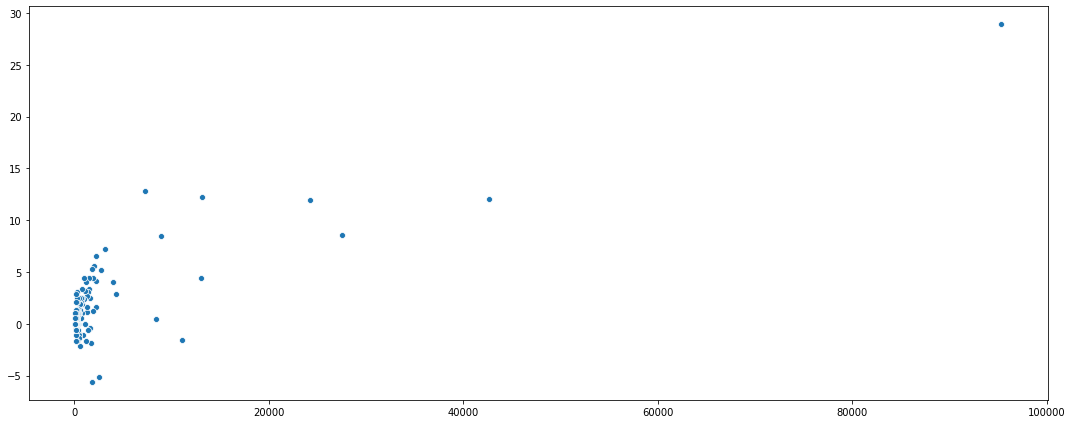

In [622]:
np_user_rep = np.array(list(present_user_rep.values()))
np_z_score = np.array(list(z_score_dict.values()))

sb.scatterplot(np_user_rep, np_z_score)

In [623]:
my_rho = np.corrcoef(np_user_rep, np_z_score)
print(my_rho)

[[1.         0.80500592]
 [0.80500592 1.        ]]


In [624]:
sorted_z_score_dict, present_user_rep = get_sorted_dicts(z_score_dict, present_user_rep)

In [625]:
user_rep.get('1352')

95315

In [626]:
calculate_order_score(sorted_z_score_dict, present_user_rep)
calculate_max_deviation(sorted_z_score_dict, present_user_rep)
calculate_mean_deviation(sorted_z_score_dict, present_user_rep)
calculate_total_deviation(sorted_z_score_dict, present_user_rep, corr_coef)

reference list: [57681, 48538, 24681, 92366, 282899, 146161, 97556, 94922, 125350, 61731, 77009, 54786, 173159, 48295, 98498, 315606, 6703, 13937, 155976, 47207, 49377, 271094, 43607, 101210, 19232, 59603, 280963, 73424, 97857, 227552, 43880, 3766, 260713, 311114, 127226, 18006, 106835, 8369, 201816, 37721, 34175, 29472, 94044, 51550, 251840, 144, 6330, 230189, 25015, 255048, 42267, 3354, 9915, 223337, 71391, 104231, 31706, 49207, 86778, 19256, 57752, 102854, 3801, 5879, 7610, 16868, 8586, 91249, 126703, 63475, 34380, 30302, 54997, 13021, 238259, 55875, 1813, 10935, 33851, 1028, 24912, 62100, 19697, 10190, 26547, 11200, 3922, 2554, 9274, 82, 23010, 5487, 187465, 27540, 121080, 4603, 76809, 8500, 4662, 139925, 1177, 79256, 39690, 147, 90992, 38223, 7080, 12750, 66, 5692, 7167, 2314, 3249, 1352]
metric list: [5487, 139925, 102854, 23010, 1028, 101210, 311114, 12750, 49207, 238259, 19256, 43880, 57752, 26547, 25015, 280963, 98498, 9274, 97857, 73424, 33851, 223337, 42267, 51550, 94044, 37

2830

## Matching experiment

In this experiment we want to try to match to which parts of the book the users most match with their answers. First we load the base models for the jls8 book and the java notes book.

In [627]:
from parsing.model_evaluation import loading_models, metrics, ploting, model_processing_utils

In [628]:
jls8_sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/jls8/acm_sub_sections", num_of_files_to_read="all")
java_notes_sections_book_dict = loading_models.get_list_from_file(dir_path="D:/Skola/Skola-ing/DP/data/parsed_data/acm_books/java_notes_for_profesionals/acm_sub_sections", num_of_files_to_read="all")
user_dict = loading_models.get_user_dict_from_file(r"D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers")

100%|██████████| 181/181 [00:00<00:00, 189.04it/s]


In [629]:
z_user_score_dict1 = loading_models.get_q_a_dict_from_file("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\z_scores\z_scores2.txt")
z_user_score_list = list(z_user_score_dict1.keys())
user_dict = { key : val for key, val in user_dict.items() if int(key.split("userId")[1]) in z_user_score_list}
z_user_score_dict1 = { key : val for key, val in z_user_score_dict1.items() if f"userId{key}" in list(user_dict.keys())}

In [630]:
# print(f"num of user models: {len(user_dict)}, num of user reps: {len(user_rep)}")

In [631]:
model_processing_utils.join_tuples_and_lemantize(user_dict)
model_processing_utils.join_tuples_and_lemantize(jls8_sections_book_dict)
model_processing_utils.join_tuples_and_lemantize(java_notes_sections_book_dict)

# jls8_merged_book = model_processing_utils.merge_models(jls8_sections_book_dict)
# java_notes_merged_book = model_processing_utils.merge_models(java_notes_sections_book_dict)

# merged_book = model_processing_utils.merge_into_existing_model(jls8_merged_book, java_notes_merged_book)

# present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
# len(present_user_rep)

100%|██████████| 630/630 [00:08<00:00, 74.62it/s]


In [632]:
key_list1 = list(jls8_sections_book_dict.keys())
key_list2 = list(java_notes_sections_book_dict.keys())

In [633]:
# key_list2 = map(lambda key: re.sub(r"Chapter|Section", "", key), key_list2)


In [634]:
# pattern = re.compile(r'\s+|\t+')
# key_list2 = [re.sub(pattern, '', key) for key in key_list2]

In [635]:
key_list2

['Chapter 10&Section 10.1&Section 10.2',
 'Chapter 100&Section 100.1',
 'Chapter 101&Section 101.1',
 'Chapter 102&Section 102.1&Section 102.2',
 'Chapter 103&Section 103.1',
 'Chapter 104&Section 104.1&Section 104.2',
 'Chapter 105&Section 105.1',
 'Chapter 106&Section 106.1',
 'Chapter 107&Section 107.1',
 'Chapter 108&Section 108.1',
 'Chapter 109&Section 109.1&Section 109.2',
 'Chapter 11&Section 11.1',
 'Chapter 110&Section 110.1',
 'Chapter 111&Section 111.1',
 'Chapter 112&Section 112.1',
 'Chapter 113&Section 113.1&Section 113.2',
 'Chapter 114&Section 114.1&Section 114.2',
 'Chapter 115&Section 115.1',
 'Chapter 116&Section 116.1&Section 116.2',
 'Chapter 117&Section 117.1',
 'Chapter 118&Section 118.1&Section 118.2',
 'Chapter 119&Section 119.1&Section 119.2',
 'Chapter 12&Section 12.1',
 'Chapter 120&Section 120.1',
 'Chapter 121&Section 121.1',
 'Chapter 122&Section 122.1',
 'Chapter 123&Section 123.1',
 'Chapter 124&Section 124.1',
 'Chapter 125&Section 125.1',
 'Chapter 1

In [636]:
section_list1 = [int(key.split("&")[0].split(".")[0]) for key in key_list1]
section_list2 = [int(key.split("&")[0].split(" ")[1].split(".")[0]) for key in key_list2]

In [637]:
section_list2

[10,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 11,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 12,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 13,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 14,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 15,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 16,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 17,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 18,
 180,
 181,
 19,
 2,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 3,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 4,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 5,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 6,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 7,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 8,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 9,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 1,
 10,
 10,
 10,
 10,
 1

In [638]:
combined_dict1 = dict(zip(key_list1, section_list1))
combined_dict2 = dict(zip(key_list2, section_list2))

In [639]:
# combined_dict2

In [640]:
jls8_section_df = pd.DataFrame(list(combined_dict1.items()), columns=["sub_sections", "sections"])
java_notes_section_df = pd.DataFrame(list(combined_dict2.items()), columns=["sub_sections", "sections"])

In [641]:
java_notes_section_df

,sub_sections,sections
0,Chapter 10&Section 10.1&Section 10.2,10
1,Chapter 100&Section 100.1,100
2,Chapter 101&Section 101.1,101
3,Chapter 102&Section 102.1&Section 102.2,102
4,Chapter 103&Section 103.1,103
...,...,...
625,Section 97.3&Section 97.4&Section 97.5,97
626,Section 97.6&Section 97.7,97
627,Section 97.8,97
628,Section 98.2,98


In [642]:
sec_list1 = sorted(list(jls8_section_df['sections'].unique()))
sec_list2 = sorted(list(java_notes_section_df['sections'].unique()))


In [643]:
sec_list2[-1]

181

In [644]:
jls8_section_df.loc[jls8_section_df['sections'] == 1]

,sub_sections,sections
0,1.1,1
1,1.2.&1.3,1
2,1.4.&1.5.&1.6.&Bibliography,1
3,1,1


In [645]:
# def merge_sub_sec_into_sec(sec_df, book_dict):
#     section_list = sorted(list(sec_df['sections'].unique()))
#     top_range = section_list[-1]

#     section_dict = {}

#     for sec in range(1, top_range + 1):
#         local_df = sec_df.loc[sec_df['sections'] == sec]
#         local_phrase_list = []

#         for row in local_df['sub_sections']:
#             sub_sec_key = row
#             local_phrase_list += book_dict[str(sub_sec_key)]
            
#         deduplicated_phrase_list = model_processing_utils.merge_into_existing_model([], local_phrase_list)
#         section_dict[sec] = deduplicated_phrase_list

#     return section_dict

In [646]:
jls8_sections_dict =  model_processing_utils.merge_sub_sec_into_sec(jls8_section_df, jls8_sections_book_dict)
java_notes_sections_dict =  model_processing_utils.merge_sub_sec_into_sec(java_notes_section_df,java_notes_sections_book_dict)

In [647]:
# jls8_sections_dict[1]

In [648]:
java_notes_sections_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181])

In [649]:
jls8_overal_sim = {}
java_notes_overal_sim = {}
jls8_match_df = {}
java_notes_match_df = {}

In [650]:
jls8_overal_sim['jaccard'] = metrics.get_section_match(jls8_sections_dict, user_dict, metrics.jaccard_similarity)
java_notes_overal_sim['jaccard'] = metrics.get_section_match(java_notes_sections_dict, user_dict, metrics.jaccard_similarity)

jls8_overal_sim['cosine'] = metrics.get_section_match(jls8_sections_dict, user_dict, metrics.cosine_sim)
java_notes_overal_sim['cosine'] = metrics.get_section_match(java_notes_sections_dict, user_dict, metrics.jaccard_similarity)


In [651]:
len(jls8_sections_dict)

19

In [652]:
# jls8_overal_sim['jaccard']

In [653]:
jls8_match_df['jaccard'] = pd.DataFrame(jls8_overal_sim['jaccard'].values(), index=list(jls8_overal_sim['jaccard'].keys()), columns=list(jls8_sections_dict.keys()))
java_notes_match_df['jaccard'] = pd.DataFrame(java_notes_overal_sim['jaccard'].values(), index=list(java_notes_overal_sim['jaccard'].keys()), columns=list(java_notes_sections_dict.keys()))

jls8_match_df['cosine'] = pd.DataFrame(jls8_overal_sim['cosine'].values(), index=list(jls8_overal_sim['jaccard'].keys()), columns=list(jls8_sections_dict.keys()))
java_notes_match_df['cosine'] = pd.DataFrame(java_notes_overal_sim['cosine'].values(), index=list(java_notes_overal_sim['jaccard'].keys()), columns=list(java_notes_sections_dict.keys()))


In [654]:
jls8_match_df['jaccard']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
userId101210,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0
userId10190,0.0,0.0,0.0,0.09634,0.0,0.10661,0.0,0.07215,0.10537,0.0,0.0,0.0,0.13228,0.0,0.04581,0.24752,0.18365,0.00000,0.0
userId1028,0.0,0.0,0.0,0.00000,0.0,0.11876,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.00000,0.65147,0.00000,0.00000,0.0
userId102854,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0
userId104231,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.07530,0.00000,0.0,0.0,0.0,0.00000,0.0,0.04706,0.28902,0.00000,0.14065,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
userId94922,0.0,0.0,0.0,0.00000,0.0,0.11933,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0
userId97556,0.0,0.0,0.0,0.00000,0.0,0.11655,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0
userId97857,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0
userId98498,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.07704,0.00000,0.0,0.0,0.0,0.14970,0.0,0.00000,0.00000,0.00000,0.00000,0.0


In [655]:
# user_dict = { key : metrics.jaccard_similarity(user_dict[key], jls8_sections_book_dict) for key in user_dict.keys()}

### Jls8

#### Phrases

Jaccard similarity

In [656]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict[key]) for key in user_dict.keys()}

In [657]:
# phrases_overal_jacq_sim

In [658]:
phrases_overal_jacq_sim['userId1352']

0.0

In [659]:
# normalizing the score 
phrases_overal_jacq_sim = metrics.min_max_normalize(phrases_overal_jacq_sim)

ZeroDivisionError: float division by zero

In [ ]:
# Reputation:
# 'userId611': 21854, 'userId2314': 27571, 'userId3249': 42615, 'userId14221': 45837, 'userId1352': 95315
# Jaccard:
# 'userId16349': 0.36975, 'userId611': 0.63611, 'userId2314': 0.82183, 'userId90149': 1.10006, 'userId14221': 1.36162, 'userId3249': 1.5441, 'userId1352': 2.70076

    

In [ ]:
def calculate_file_size(dir_path):
    files = os.listdir(dir_path)
    files_size = sum(os.stat(os.path.join(dir_path, f)).st_size for f in files)
    return files_size


# using the dictionary create a dataframe and for each user/dir calculate the size of files, sort it and display the df
def get_sorted_file_list_by_size(metric_dict1, root_path):
    df = pd.DataFrame(list(metric_dict1.items()), columns=['UserID', 'Metric score'])
    df['file_size'] = df.apply(lambda x: calculate_file_size(os.path.join(root_path, str(x['UserID']))), axis=1)
    df = df.sort_values(by=['file_size'], ascending=False)
    return df
    

In [ ]:
from parsing.model_evaluation.metrics import get_sorted_dicts, calculate_order_score, calculate_max_deviation, calculate_mean_deviation, calculate_total_deviation

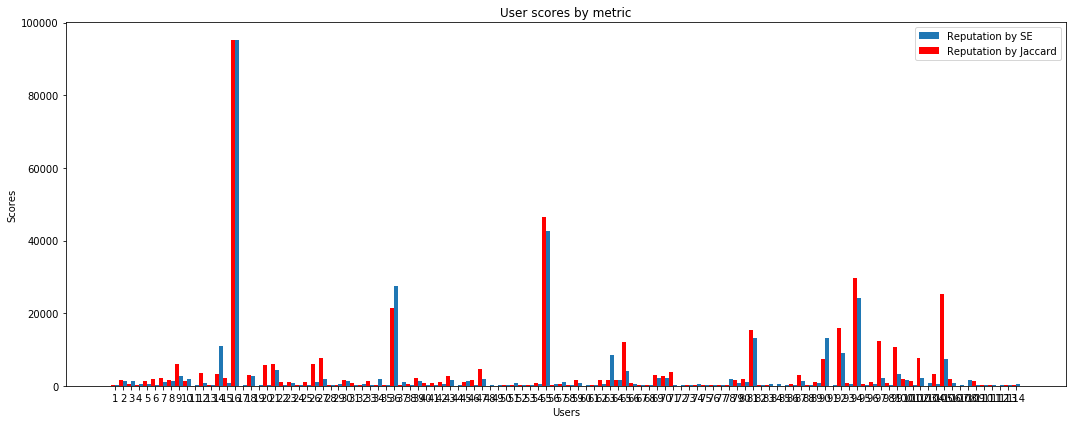

In [ ]:
corr_coef = present_user_rep['userId1352']/phrases_overal_jacq_sim['userId1352']
scaled_user_rep = {key : present_user_rep[key]/corr_coef for key in present_user_rep}
scaled_jacc_rep = {key : int(phrases_overal_jacq_sim[key]*corr_coef) for key in metrics.min_max_normalize(phrases_overal_jacq_sim)}
ploting.plot_vals(val_dict1=present_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard")

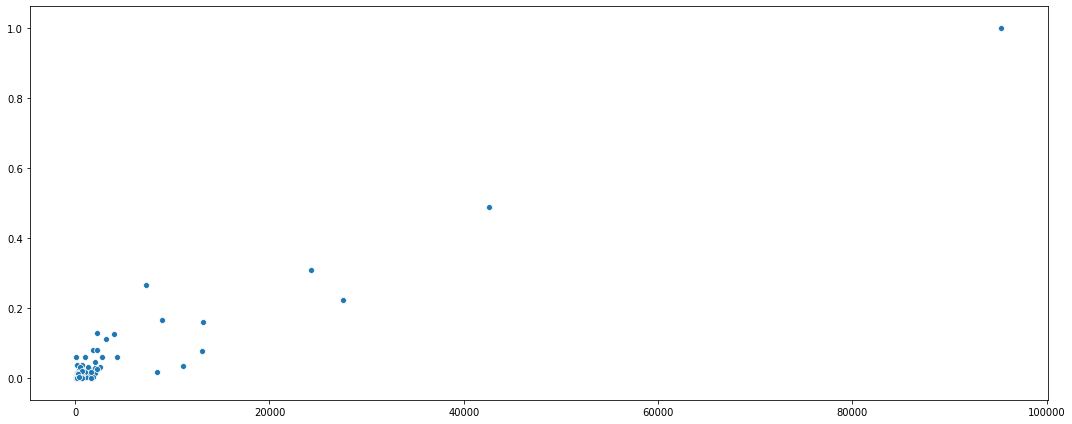

In [ ]:
np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [ ]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.         0.96275054]
 [0.96275054 1.        ]]


In [ ]:
print(calculate_order_score(phrases_overal_jacq_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_jacq_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_jacq_sim, present_user_rep, corr_coef))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

In [ ]:
# Z score
# 1352: 28.896449047944508,
# 79256: 7.216053531635459,
# 8500: 6.563924617405255,
# 1813: 4.458963213705229,
# 66: 4.458892287340829,
# 3922: 4.426352063787131,
# 24912: 4.024922359499621,
# 91249: 2.5298221281347035,
# 82: 2.523573072576179,

Checking if our model isnt biased by the size of user models

In [ ]:
df = get_sorted_file_list_by_size(phrases_overal_jacq_sim, "D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\answers")

In [ ]:
df.head(20)

,UserID,Metric score,file_size
15,userId1352,1.000000,747927
54,userId3249,0.488713,192201
93,userId7167,0.310467,110915
91,userId7080,0.166832,79009
35,userId2314,0.224687,70386
104,userId90992,0.265620,54876
80,userId5692,0.159966,51428
101,userId8500,0.080348,26354
89,userId66,0.077919,26119
98,userId79256,0.111868,25411


Doesnt look like it - first 3 positions match but the rest not 

Cosine similarity

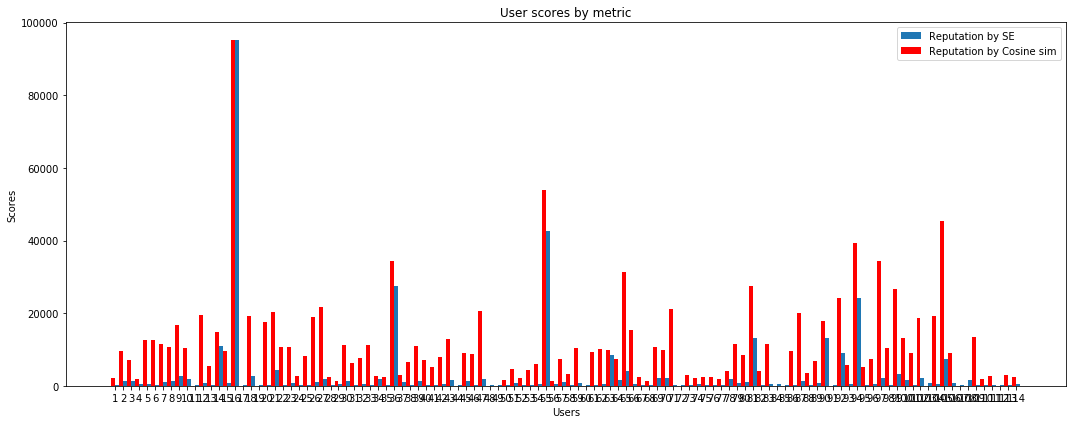

In [ ]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, merged_book)

# normalizing the score 
phrases_overal_cos_sim = metrics.min_max_normalize(phrases_overal_cos_sim)

corr_coef2 = present_user_rep['userId1352']/phrases_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : present_user_rep[key]/corr_coef2 for key in present_user_rep}
scaled_cos_rep = {key : int(phrases_overal_cos_sim[key]*corr_coef2) for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=present_user_rep, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

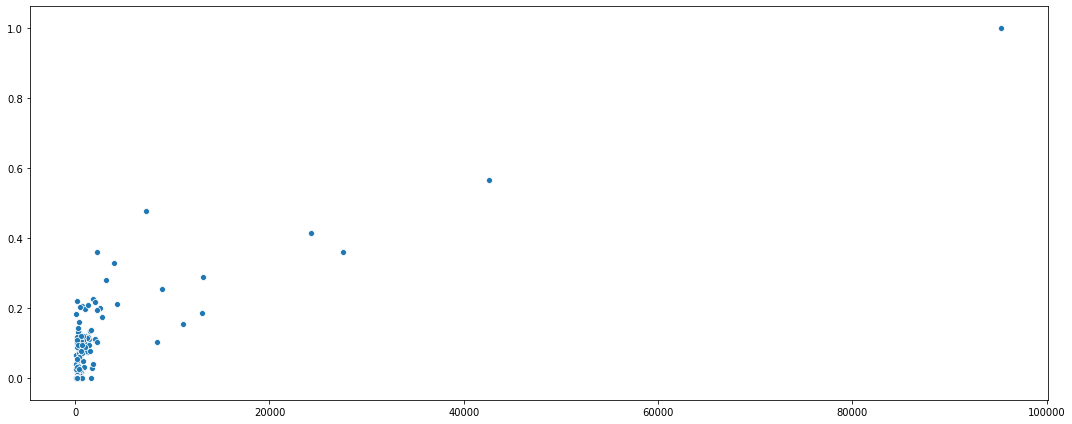

In [ ]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [ ]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.82413122]
 [0.82413122 1.        ]]


In [ ]:
# calculate_order_score(phrases_overal_cos_sim, present_user_rep)
print(calculate_order_score(phrases_overal_cos_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_cos_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_cos_sim, present_user_rep, corr_coef2))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'

Euclidean distance

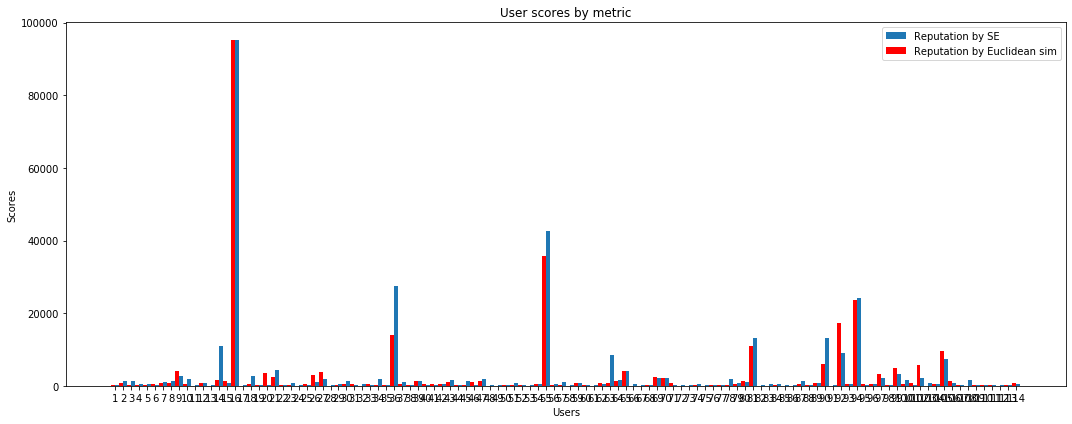

In [ ]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, merged_book)

# normalizing the score 
phrases_overal_euclid_sim = metrics.min_max_normalize(phrases_overal_euclid_sim)

corr_coef3 = present_user_rep['userId1352']/phrases_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : present_user_rep[key]/corr_coef3 for key in present_user_rep}
scaled_euclid_rep = {key : int(phrases_overal_euclid_sim[key]*corr_coef3) for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=present_user_rep, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

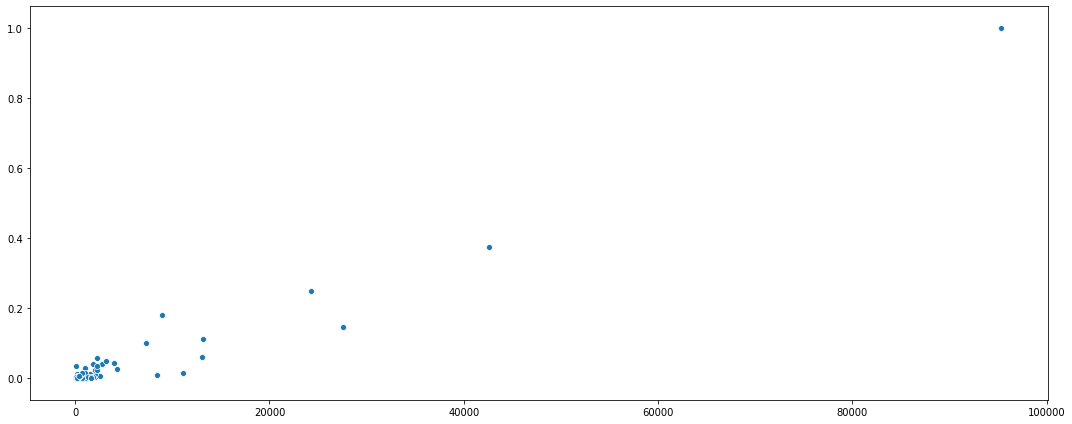

In [ ]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [ ]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.97670264]
 [0.97670264 1.        ]]


In [ ]:
# calculate_order_score(phrases_overal_euclid_sim, present_user_rep)
print(calculate_order_score(phrases_overal_euclid_sim, present_user_rep))
print(calculate_max_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_mean_deviation(phrases_overal_euclid_sim, present_user_rep))
print(calculate_total_deviation(phrases_overal_euclid_sim, present_user_rep, corr_coef3))

reference list: ['userId57681', 'userId48538', 'userId24681', 'userId92366', 'userId282899', 'userId146161', 'userId97556', 'userId125350', 'userId94922', 'userId61731', 'userId54786', 'userId77009', 'userId173159', 'userId48295', 'userId98498', 'userId315606', 'userId6703', 'userId13937', 'userId155976', 'userId47207', 'userId49377', 'userId271094', 'userId43607', 'userId101210', 'userId19232', 'userId59603', 'userId280963', 'userId73424', 'userId97857', 'userId227552', 'userId43880', 'userId3766', 'userId260713', 'userId311114', 'userId127226', 'userId106835', 'userId18006', 'userId8369', 'userId201816', 'userId37721', 'userId34175', 'userId29472', 'userId94044', 'userId51550', 'userId251840', 'userId144', 'userId230189', 'userId6330', 'userId25015', 'userId255048', 'userId42267', 'userId3354', 'userId223337', 'userId9915', 'userId71391', 'userId104231', 'userId31706', 'userId49207', 'userId86778', 'userId19256', 'userId57752', 'userId102854', 'userId3801', 'userId5879', 'userId7610'